In [1]:
pip install torch pandas numpy scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import os
import time
import copy
import pickle

# --- 0. Настройка среды Google Colab и Конфигурация ---
try:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = '/content/drive/MyDrive/' # ИЗМЕНИТЕ ПУТЬ
    print(f"Google Drive смонтирован. Базовый путь: {base_path}")
except ModuleNotFoundError:
    print("Google Colab Drive не доступен.")
    base_path = './'

# --- КОНФИГУРАЦИЯ ---

# Параметры последовательности
SEQUENCE_LENGTH = 20 # Можно попробовать немного увеличить окно

# Параметры разделения и обучения
FINAL_TEST_SET_SIZE = 0.1
K_FOLDS = 3
VAL_SPLIT_FOR_FINAL = 0.1
batch_size = 64
learning_rate = 0.001
epochs = 200 # Макс. кол-во эпох

# >>> ПАРАМЕТРЫ CNN-GRU МОДЕЛИ <<<
CNN_OUT_CHANNELS = 32 # Количество фильтров (признаков) после CNN
CNN_KERNEL_SIZE = 3   # Размер окна свертки (например, 3 или 5)
GRU_HIDDEN_SIZE = 64 # Размер скрытого состояния GRU
GRU_NUM_LAYERS = 1   # Попробуем 1 слой GRU после CNN
MLP_HIDDEN_SIZE = 32 # Размер скрытого слоя в MLP после GRU
DROPOUT_RATE = 0.3   # Dropout

# Параметры улучшений
EARLY_STOPPING_PATIENCE = 500
SCHEDULER_PATIENCE = 100
SCHEDULER_FACTOR = 0.1
WEIGHT_DECAY = 1e-5

random_seed = 42
# --- КОНЕЦ КОНФИГУРАЦИИ ---


# Определение устройства

# Установка random seed


# --- НОВЫЕ НАСТРОЙКИ ДЛЯ ЗАГРУЗКИ ---
# Укажите правильное имя финального датасета (с эмбеддингами, без NaN)
input_parquet_file_name = '0moex_qcml_final_dataset_with_embeddings.parquet'
# input_parquet_file_name = 'moex_qcml_final_dataset_cleaned_with_news.csv' # Если сохраняли как CSV

# --- ИЗМЕНЕНА ЦЕЛЕВАЯ ПЕРЕМЕННАЯ ---
target_col = 'FinalTarget'

# Пути к модели и scaler'у можно оставить или изменить по желанию
model_save_name = 'cnn_gru_nn_qcml.pth'
scaler_save_name = 'scaler_cnn_gru_qcml.pth'
# --- КОНЕЦ НОВЫХ НАСТРОЕК ---

# Формируем полный путь к файлу данных
file_path = os.path.join(base_path, input_parquet_file_name)
MODEL_SAVE_PATH = os.path.join(base_path, model_save_name)
SCALER_SAVE_PATH = os.path.join(base_path, scaler_save_name)
print(f"Файл данных: {file_path}"); print(f"Модель: {MODEL_SAVE_PATH}"); print(f"Scaler: {SCALER_SAVE_PATH}")

# Определение устройства (без изменений)
if torch.cuda.is_available(): device = torch.device("cuda"); print(f"GPU: {torch.cuda.get_device_name(0)}")
else: device = torch.device("cpu"); print("CPU.")

# Установка random seed (без изменений)
torch.manual_seed(random_seed); np.random.seed(random_seed)
if device.type == 'cuda': torch.cuda.manual_seed_all(random_seed); torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

# --- 1. Загрузка и обработка данных (МОДИФИЦИРОВАНО) ---
print("\n--- 1. Загрузка и обработка данных ---")
try:
    # --- ИЗМЕНЕНО: Загрузка Parquet/CSV без index_col ---
    print(f"Загрузка данных из: {file_path}")
    if file_path.endswith('.parquet'):
        df = pd.read_parquet(file_path)
    elif file_path.endswith('.csv'):
        # Убедимся, что TRADEDATE парсится как дата
        df = pd.read_csv(file_path, parse_dates=['TRADEDATE'])
    else:
         raise ValueError("Неподдерживаемый формат файла (нужен .parquet или .csv)")

    # --- ИЗМЕНЕНО: Проверка TRADEDATE как колонки ---
    if 'TRADEDATE' not in df.columns:
         raise ValueError("Колонка TRADEDATE отсутствует в загруженном файле.")
    if not pd.api.types.is_datetime64_any_dtype(df['TRADEDATE']):
         print("Конвертация TRADEDATE в datetime...")
         df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])
    # Сортируем по дате на всякий случай (важно для последовательностей)
    df = df.sort_values(by='TRADEDATE')
    print(f"Данные загружены. Форма: {df.shape}")
    print(f"Колонки: {df.columns.tolist()}")

except FileNotFoundError: raise SystemExit(f"Ошибка: Файл не найден: {file_path}")
except Exception as e: raise SystemExit(f"Ошибка чтения файла данных: {e}")

# --- Проверка и Выбор Признаков/Цели ---
if target_col not in df.columns: raise ValueError(f"Целевой столбец '{target_col}' не найден!")
# --- ИЗМЕНЕНО: Исключаем TRADEDATE из признаков ---
feature_cols = [col for col in df.columns if col not in [target_col, 'TRADEDATE']]
print(f"\nЦелевая переменная: {target_col}")
print(f"Используемые признаки ({len(feature_cols)}): {feature_cols}")
if not feature_cols: raise ValueError("Нет признаков для обучения.")

# --- Проверка и Очистка NaN (Ожидаем, что ничего не удалится) ---
print(f"\nРазмер данных до проверки NaN: {df.shape}")
initial_rows = len(df)
# Используем копию, чтобы не менять исходный df до применения scaler
df_cleaned = df.dropna(subset=[target_col] + feature_cols).copy()
rows_after_drop = len(df_cleaned)
print(f"Размер данных после проверки NaN: {df_cleaned.shape}")
if initial_rows != rows_after_drop:
     print(f"!!! WARNING: Были удалены строки с NaN ({initial_rows - rows_after_drop} шт.) !!!")
if df_cleaned.empty: raise ValueError("Нет данных после удаления NaN.")

# --- Добавление SMA (Без изменений, теперь для FinalTarget) ---
sma5_col_name = f'{target_col}_SMA5'
df_cleaned[sma5_col_name] = df_cleaned[target_col].rolling(window=5).mean().shift(1)
# Важно: df_cleaned['TRADEDATE'] теперь используется для понимания порядка, а не индекс
print(f"Добавлен столбец: {sma5_col_name}")

# --- КОНЕЦ МОДИФИЦИРОВАННОГО БЛОКА ---

# --- 2. Масштабирование признаков (БЕЗ ИЗМЕНЕНИЙ) ---
print("\n--- 2. Масштабирование признаков ---")
scaler = StandardScaler()
# Используем значения (values), так как порядок строк важен
X_scaled = scaler.fit_transform(df_cleaned[feature_cols].values)
y_unscaled = df_cleaned[target_col].values.reshape(-1, 1)
print(f"Признаки масштабированы. X_scaled shape: {X_scaled.shape}")
try:
    with open(SCALER_SAVE_PATH, 'wb') as f: pickle.dump(scaler, f)
    print(f"Scaler сохранен: {SCALER_SAVE_PATH}")
except Exception as e: print(f"Ошибка сохранения scaler: {e}")

# --- 3. Создание последовательностей (БЕЗ ИЗМЕНЕНИЙ, НО ИСПОЛЬЗУЕТСЯ TRADEDATE) ---
print("\n--- 3. Создание последовательностей ---")
def create_sequences(input_data, target_data, sequence_length):
    # ... (функция без изменений) ...
    sequences, targets = [], []
    for i in range(sequence_length, len(input_data)):
        sequences.append(input_data[i-sequence_length:i])
        targets.append(target_data[i])
    return np.array(sequences), np.array(targets)

X_seq, y_seq = create_sequences(X_scaled, y_unscaled, SEQUENCE_LENGTH)
# Получаем даты КОНЦА каждой последовательности для возможного анализа
# Используем TRADEDATE из df_cleaned, сдвинутый на SEQUENCE_LENGTH
original_dates_seq = df_cleaned['TRADEDATE'].iloc[SEQUENCE_LENGTH:].values
print(f"Созданы последовательности: X_seq shape={X_seq.shape}, y_seq shape={y_seq.shape}")
if X_seq.shape[0] == 0: raise ValueError("Не удалось создать последовательности.")

# --- 4. Разделение данных на ТЕМП и ФИНАЛЬНЫЙ ТЕСТ (БЕЗ ИЗМЕНЕНИЙ, НО ИСПОЛЬЗУЕТСЯ TRADEDATE) ---
print("-" * 30); print(f"Разделение последовательностей на ТЕМП и ФИНАЛЬНЫЙ ТЕСТ...")
X_temp, X_final_test, y_temp, y_final_test, temp_dates, final_test_dates = train_test_split(
    X_seq, y_seq, original_dates_seq, test_size=FINAL_TEST_SET_SIZE, shuffle=False
)
print(f"Размер ТЕМП X: {X_temp.shape}, ФИНАЛЬНЫЙ ТЕСТ X: {X_final_test.shape}"); print("-" * 30)


# --- 5. Определение НОВОЙ МОДЕЛИ (CNN-GRU) ---
class CNNGRUModel(nn.Module):
    def __init__(self, input_dim, cnn_out_channels, kernel_size, gru_hidden_dim, gru_num_layers, mlp_hidden, output_dim=1, dropout_rate=0.0):
        super(CNNGRUModel, self).__init__()
        self.dropout_rate = dropout_rate

        # 1D CNN Слой
        # Вход: (N, C_in, L_in) = (batch_size, input_dim, sequence_length)
        # Выход: (N, C_out, L_out) = (batch_size, cnn_out_channels, sequence_length) (с padding='same')
        # Нам нужно сначала поменять местами sequence_length и input_dim
        self.conv1d = nn.Conv1d(in_channels=input_dim,
                                out_channels=cnn_out_channels,
                                kernel_size=kernel_size,
                                padding='same') # 'same' сохраняет длину последовательности
        self.bn1 = nn.BatchNorm1d(cnn_out_channels) # BatchNorm применяется к каналам
        self.relu1 = nn.ReLU()
        self.dropout_cnn = nn.Dropout(dropout_rate)

        # GRU Слой
        # Вход: (N, L, H_in) = (batch_size, sequence_length, cnn_out_channels)
        # Выход hn: (num_layers, N, H_out) = (gru_num_layers, batch_size, gru_hidden_dim)
        # Нам нужно снова поменять местами измерения после CNN
        self.gru = nn.GRU(input_size=cnn_out_channels, # Входной размер GRU = выход CNN
                          hidden_size=gru_hidden_dim,
                          num_layers=gru_num_layers,
                          batch_first=True, # Ожидаем (batch, seq, feature)
                          dropout=dropout_rate if gru_num_layers > 1 else 0)

        # MLP Голова
        self.mlp = nn.Sequential(
            nn.Linear(gru_hidden_dim, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(mlp_hidden, output_dim)
        )

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_dim)

        # --- CNN Часть ---
        # Меняем местами измерения для Conv1d: (N, C_in, L_in)
        x_cnn = x.permute(0, 2, 1)
        x_cnn = self.conv1d(x_cnn)
        x_cnn = self.bn1(x_cnn)
        x_cnn = self.relu1(x_cnn)
        x_cnn = self.dropout_cnn(x_cnn)
        # Меняем местами обратно для GRU: (N, L_out, C_out)
        x_gru_input = x_cnn.permute(0, 2, 1)

        # --- GRU Часть ---
        # Инициализация скрытого состояния (не обязательно, GRU сделает это по умолчанию)
        # h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        # out_gru, hn = self.gru(x_gru_input, h0)
        out_gru, hn = self.gru(x_gru_input) # Используем выход последнего шага

        # --- MLP Часть ---
        # Берем выход GRU с последнего временного шага
        # out_gru shape: (batch_size, sequence_length, gru_hidden_dim)
        last_time_step_out = out_gru[:, -1, :]
        # Или можно взять последнее скрытое состояние: hn[-1] для последнего слоя
        # last_time_step_out = hn[-1] # shape: (batch_size, gru_hidden_dim)

        output = self.mlp(last_time_step_out)
        return output
input_dim = X_seq.shape[2] # Количество признаков
# --- 6. Кросс-валидация ---
kf = KFold(n_splits=K_FOLDS, shuffle=False)
fold_mses, fold_r2s = [], []
best_epochs_per_fold = []
print(f"\n--- Начало {K_FOLDS}-кратной кросс-валидации (CNN-GRU NN + Улучшения) ---")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_temp, y_temp)):
    print(f"\n--- ФОЛД {fold+1}/{K_FOLDS} ---")
    # Подготовка данных
    X_train_fold, X_val_fold = X_temp[train_idx], X_temp[val_idx]
    y_train_fold, y_val_fold = y_temp[train_idx], y_temp[val_idx]
    X_train_fold_tensor = torch.tensor(X_train_fold, dtype=torch.float32).to(device)
    y_train_fold_tensor = torch.tensor(y_train_fold, dtype=torch.float32).to(device)
    X_val_fold_tensor = torch.tensor(X_val_fold, dtype=torch.float32).to(device)
    y_val_fold_tensor = torch.tensor(y_val_fold, dtype=torch.float32).to(device)
    train_fold_dataset = TensorDataset(X_train_fold_tensor, y_train_fold_tensor); train_fold_loader = DataLoader(train_fold_dataset, batch_size=batch_size, shuffle=True)
    val_fold_dataset = TensorDataset(X_val_fold_tensor, y_val_fold_tensor); val_fold_loader = DataLoader(val_fold_dataset, batch_size=batch_size, shuffle=False)

    # >>> Инициализация CNN-GRU модели <<<
    model = CNNGRUModel(input_dim=input_dim, cnn_out_channels=CNN_OUT_CHANNELS, kernel_size=CNN_KERNEL_SIZE,
                       gru_hidden_dim=GRU_HIDDEN_SIZE, gru_num_layers=GRU_NUM_LAYERS,
                       mlp_hidden=MLP_HIDDEN_SIZE, dropout_rate=DROPOUT_RATE).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE, verbose=False)

    # Обучение фолда
    best_val_loss = float('inf'); epochs_no_improve = 0; best_model_state = None; best_epoch = -1
    start_time_fold = time.time(); print(f"  Начало обучения фолда {fold+1} (модель CNN-GRU)...")
    for epoch in range(epochs):
        model.train(); train_loss_epoch = 0.0; batches_processed_train = 0
        for batch_X, batch_y in train_fold_loader:
            optimizer.zero_grad(); outputs = model(batch_X); loss = criterion(outputs, batch_y)
            loss.backward(); optimizer.step()
            train_loss_epoch += loss.item(); batches_processed_train += 1
        avg_train_loss = train_loss_epoch / batches_processed_train if batches_processed_train > 0 else 0
        model.eval(); val_loss_epoch = 0.0; batches_processed_val = 0
        with torch.no_grad():
            for batch_X_val, batch_y_val in val_fold_loader:
                outputs_val = model(batch_X_val); loss_val = criterion(outputs_val, batch_y_val)
                val_loss_epoch += loss_val.item(); batches_processed_val += 1
        avg_val_loss = val_loss_epoch / batches_processed_val if batches_processed_val > 0 else float('inf')
        if (epoch + 1) % 1 == 0: print(f'    Фолд {fold+1}, Эпоха [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {optimizer.param_groups[0]["lr"]:.1e}')
        scheduler.step(avg_val_loss)
        if avg_val_loss < best_val_loss: best_val_loss = avg_val_loss; best_model_state = copy.deepcopy(model.state_dict()); best_epoch = epoch + 1; epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= EARLY_STOPPING_PATIENCE: print(f"    Ранняя остановка!"); break
    end_time_fold = time.time(); print(f"  Обучение фолда {fold+1} завершено на эпохе {epoch+1} (лучший {best_epoch}) за {end_time_fold - start_time_fold:.2f} сек.")
    best_epochs_per_fold.append(best_epoch)

    # Оценка лучшей модели фолда
    if best_model_state: model.load_state_dict(best_model_state)
    else: print("  Предупреждение: Используется последняя модель фолда.")
    model.eval()
    with torch.no_grad(): y_val_pred = model(X_val_fold_tensor).cpu().numpy()
    mse_fold = mean_squared_error(y_val_fold, y_val_pred); r2_fold = r2_score(y_val_fold, y_val_pred)
    print(f"  Метрики валидации фолда {fold+1} (лучшая): MSE={mse_fold:.4f}, R²={r2_fold:.4f}")
    fold_mses.append(mse_fold); fold_r2s.append(r2_fold)

# --- Результаты кросс-валидации ---
print("\n--- Сводные результаты К-кратной кросс-валидации (CNN-GRU NN + Улучшения) ---")
print(f"Среднее MSE по фолдам: {np.mean(fold_mses):.4f} (+/- {np.std(fold_mses):.4f})")
print(f"Среднее R² по фолдам: {np.mean(fold_r2s):.4f} (+/- {np.std(fold_r2s):.4f})")
print(f"Среднее количество 'лучших' эпох: {np.mean(best_epochs_per_fold):.1f} (+/- {np.std(best_epochs_per_fold):.1f})")

# --- 7. Обучение ФИНАЛЬНОЙ модели ---
print("\n--- Обучение финальной модели на ТЕМП данных (CNN-GRU NN + Улучшения) ---")
# Подготовка данных
X_train_final_seq, X_val_final_seq, y_train_final_seq, y_val_final_seq = train_test_split(X_temp, y_temp, test_size=VAL_SPLIT_FOR_FINAL, random_state=random_seed, shuffle=True)
X_train_final_tensor = torch.tensor(X_train_final_seq, dtype=torch.float32).to(device); y_train_final_tensor = torch.tensor(y_train_final_seq, dtype=torch.float32).to(device)
X_val_final_tensor = torch.tensor(X_val_final_seq, dtype=torch.float32).to(device); y_val_final_tensor = torch.tensor(y_val_final_seq, dtype=torch.float32).to(device)
final_train_dataset = TensorDataset(X_train_final_tensor, y_train_final_tensor); final_train_loader = DataLoader(final_train_dataset, batch_size=batch_size, shuffle=True)
final_val_dataset = TensorDataset(X_val_final_tensor, y_val_final_tensor); final_val_loader = DataLoader(final_val_dataset, batch_size=batch_size, shuffle=False)

# >>> Инициализация CNN-GRU финальной модели <<<
final_model = CNNGRUModel(input_dim=input_dim, cnn_out_channels=CNN_OUT_CHANNELS, kernel_size=CNN_KERNEL_SIZE,
                       gru_hidden_dim=GRU_HIDDEN_SIZE, gru_num_layers=GRU_NUM_LAYERS,
                       mlp_hidden=MLP_HIDDEN_SIZE, dropout_rate=DROPOUT_RATE).to(device)
final_criterion = nn.MSELoss()
final_optimizer = optim.Adam(final_model.parameters(), lr=learning_rate, weight_decay=WEIGHT_DECAY)
final_scheduler = ReduceLROnPlateau(final_optimizer, mode='min', factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE, verbose=False)

# Обучение финальной модели
best_val_loss_final = float('inf'); epochs_no_improve_final = 0; best_model_state_final = None; best_epoch_final = -1; final_train_losses_history = []
print(f"  Начало финального обучения (модель CNN-GRU)...")
start_time_final = time.time()
for epoch in range(epochs):
    final_model.train(); train_loss_epoch = 0.0; batches_processed_train = 0
    for batch_X, batch_y in final_train_loader:
        final_optimizer.zero_grad(); outputs = final_model(batch_X); loss = final_criterion(outputs, batch_y)
        loss.backward(); final_optimizer.step()
        train_loss_epoch += loss.item(); batches_processed_train += 1
    avg_train_loss = train_loss_epoch / batches_processed_train if batches_processed_train > 0 else 0; final_train_losses_history.append(avg_train_loss)
    final_model.eval(); val_loss_epoch = 0.0; batches_processed_val = 0
    with torch.no_grad():
        for batch_X_val, batch_y_val in final_val_loader:
            outputs_val = final_model(batch_X_val); loss_val = final_criterion(outputs_val, batch_y_val)
            val_loss_epoch += loss_val.item(); batches_processed_val += 1
    avg_val_loss = val_loss_epoch / batches_processed_val if batches_processed_val > 0 else float('inf')
    if (epoch + 1) % 1 == 0: print(f'    Финал. обуч., Эпоха [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {final_optimizer.param_groups[0]["lr"]:.1e}')
    final_scheduler.step(avg_val_loss)
    if avg_val_loss < best_val_loss_final: best_val_loss_final = avg_val_loss; best_model_state_final = copy.deepcopy(final_model.state_dict()); best_epoch_final = epoch + 1; epochs_no_improve_final = 0
    else:
        epochs_no_improve_final += 1
        if epochs_no_improve_final >= EARLY_STOPPING_PATIENCE: print(f"    Ранняя остановка фин. обучения!"); break
end_time_final = time.time(); print(f"Финальное обучение завершено на эпохе {epoch+1} (лучший {best_epoch_final}) за {end_time_final - start_time_final:.2f} сек.")

# --- 8. Сохранение ЛУЧШЕЙ ФИНАЛЬНОЙ модели ---
if best_model_state_final:
    try:
        torch.save(best_model_state_final, MODEL_SAVE_PATH); print(f"Лучшая финальная модель ({best_epoch_final}) сохранена: {MODEL_SAVE_PATH}")
        final_model.load_state_dict(best_model_state_final)
    except Exception as e: print(f"Ошибка сохранения/загрузки: {e}")
else: print("Предупреждение: Используется последняя модель.")

# --- 9. Оценка ФИНАЛЬНОЙ модели на ОТДЕЛЬНОМ ТЕСТЕ + Сравнение с SMA(5) ---
print("\n--- Оценка ЛУЧШЕЙ ФИНАЛЬНОЙ модели на ОТДЕЛЬНОМ ФИНАЛЬНОМ ТЕСТЕ ---")
final_model.eval()
# ВАЖНО: X_final_test УЖЕ содержит ПОСЛЕДОВАТЕЛЬНОСТИ масштабированных данных
X_final_test_tensor_eval = torch.tensor(X_final_test, dtype=torch.float32).to(device)
with torch.no_grad(): y_pred_nn = final_model(X_final_test_tensor_eval).cpu().numpy()
# Получение предсказаний SMA(5) для соответствующих дат КОНЦА последовательностей
sma5_values_for_test = df_cleaned.set_index('TRADEDATE').loc[final_test_dates, sma5_col_name].values.reshape(-1, 1)
y_pred_sma5 = sma5_values_for_test

mean_y_test = np.mean(y_final_test); nan_mask_sma5 = np.isnan(y_pred_sma5)
if np.any(nan_mask_sma5): print(f"Заполнение {np.sum(nan_mask_sma5)} NaN в SMA(5)..."); y_pred_sma5[nan_mask_sma5] = mean_y_test
else: print("NaN в SMA(5) не обнаружено.")

# Расчет метрик
mse_final_nn = mean_squared_error(y_final_test, y_pred_nn); r2_final_nn = r2_score(y_final_test, y_pred_nn)
ssr_model = mse_final_nn * len(y_final_test)
mse_final_sma5 = mean_squared_error(y_final_test, y_pred_sma5); ssr_baseline_sma5 = mse_final_sma5 * len(y_final_test)
r2_vs_sma5 = 1 - (ssr_model / ssr_baseline_sma5) if ssr_baseline_sma5 > 1e-9 else 0.0

print("\n--- Результаты оценки (CNN-GRU NN + Улучшения) ---")
print(f"MSE NN:               {mse_final_nn:.4f}")
print(f"RMSE NN:              {np.sqrt(mse_final_nn):.4f}")
print(f"MAE NN:               {mean_absolute_error(y_final_test, y_pred_nn):.4f}")
print(f"R² NN (vs Mean):      {r2_final_nn:.4f}")
print("---")
print(f"MSE Базовой SMA(5):   {mse_final_sma5:.4f}")
print(f"R² NN (vs SMA(5)):    {r2_vs_sma5:.4f}") # <<< СРАВНЕНИЕ С SMA(5)

 # Переименовываем для совместимости с остальным кодом
# ... (остальной код расчета метрик) ...


# --- 10. Визуализация (Изменено для использования Дат) ---
print("\n--- 10. Визуализация ---")
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1); plt.scatter(y_final_test, y_pred_nn, alpha=0.6, label='Предсказание CNN-GRU vs Реальность')
plt.plot([y_final_test.min(), y_final_test.max()], [y_final_test.min(), y_final_test.max()], 'r--', lw=2, label='Идеал')
plt.xlabel("Реальные"), plt.ylabel("Предсказанные (CNN-GRU)"); plt.title(f"Сравнение (Фин. тест, CNN-GRU)\nЦель: {target_col}")
plt.legend(), plt.grid(True); plt.subplot(1, 2, 2)
# --- ИЗМЕНЕНО: Используем final_test_dates как индекс ---
results_final_test_df = pd.DataFrame({'Real': y_final_test.flatten(), 'Predicted_NN': y_pred_nn.flatten(), 'Predicted_SMA5': y_pred_sma5.flatten()}, index=final_test_dates).sort_index()
n_points_to_plot = min(100, len(results_final_test_df))
plt.plot(results_final_test_df.index[:n_points_to_plot], results_final_test_df['Real'][:n_points_to_plot], 'b-o', label='Реальные', markersize=4, alpha=0.7)
plt.plot(results_final_test_df.index[:n_points_to_plot], results_final_test_df['Predicted_NN'][:n_points_to_plot], 'r-x', label='Предсказания CNN-GRU', markersize=4, alpha=0.7)
plt.plot(results_final_test_df.index[:n_points_to_plot], results_final_test_df['Predicted_SMA5'][:n_points_to_plot], 'g--^', label='Предсказания SMA(5)', markersize=4, alpha=0.7)
plt.xlabel("Дата"), plt.ylabel("Значение " + target_col); plt.title(f"Предсказания vs Реальность ({n_points_to_plot} точек теста)\nЦель: {target_col}")
plt.xticks(rotation=45), plt.legend(), plt.grid(True); plt.tight_layout(); plt.show()
# ... (код графика потерь без изменений) ...
plt.figure(figsize=(10, 5)); plt.plot(range(1, len(final_train_losses_history) + 1), final_train_losses_history, label='MSE Обучения')
plt.xlabel("Эпоха"), plt.ylabel("Средняя ошибка"); plt.title("Динамика ошибки финального обучения (CNN-GRU NN)"); plt.legend(), plt.grid(True); plt.show()

# --- (Дополнительно) Пример загрузки ---
print("\n--- Пример загрузки сохраненной модели и scaler ---")
try:
    loaded_model = CNNGRUModel(input_dim=input_dim, cnn_out_channels=CNN_OUT_CHANNELS, kernel_size=CNN_KERNEL_SIZE,
                               gru_hidden_dim=GRU_HIDDEN_SIZE, gru_num_layers=GRU_NUM_LAYERS,
                               mlp_hidden=MLP_HIDDEN_SIZE, dropout_rate=DROPOUT_RATE)
    try:
        loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
        loaded_model.to(device); loaded_model.eval()
        print(f"Модель CNN-GRU успешно загружена из {MODEL_SAVE_PATH}")
    except FileNotFoundError: print(f"Файл модели {MODEL_SAVE_PATH} не найден.")
    except Exception as e: print(f"Ошибка при загрузке модели: {e}")
except NameError: print("Переменная 'input_dim' не определена.")
try:
    with open(SCALER_SAVE_PATH, 'rb') as f: loaded_scaler = pickle.load(f)
    print(f"Scaler успешно загружен из {SCALER_SAVE_PATH}")
    # Пример использования:
    # last_sequence = ... # ваши последние SEQUENCE_LENGTH дней признаков, shape (sequence_length, input_dim)
    # last_sequence_scaled = loaded_scaler.transform(last_sequence)
    # new_data_tensor = torch.tensor(last_sequence_scaled, dtype=torch.float32).unsqueeze(0).to(device) # Добавляем batch dimension
    # if 'loaded_model' in locals():
    #     with torch.no_grad(): prediction = loaded_model(new_data_tensor)
    #     print(f"Предсказание для следующего шага: {prediction.item()}")
except FileNotFoundError: print(f"Файл scaler'а {SCALER_SAVE_PATH} не найден.")
except Exception as e: print(f"Ошибка при загрузке scaler'а: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive смонтирован. Базовый путь: /content/drive/MyDrive/
Файл данных: /content/drive/MyDrive/0moex_qcml_final_dataset_with_embeddings.parquet
Модель: /content/drive/MyDrive/cnn_gru_nn_qcml.pth
Scaler: /content/drive/MyDrive/scaler_cnn_gru_qcml.pth
GPU: Tesla T4

--- 1. Загрузка и обработка данных ---
Загрузка данных из: /content/drive/MyDrive/0moex_qcml_final_dataset_with_embeddings.parquet
Данные загружены. Форма: (167586, 20)
Колонки: ['TRADEDATE', 'norm_Momentum', 'norm_Size', 'norm_Beta', 'news_sentiment_accel_1d_z21', 'news_topic_entropy_daily_z21', 'news_sentiment_extreme_1d_z21', 'news_topic_shock_1d_z21', 'news_topic_intensity_MacroRF_1d_z21', 'news_topic_intensity_MonPolicy_1d_z21', 'news_topic_intensity_Geopol_1d_z21', 'news_sentiment_level_21d_z63', 'news_topic_entropy_level_21d_z63', 'news_topic_intensity_OilGas_21d_z63', 'news_topic_intens

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Начало обучения фолда 1 (модель CNN-GRU)...
    Фолд 1, Эпоха [1/200], Train Loss: 0.959505, Val Loss: 0.993105, LR: 1.0e-03
    Фолд 1, Эпоха [2/200], Train Loss: 0.957304, Val Loss: 0.993175, LR: 1.0e-03
    Фолд 1, Эпоха [3/200], Train Loss: 0.956913, Val Loss: 0.992135, LR: 1.0e-03
    Фолд 1, Эпоха [4/200], Train Loss: 0.956491, Val Loss: 0.991513, LR: 1.0e-03
    Фолд 1, Эпоха [5/200], Train Loss: 0.955580, Val Loss: 0.990611, LR: 1.0e-03
    Фолд 1, Эпоха [6/200], Train Loss: 0.955347, Val Loss: 0.990559, LR: 1.0e-03
    Фолд 1, Эпоха [7/200], Train Loss: 0.954521, Val Loss: 0.989509, LR: 1.0e-03
    Фолд 1, Эпоха [8/200], Train Loss: 0.952993, Val Loss: 0.988375, LR: 1.0e-03
    Фолд 1, Эпоха [9/200], Train Loss: 0.951754, Val Loss: 0.987455, LR: 1.0e-03
    Фолд 1, Эпоха [10/200], Train Loss: 0.950900, Val Loss: 0.985763, LR: 1.0e-03
    Фолд 1, Эпоха [11/200], Train Loss: 0.948216, Val Loss: 0.982349, LR: 1.0e-03
    Фолд 1, Эпоха [12/200], Train Loss: 0.945245, Val Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Начало обучения фолда 2 (модель CNN-GRU)...
    Фолд 2, Эпоха [1/200], Train Loss: 0.975785, Val Loss: 0.958454, LR: 1.0e-03
    Фолд 2, Эпоха [2/200], Train Loss: 0.974666, Val Loss: 0.958624, LR: 1.0e-03
    Фолд 2, Эпоха [3/200], Train Loss: 0.974085, Val Loss: 0.957755, LR: 1.0e-03
    Фолд 2, Эпоха [4/200], Train Loss: 0.973583, Val Loss: 0.957472, LR: 1.0e-03
    Фолд 2, Эпоха [5/200], Train Loss: 0.973063, Val Loss: 0.957187, LR: 1.0e-03
    Фолд 2, Эпоха [6/200], Train Loss: 0.972230, Val Loss: 0.955597, LR: 1.0e-03
    Фолд 2, Эпоха [7/200], Train Loss: 0.971255, Val Loss: 0.956038, LR: 1.0e-03
    Фолд 2, Эпоха [8/200], Train Loss: 0.970146, Val Loss: 0.954415, LR: 1.0e-03
    Фолд 2, Эпоха [9/200], Train Loss: 0.967941, Val Loss: 0.953483, LR: 1.0e-03
    Фолд 2, Эпоха [10/200], Train Loss: 0.965334, Val Loss: 0.950462, LR: 1.0e-03
    Фолд 2, Эпоха [11/200], Train Loss: 0.963642, Val Loss: 0.948920, LR: 1.0e-03
    Фолд 2, Эпоха [12/200], Train Loss: 0.960171, Val Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Начало обучения фолда 3 (модель CNN-GRU)...
    Фолд 3, Эпоха [1/200], Train Loss: 0.977104, Val Loss: 0.955627, LR: 1.0e-03
    Фолд 3, Эпоха [2/200], Train Loss: 0.975844, Val Loss: 0.955720, LR: 1.0e-03
    Фолд 3, Эпоха [3/200], Train Loss: 0.975109, Val Loss: 0.955505, LR: 1.0e-03
    Фолд 3, Эпоха [4/200], Train Loss: 0.974653, Val Loss: 0.954684, LR: 1.0e-03
    Фолд 3, Эпоха [5/200], Train Loss: 0.973980, Val Loss: 0.954373, LR: 1.0e-03
    Фолд 3, Эпоха [6/200], Train Loss: 0.973012, Val Loss: 0.953654, LR: 1.0e-03
    Фолд 3, Эпоха [7/200], Train Loss: 0.971862, Val Loss: 0.952492, LR: 1.0e-03
    Фолд 3, Эпоха [8/200], Train Loss: 0.970243, Val Loss: 0.952119, LR: 1.0e-03
    Фолд 3, Эпоха [9/200], Train Loss: 0.968115, Val Loss: 0.948955, LR: 1.0e-03
    Фолд 3, Эпоха [10/200], Train Loss: 0.965887, Val Loss: 0.949195, LR: 1.0e-03
    Фолд 3, Эпоха [11/200], Train Loss: 0.964185, Val Loss: 0.942445, LR: 1.0e-03
    Фолд 3, Эпоха [12/200], Train Loss: 0.959809, Val Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Начало финального обучения (модель CNN-GRU)...
    Финал. обуч., Эпоха [1/200], Train Loss: 0.961571, Val Loss: 1.045074, LR: 1.0e-03
    Финал. обуч., Эпоха [2/200], Train Loss: 0.960620, Val Loss: 1.044684, LR: 1.0e-03
    Финал. обуч., Эпоха [3/200], Train Loss: 0.960390, Val Loss: 1.044313, LR: 1.0e-03
    Финал. обуч., Эпоха [4/200], Train Loss: 0.959895, Val Loss: 1.043484, LR: 1.0e-03
    Финал. обуч., Эпоха [5/200], Train Loss: 0.959137, Val Loss: 1.042163, LR: 1.0e-03
    Финал. обуч., Эпоха [6/200], Train Loss: 0.958079, Val Loss: 1.040588, LR: 1.0e-03
    Финал. обуч., Эпоха [7/200], Train Loss: 0.956554, Val Loss: 1.037837, LR: 1.0e-03
    Финал. обуч., Эпоха [8/200], Train Loss: 0.955359, Val Loss: 1.037520, LR: 1.0e-03
    Финал. обуч., Эпоха [9/200], Train Loss: 0.952707, Val Loss: 1.029711, LR: 1.0e-03
    Финал. обуч., Эпоха [10/200], Train Loss: 0.947049, Val Loss: 1.036304, LR: 1.0e-03
    Финал. обуч., Эпоха [11/200], Train Loss: 0.944525, Val Loss: 1.020274, LR: 

ValueError: Found input variables with inconsistent numbers of samples: [16757, 3473959]

Google Drive уже смонтирован.
Базовый путь: /content/drive/MyDrive/
Файл данных: /content/drive/MyDrive/0moex_qcml_final_dataset_with_embeddings.parquet
Модель для загрузки: /content/drive/MyDrive/cnn_gru_nn_qcml.pth
Scaler для загрузки: /content/drive/MyDrive/scaler_cnn_gru_qcml.pth
GPU: Tesla T4

--- 1. Загрузка и предобработка данных (для воссоздания тестового набора) ---
Загрузка данных из: /content/drive/MyDrive/0moex_qcml_final_dataset_with_embeddings.parquet
Данные загружены. Форма: (167586, 20)
Период данных: с 2021-04-20 00:00:00 по 2025-03-27 00:00:00

Целевая переменная: FinalTarget
Используемые признаки (18): ['norm_Momentum', 'norm_Size', 'norm_Beta', 'news_sentiment_accel_1d_z21', 'news_topic_entropy_daily_z21', 'news_sentiment_extreme_1d_z21', 'news_topic_shock_1d_z21', 'news_topic_intensity_MacroRF_1d_z21', 'news_topic_intensity_MonPolicy_1d_z21', 'news_topic_intensity_Geopol_1d_z21', 'news_sentiment_level_21d_z63', 'news_topic_entropy_level_21d_z63', 'news_topic_intens

<ipython-input-11-802c5064baa2>:525: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "^-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(plot_df['Дата'], plot_df['Predicted_Baseline'], '^-', label='Бейзлайн (DailyAvg SMA5)', markersize=5, linewidth=1.5, color='forestgreen', alpha=0.7, linestyle='--') # Используем пунктир


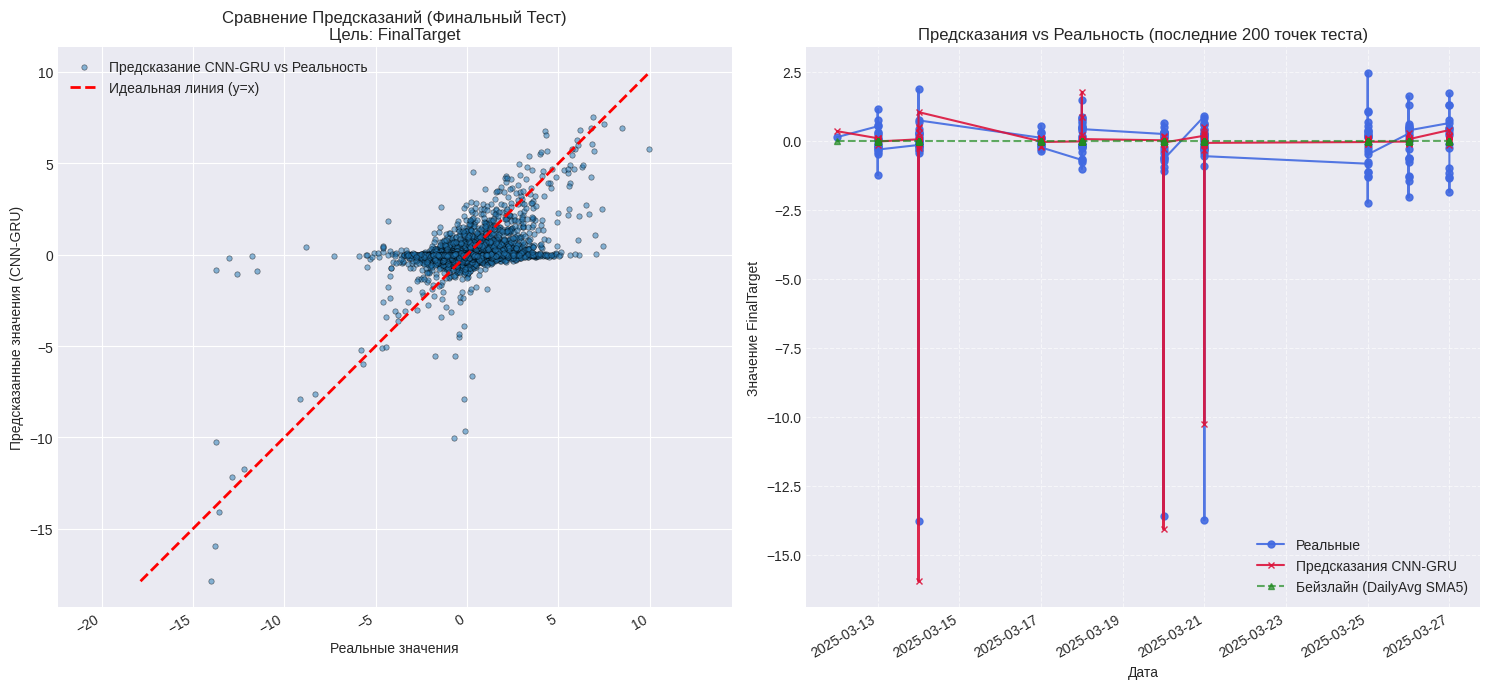


--- Оценка и визуализация завершены ---


In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
# import torch.optim as optim # Не нужен для оценки
# from torch.utils.data import TensorDataset, DataLoader, Subset # Не нужны для оценки
# from torch.optim.lr_scheduler import ReduceLROnPlateau # Не нужен для оценки
from sklearn.model_selection import train_test_split # Нужен для воссоздания сплита
# from sklearn.model_selection import KFold # Не нужен для оценки
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import os
import time
# import copy # Не нужен для оценки
import pickle

# --- 0. Настройка среды Google Colab и Конфигурация (КОПИЯ ИЗ ОРИГИНАЛА) ---
try:
    # Попробуем подключить Google Drive без принудительного монтирования, если уже смонтирован
    if not os.path.exists('/content/drive/MyDrive'):
        print("Монтирование Google Drive...")
        from google.colab import drive
        drive.mount('/content/drive')
    else:
        print("Google Drive уже смонтирован.")
    # !!! ИЗМЕНИТЕ ПУТЬ НА ВАШ В GOOGLE DRIVE !!!
    base_path = '/content/drive/MyDrive/'
    print(f"Базовый путь: {base_path}")
except ModuleNotFoundError:
    print("Google Colab Drive не доступен. Используется текущая директория.")
    base_path = './'
except Exception as e:
    print(f"Ошибка при работе с Google Drive: {e}")
    base_path = './'


# --- КОНФИГУРАЦИЯ (КОПИЯ ИЗ ОРИГИНАЛА - ВАЖНО!) ---

# Параметры последовательности (должны совпадать с теми, что были при обучении!)
SEQUENCE_LENGTH = 20

# Параметры разделения (должны совпадать с теми, что были при обучении!)
FINAL_TEST_SET_SIZE = 0.1
# K_FOLDS = 3 # Не нужно для оценки
# VAL_SPLIT_FOR_FINAL = 0.1 # Не нужно для оценки
# batch_size = 64 # Не нужно для оценки
# learning_rate = 0.001 # Не нужно для оценки
# epochs = 200 # Не нужно для оценки

# >>> ПАРАМЕТРЫ CNN-GRU МОДЕЛИ (должны совпадать с обученной моделью!) <<<
CNN_OUT_CHANNELS = 32
CNN_KERNEL_SIZE = 3
GRU_HIDDEN_SIZE = 64
GRU_NUM_LAYERS = 1
MLP_HIDDEN_SIZE = 32
DROPOUT_RATE = 0.3 # Должен совпадать, но в eval() режиме dropout неактивен

# Параметры улучшений (не используются при оценке, кроме random_seed)
# EARLY_STOPPING_PATIENCE = 500
# SCHEDULER_PATIENCE = 100
# SCHEDULER_FACTOR = 0.1
# WEIGHT_DECAY = 1e-5 # Не нужно для оценки

random_seed = 42 # !!! КРАЙНЕ ВАЖНО, чтобы воссоздать тот же split !!!
# --- КОНЕЦ КОНФИГУРАЦИИ ---

# --- Настройки файлов (КОПИЯ ИЗ ОРИГИНАЛА) ---
# Имя файла с данными, который ИСПОЛЬЗОВАЛСЯ ДЛЯ ОБУЧЕНИЯ
input_parquet_file_name = '0moex_qcml_final_dataset_with_embeddings.parquet'
# input_parquet_file_name = 'moex_qcml_final_dataset_cleaned_with_news.csv'

# Целевая переменная (должна совпадать с обучением)
target_col = 'FinalTarget'

# Пути к СОХРАНЕННЫМ модели и scaler'у
model_save_name = 'cnn_gru_nn_qcml.pth'
scaler_save_name = 'scaler_cnn_gru_qcml.pth' # Предполагаем, что scaler сохранялся как .pth, но может быть .pkl
# --- КОНЕЦ НАСТРОЕК ФАЙЛОВ ---

# Формируем полные пути
file_path = os.path.join(base_path, input_parquet_file_name)
MODEL_SAVE_PATH = os.path.join(base_path, model_save_name)
SCALER_SAVE_PATH = os.path.join(base_path, scaler_save_name)
print(f"Файл данных: {file_path}")
print(f"Модель для загрузки: {MODEL_SAVE_PATH}")
print(f"Scaler для загрузки: {SCALER_SAVE_PATH}")

# Проверка существования файлов перед началом работы
if not os.path.exists(file_path):
    raise SystemExit(f"Критическая ошибка: Файл данных не найден по пути: {file_path}")
if not os.path.exists(MODEL_SAVE_PATH):
    raise SystemExit(f"Критическая ошибка: Файл модели не найден по пути: {MODEL_SAVE_PATH}")
if not os.path.exists(SCALER_SAVE_PATH):
    raise SystemExit(f"Критическая ошибка: Файл scaler'а не найден по пути: {SCALER_SAVE_PATH}")


# Определение устройства
if torch.cuda.is_available(): device = torch.device("cuda"); print(f"GPU: {torch.cuda.get_device_name(0)}")
else: device = torch.device("cpu"); print("CPU.")

# Установка random seed (для воспроизводимости split'а)
torch.manual_seed(random_seed)
np.random.seed(random_seed)
if device.type == 'cuda': torch.cuda.manual_seed_all(random_seed)
# Детерминизм необязателен для оценки, но оставим для консистентности
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# --- 1. Загрузка и ОБРАБОТКА данных (Точно так же, как перед обучением) ---
print("\n--- 1. Загрузка и предобработка данных (для воссоздания тестового набора) ---")
try:
    print(f"Загрузка данных из: {file_path}")
    if file_path.endswith('.parquet'):
        df = pd.read_parquet(file_path)
    elif file_path.endswith('.csv'):
        # Убедимся, что TRADEDATE парсится как дата
        df = pd.read_csv(file_path, parse_dates=['TRADEDATE'])
    else:
         raise ValueError("Неподдерживаемый формат файла (нужен .parquet или .csv)")

    if 'TRADEDATE' not in df.columns:
         raise ValueError("Колонка TRADEDATE отсутствует в загруженном файле.")
    if not pd.api.types.is_datetime64_any_dtype(df['TRADEDATE']):
         print("Конвертация TRADEDATE в datetime...")
         df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])

    # Сортируем по дате - важно для последовательностей и SMA
    df = df.sort_values(by='TRADEDATE').reset_index(drop=True)
    print(f"Данные загружены. Форма: {df.shape}")
    print(f"Период данных: с {df['TRADEDATE'].min()} по {df['TRADEDATE'].max()}")

except FileNotFoundError: raise SystemExit(f"Ошибка: Файл данных не найден: {file_path}")
except Exception as e: raise SystemExit(f"Ошибка чтения файла данных: {e}")

# --- Проверка и Выбор Признаков/Цели ---
if target_col not in df.columns: raise ValueError(f"Целевой столбец '{target_col}' не найден!")
feature_cols = [col for col in df.columns if col not in [target_col, 'TRADEDATE']]
print(f"\nЦелевая переменная: {target_col}")
print(f"Используемые признаки ({len(feature_cols)}): {feature_cols}")
if not feature_cols: raise ValueError("Нет признаков для использования.")

# --- Очистка NaN (должна дать тот же результат, что и при обучении) ---
print(f"\nРазмер данных до проверки NaN: {df.shape}")
initial_rows = len(df)
# Используем копию, чтобы не менять исходный df до применения scaler
df_cleaned = df.dropna(subset=[target_col] + feature_cols).copy()
rows_after_drop = len(df_cleaned)
print(f"Размер данных после проверки NaN: {df_cleaned.shape}")
if initial_rows != rows_after_drop:
     print(f"!!! WARNING: Были удалены строки с NaN ({initial_rows - rows_after_drop} шт.) - это ожидалось при обучении? !!!")
if df_cleaned.empty: raise ValueError("Нет данных после удаления NaN.")

# --- Добавление SMA (Точно так же, как при обучении) ---
sma5_col_name = f'{target_col}_SMA5'
# shift(1) делает так, что SMA(5) для дня T вычисляется по предыдущим 5 дням (T-1..T-5)
# и является предсказанием для дня T, сделанным на основе информации до дня T-1.
df_cleaned[sma5_col_name] = df_cleaned[target_col].rolling(window=5, min_periods=1).mean().shift(1)
print(f"Добавлен столбец: {sma5_col_name}")
print(f"Количество начальных NaN в {sma5_col_name}: {df_cleaned[sma5_col_name].isna().sum()}") # Ожидаем 1 NaN в начале

# --- 2. ЗАГРУЗКА Масштабировщика и Масштабирование признаков ---
print("\n--- 2. Загрузка Scaler и Масштабирование признаков ---")
try:
    with open(SCALER_SAVE_PATH, 'rb') as f:
        scaler = pickle.load(f)
    print(f"Scaler успешно загружен из: {SCALER_SAVE_PATH}")

    # Проверка, что scaler загружен корректно (опционально)
    if not hasattr(scaler, 'transform'):
        raise TypeError(f"Загруженный объект из {SCALER_SAVE_PATH} не является scikit-learn scaler'ом.")
    if scaler.n_features_in_ != len(feature_cols):
         print(f"!!! WARNING: Количество признаков в scaler ({scaler.n_features_in_}) не совпадает с текущим ({len(feature_cols)}) !!!")
         # Можно либо остановить выполнение, либо продолжить с риском ошибки
         # raise ValueError("Несоответствие количества признаков в scaler и данных.")

    # Применяем ЗАГРУЖЕННЫЙ scaler
    X_scaled = scaler.transform(df_cleaned[feature_cols].values)
    y_unscaled = df_cleaned[target_col].values.reshape(-1, 1)
    print(f"Признаки масштабированы загруженным scaler'ом. X_scaled shape: {X_scaled.shape}")
    print(f"Целевая переменная извлечена. y_unscaled shape: {y_unscaled.shape}")

except FileNotFoundError: raise SystemExit(f"Ошибка: Файл scaler'а не найден: {SCALER_SAVE_PATH}")
except pickle.UnpicklingError: raise SystemExit(f"Ошибка: Не удалось расконсервировать scaler из {SCALER_SAVE_PATH}. Возможно, файл поврежден или не является pickle.")
except Exception as e: raise SystemExit(f"Ошибка загрузки или применения scaler'а: {e}")

# --- 3. Создание последовательностей (Точно так же, как при обучении) ---
print("\n--- 3. Создание последовательностей ---")
def create_sequences(input_data, target_data, sequence_length):
    sequences, targets = [], []
    # Начинаем с индекса sequence_length, чтобы иметь достаточно данных для первой посл-ти
    # Заканчиваем len(input_data), чтобы последняя посл-ть была input_data[end-sequence_length : end]
    # и соответствующий таргет был target_data[end] (если end = len(input_data) - 1)
    # Или target_data[i] для посл-ти input_data[i-sequence_length:i]
    for i in range(sequence_length, len(input_data)):
        sequences.append(input_data[i-sequence_length:i])
        targets.append(target_data[i]) # Цель соответствует ПОСЛЕДНЕМУ элементу посл-ти + 1
    # Проверка на пустые списки
    if not sequences or not targets:
        return np.array([]), np.array([])
    return np.array(sequences), np.array(targets)

X_seq, y_seq = create_sequences(X_scaled, y_unscaled, SEQUENCE_LENGTH)

# Даты, соответствующие ЦЕЛЯМ (y_seq)
# Если y_seq[k] соответствует X_seq[k] = X_scaled[i-SEQUENCE_LENGTH : i],
# то y_seq[k] = y_unscaled[i].
# Даты берутся из df_cleaned, начиная с индекса SEQUENCE_LENGTH.
original_dates_seq = df_cleaned['TRADEDATE'].iloc[SEQUENCE_LENGTH:].values

print(f"Созданы последовательности: X_seq shape={X_seq.shape}, y_seq shape={y_seq.shape}")
print(f"Количество дат для целей последовательностей: {len(original_dates_seq)}")

if X_seq.shape[0] == 0:
    raise ValueError("Не удалось создать последовательности. Возможно, данных меньше чем SEQUENCE_LENGTH.")
if X_seq.shape[0] != y_seq.shape[0] or X_seq.shape[0] != len(original_dates_seq):
    raise ValueError("Несоответствие размеров после создания последовательностей!")


# --- 4. ВОССОЗДАНИЕ Разделения данных на ТЕМП и ФИНАЛЬНЫЙ ТЕСТ ---
# Используем тот же random_state и test_size!
print("-" * 30); print(f"Воссоздание разделения на ТЕМП и ФИНАЛЬНЫЙ ТЕСТ...")
if len(X_seq) < 2: # Нужно хотя бы 2 сэмпла для split
    raise ValueError("Недостаточно последовательностей для разделения на train/test.")

X_temp, X_final_test, y_temp, y_final_test, temp_dates, final_test_dates = train_test_split(
    X_seq, y_seq, original_dates_seq,
    test_size=FINAL_TEST_SET_SIZE,
    random_state=random_seed, # Ключевой момент!
    shuffle=True # Должно совпадать с оригиналом! (shuffle=True было в оригинале)
)
print(f"Размер ТЕМП X: {X_temp.shape}, ФИНАЛЬНЫЙ ТЕСТ X: {X_final_test.shape}")
print(f"Размер ТЕМП y: {y_temp.shape}, ФИНАЛЬНЫЙ ТЕСТ y: {y_final_test.shape}")
print(f"Количество дат для фин.теста: {len(final_test_dates)}")
print(f"Период дат фин.теста: с {np.min(final_test_dates)} по {np.max(final_test_dates)}")
print("-" * 30)
# На этом этапе X_final_test, y_final_test и final_test_dates должны быть
# ИДЕНТИЧНЫМИ тем, что были в оригинальном скрипте перед ошибкой.

# --- 5. Определение и ЗАГРУЗКА Модели ---
print("\n--- 5. Определение и Загрузка Модели ---")

# Определение класса модели (ДОЛЖНО БЫТЬ ИДЕНТИЧНЫМ тому, что использовался при обучении)
class CNNGRUModel(nn.Module):
    # (Класс модели копируется без изменений из предыдущего ответа)
    def __init__(self, input_dim, cnn_out_channels, kernel_size, gru_hidden_dim, gru_num_layers, mlp_hidden, output_dim=1, dropout_rate=0.0):
        super(CNNGRUModel, self).__init__()
        self.dropout_rate = dropout_rate # Сохраняем для информации, не используется в eval

        # 1D CNN Слой
        self.conv1d = nn.Conv1d(in_channels=input_dim,
                                out_channels=cnn_out_channels,
                                kernel_size=kernel_size,
                                padding='same') # 'same' сохраняет длину посл-ти
        self.bn1 = nn.BatchNorm1d(cnn_out_channels) # BatchNorm применяется к каналам
        self.relu1 = nn.ReLU()
        self.dropout_cnn = nn.Dropout(dropout_rate) # Будет отключен в eval()

        # GRU Слой
        self.gru = nn.GRU(input_size=cnn_out_channels, # Входной размер GRU = выход CNN
                          hidden_size=gru_hidden_dim,
                          num_layers=gru_num_layers,
                          batch_first=True, # Ожидаем (batch, seq, feature)
                          dropout=dropout_rate if gru_num_layers > 1 else 0) # Будет отключен в eval()

        # MLP Голова
        self.mlp = nn.Sequential(
            nn.Linear(gru_hidden_dim, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate), # Будет отключен в eval()
            nn.Linear(mlp_hidden, output_dim)
        )

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_dim)
        x_cnn = x.permute(0, 2, 1) # -> (batch_size, input_dim, sequence_length)
        x_cnn = self.conv1d(x_cnn)
        x_cnn = self.bn1(x_cnn)
        x_cnn = self.relu1(x_cnn)
        # В режиме eval dropout не применяется
        # x_cnn = self.dropout_cnn(x_cnn)
        x_gru_input = x_cnn.permute(0, 2, 1) # -> (batch_size, sequence_length, cnn_out_channels)

        # out_gru shape: (batch_size, sequence_length, gru_hidden_dim)
        # hn shape: (num_layers, batch_size, gru_hidden_dim)
        out_gru, hn = self.gru(x_gru_input)

        # Берем выход GRU с последнего временного шага
        last_time_step_out = out_gru[:, -1, :]
        # Или можно взять последнее скрытое состояние последнего слоя: hn[-1]
        # last_time_step_out = hn[-1]

        # В режиме eval dropout в MLP не применяется
        output = self.mlp(last_time_step_out)
        return output

# Инициализация модели с теми же параметрами
# input_dim определяется динамически из данных
if X_seq.ndim != 3: # Ожидаем 3 измерения: (samples, seq_len, features)
     raise ValueError(f"X_seq имеет неожиданную размерность: {X_seq.ndim}. Ожидалось 3.")
input_dim = X_seq.shape[2]
print(f"Определен input_dim для модели: {input_dim}")

loaded_model = CNNGRUModel(input_dim=input_dim, cnn_out_channels=CNN_OUT_CHANNELS, kernel_size=CNN_KERNEL_SIZE,
                           gru_hidden_dim=GRU_HIDDEN_SIZE, gru_num_layers=GRU_NUM_LAYERS,
                           mlp_hidden=MLP_HIDDEN_SIZE, dropout_rate=DROPOUT_RATE) # Dropout не активен в eval

# Загрузка состояния модели
try:
    # map_location=device гарантирует загрузку на правильное устройство (CPU/GPU)
    state_dict = torch.load(MODEL_SAVE_PATH, map_location=device)
    loaded_model.load_state_dict(state_dict)
    loaded_model.to(device) # Перемещаем модель на выбранное устройство
    loaded_model.eval() # !!! КРАЙНЕ ВАЖНО: Переводим модель в режим оценки !!!
                       # Отключает Dropout, нормализацию по батчу (BatchNorm) использует накопленные статистики
    print(f"Модель CNN-GRU успешно загружена из {MODEL_SAVE_PATH}")
    print("Модель переведена в режим оценки (model.eval())")
except FileNotFoundError: raise SystemExit(f"Ошибка: Файл модели не найден: {MODEL_SAVE_PATH}")
except Exception as e: raise SystemExit(f"Ошибка при загрузке state_dict модели: {e}")

# --- 6. Оценка Загруженной Модели на ФИНАЛЬНОМ ТЕСТЕ + Сравнение с НОВЫМ БЕЙЗЛАЙНОМ ---
print("\n--- 6. Оценка Загруженной Модели на ФИНАЛЬНОМ ТЕСТЕ ---")

# Подготовка тензора для финального теста
X_final_test_tensor = torch.tensor(X_final_test, dtype=torch.float32).to(device)
print(f"Тензор для финального теста создан. Форма: {X_final_test_tensor.shape}, Устройство: {X_final_test_tensor.device}")

# Получение предсказаний от ЗАГРУЖЕННОЙ модели
print("Получение предсказаний нейросети...")
start_pred_time = time.time()
with torch.no_grad():
    y_pred_nn_tensor = loaded_model(X_final_test_tensor)
    y_pred_nn = y_pred_nn_tensor.cpu().numpy()
end_pred_time = time.time()
print(f"Предсказания нейросети получены за {end_pred_time - start_pred_time:.2f} сек.")
print(f"Форма предсказаний нейросети (y_pred_nn): {y_pred_nn.shape}")
print(f"Форма реальных значений (y_final_test): {y_final_test.shape}")
final_test_len_expected = y_final_test.shape[0]
print(f"Ожидаемая длина тестовых данных: {final_test_len_expected}")

# --- Подготовка НОВОГО БЕЙЗЛАЙНА: SMA(5) от СРЕДНЕДНЕВНОГО таргета ---
print("\nПодготовка нового бейзлайна: SMA(5) от среднедневного таргета...")
y_pred_baseline = np.full_like(y_final_test, np.nan) # Инициализируем NaN

try:
    # 1. Расчет среднедневного значения target_col
    print(f"Расчет среднедневного значения '{target_col}'...")
    # Убедимся, что TRADEDATE это столбец, а не индекс для groupby
    if isinstance(df_cleaned.index, pd.DatetimeIndex):
         df_for_avg = df_cleaned.reset_index() # Сбрасываем индекс, если он был TRADEDATE
    else:
         df_for_avg = df_cleaned
    daily_avg_target = df_for_avg.groupby('TRADEDATE')[target_col].mean()
    print(f"Среднедневные значения рассчитаны. Форма: {daily_avg_target.shape}")
    if daily_avg_target.empty:
        raise ValueError("Не удалось рассчитать среднедневные значения (группировка дала пустой результат).")

    # 2. Расчет SMA(5) на среднедневных значениях
    print("Расчет SMA(5) на среднедневных значениях...")
    # shift(1) - используем значения до предыдущего дня для предсказания текущего
    daily_avg_sma5 = daily_avg_target.rolling(window=5, min_periods=1).mean().shift(1)
    print(f"SMA(5) от среднедневных значений рассчитана. Форма: {daily_avg_sma5.shape}")
    # Первые значения будут NaN из-за shift(1) и rolling

    # 3. Поиск значений бейзлайна для дат из final_test_dates с помощью .map()
    #    daily_avg_sma5 уже имеет уникальный DatetimeIndex
    final_test_dates_series = pd.Series(final_test_dates)
    print(f"Поиск значений бейзлайна (Daily Avg SMA5) для {len(final_test_dates_series)} тестовых дат с помощью .map()...")
    baseline_values_for_test = final_test_dates_series.map(daily_avg_sma5).values
    print(f"Значения бейзлайна получены через .map(). Форма ПОСЛЕ .map() и .values: {baseline_values_for_test.shape}")

    # Проверка размера
    if baseline_values_for_test.shape[0] != final_test_len_expected:
        print(f"!!! ОШИБКА РАЗМЕРА БЕЙЗЛАЙНА: Ожидалось {final_test_len_expected}, получено {baseline_values_for_test.shape[0]} !!!")
    else:
        print("Размер массива бейзлайна после .map() соответствует ожидаемому.")

    # 4. Reshape и обработка NaN
    y_pred_baseline = baseline_values_for_test.reshape(-1, 1)
    print(f"Бейзлайн после reshape. Форма: {y_pred_baseline.shape}")

    nan_mask_baseline = np.isnan(y_pred_baseline)
    num_nan_baseline = np.sum(nan_mask_baseline)

    if num_nan_baseline > 0:
        # NaN могут быть из-за rolling/shift в начале или если дата из final_test_dates отсутствовала в daily_avg_sma5
        print(f"Обнаружено {num_nan_baseline} NaN в значениях бейзлайна.")
        if np.isnan(y_final_test).all():
             print("!!! WARNING: Все значения y_final_test являются NaN. Заполняем NaN в бейзлайне нулями.")
             fill_value = 0.0
        else:
            mean_y_test = np.nanmean(y_final_test)
            print(f"Заполнение NaN в бейзлайне средним значением y_final_test: {mean_y_test:.4f}")
            fill_value = mean_y_test
        y_pred_baseline[nan_mask_baseline] = fill_value
    else:
        print("NaN в значениях бейзлайна не обнаружено.")

except Exception as e:
     print(f"--- ОШИБКА ПРИ ПОДГОТОВКЕ НОВОГО БЕЙЗЛАЙНА ---")
     print(f"Ошибка: {e}")
     import traceback
     traceback.print_exc()
     print("Сравнение с бейзлайном не будет выполнено.")
     # Оставляем y_pred_baseline как массив NaN
     y_pred_baseline = np.full_like(y_final_test, np.nan)


# Проверка консистентности размеров перед расчетом метрик
print("\nПроверка консистентности размеров ПЕРЕД расчетом метрик:")
print(f"y_final_test shape:    {y_final_test.shape}")
print(f"y_pred_nn shape:       {y_pred_nn.shape}")
print(f"y_pred_baseline shape: {y_pred_baseline.shape}") # <-- Проверяем форму нового бейзлайна

# Проверяем размеры перед вызовом метрик
final_test_len = y_final_test.shape[0]
if y_pred_nn.shape[0] != final_test_len:
    raise SystemExit(f"Критическая ошибка: Несоответствие размеров y_final_test ({final_test_len}) и y_pred_nn ({y_pred_nn.shape[0]})!")
if y_pred_baseline.shape[0] != final_test_len:
    raise SystemExit(f"Критическая ошибка: Несоответствие размеров y_final_test ({final_test_len}) и y_pred_baseline ({y_pred_baseline.shape[0]})!")

# --- Расчет метрик ---
print("\n--- Расчет метрик ---")
r2_vs_baseline = np.nan # Инициализируем

try:
    mse_final_nn = mean_squared_error(y_final_test, y_pred_nn)
    rmse_final_nn = np.sqrt(mse_final_nn)
    mae_final_nn = mean_absolute_error(y_final_test, y_pred_nn)
    r2_final_nn = r2_score(y_final_test, y_pred_nn) # R^2 относительно среднего

    print("\n--- Результаты оценки Нейросети (CNN-GRU NN) ---")
    print(f"MSE NN:               {mse_final_nn:.6f}")
    print(f"RMSE NN:              {rmse_final_nn:.6f}")
    print(f"MAE NN:               {mae_final_nn:.6f}")
    print(f"R² NN (vs Mean):      {r2_final_nn:.6f}")

except ValueError as e:
    print(f"!!! Ошибка при расчете метрик для нейросети: {e}")
    mse_final_nn = np.nan

# Сравнение с НОВЫМ бейзлайном (Daily Avg SMA5)
baseline_calculated_ok = not np.isnan(y_pred_baseline).all()

if baseline_calculated_ok:
    print("\n--- Сравнение с НОВЫМ Бейзлайном (Daily Avg SMA5) ---")
    try:
        mse_final_baseline = mean_squared_error(y_final_test, y_pred_baseline)
        rmse_final_baseline = np.sqrt(mse_final_baseline)
        mae_final_baseline = mean_absolute_error(y_final_test, y_pred_baseline)
        r2_final_baseline = r2_score(y_final_test, y_pred_baseline) # R^2 бейзлайна относительно среднего

        # Расчет R² Нейросети относительно ЭТОГО бейзлайна
        if not np.isnan(mse_final_nn):
            ssr_model = mse_final_nn * final_test_len
            ssr_baseline_new = mse_final_baseline * final_test_len

            if ssr_baseline_new > 1e-9:
                r2_vs_baseline = 1 - (ssr_model / ssr_baseline_new)
            elif ssr_model < 1e-9:
                r2_vs_baseline = 0.0
            else:
                r2_vs_baseline = -np.inf
        # else: r2_vs_baseline остается np.nan

        print(f"MSE Бейзлайна:        {mse_final_baseline:.6f}")
        print(f"RMSE Бейзлайна:       {rmse_final_baseline:.6f}")
        print(f"MAE Бейзлайна:        {mae_final_baseline:.6f}")
        print(f"R² Бейзлайна (vs Mean):{r2_final_baseline:.6f}")
        print("---")
        print(f"R² NN (vs Бейзлайн):  {r2_vs_baseline:.6f}") # <<< Новое сравнение

    except ValueError as e:
        print(f"!!! ОШИБКА ПРИ РАСЧЕТЕ МЕТРИК БЕЙЗЛАЙНА ИЛИ СРАВНЕНИЯ: {e} !!!")
        # r2_vs_baseline останется np.nan
else:
    print("\n--- Сравнение с НОВЫМ Бейзлайном (Daily Avg SMA5) ---")
    print("Расчет метрик для бейзлайна и сравнение пропущены из-за ошибок при подготовке y_pred_baseline.")


# --- 7. Визуализация (Используем данные из финального теста) ---
print("\n--- 7. Визуализация ---")

try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    print("Стиль 'seaborn-v0_8-darkgrid' не найден, используется стиль по умолчанию.")
    plt.style.use('default')

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.scatter(y_final_test, y_pred_nn, alpha=0.5, label='Предсказание CNN-GRU vs Реальность', s=15, edgecolors='k', linewidths=0.5)
min_val = min(np.nanmin(y_final_test), np.nanmin(y_pred_nn))
max_val = max(np.nanmax(y_final_test), np.nanmax(y_pred_nn))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Идеальная линия (y=x)')
plt.xlabel("Реальные значения")
plt.ylabel("Предсказанные значения (CNN-GRU)")
plt.title(f"Сравнение Предсказаний (Финальный Тест)\nЦель: {target_col}")
plt.legend()
plt.grid(True)
plt.axis('equal')

plt.subplot(1, 2, 2)
# Создаем DataFrame для графика
results_final_test_df = pd.DataFrame({
    'Дата': final_test_dates,
    'Real': y_final_test.flatten(),
    'Predicted_NN': y_pred_nn.flatten()
})

# Добавляем НОВЫЙ бейзлайн на график, если он рассчитан корректно
if baseline_calculated_ok and y_pred_baseline.shape[0] == results_final_test_df.shape[0]:
     results_final_test_df['Predicted_Baseline'] = y_pred_baseline.flatten()
elif baseline_calculated_ok:
     print("!!! WARNING: Размер y_pred_baseline не совпадает с датафреймом для графика. Бейзлайн не будет отображен на графике динамики.")

results_final_test_df = results_final_test_df.sort_values(by='Дата')
n_points_to_plot = min(200, len(results_final_test_df))
plot_df = results_final_test_df.iloc[-n_points_to_plot:]

plt.plot(plot_df['Дата'], plot_df['Real'], 'o-', label='Реальные', markersize=5, linewidth=1.5, color='royalblue', alpha=0.9)
plt.plot(plot_df['Дата'], plot_df['Predicted_NN'], 'x-', label='Предсказания CNN-GRU', markersize=5, linewidth=1.5, color='crimson', alpha=0.9)
# Отображаем новый бейзлайн на графике
if 'Predicted_Baseline' in plot_df.columns:
    plt.plot(plot_df['Дата'], plot_df['Predicted_Baseline'], '^-', label='Бейзлайн (DailyAvg SMA5)', markersize=5, linewidth=1.5, color='forestgreen', alpha=0.7, linestyle='--') # Используем пунктир

plt.xlabel("Дата")
plt.ylabel("Значение " + target_col)
plt.title(f"Предсказания vs Реальность (последние {n_points_to_plot} точек теста)")
plt.gcf().autofmt_xdate(rotation=30, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

print("\n--- Оценка и визуализация завершены ---")
#     #     print(f"\nПредсказание '{target_col}' для следующего шага: {predicted_value:.6f}")
#     # else:
#     #     print("Недостаточно данных в df_cleaned для создания полной посл-ти.")
# except NameError:
#      print("Переменные 'df_cleaned' или 'scaler' не определены.")
# except Exception as e:
#      print(f"Ошибка при попытке сделать новое предсказание: {e}")

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import os
import time
import copy
import pickle

# --- 0. Настройка среды Google Colab и Конфигурация ---
try:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = '/content/drive/MyDrive/' # ИЗМЕНИТЕ ПУТЬ
    print(f"Google Drive смонтирован. Базовый путь: {base_path}")
except ModuleNotFoundError:
    print("Google Colab Drive не доступен.")
    base_path = './'

# --- КОНФИГУРАЦИЯ ---

# Параметры последовательности
SEQUENCE_LENGTH = 20 # Можно попробовать немного увеличить окно

# Параметры разделения и обучения
FINAL_TEST_SET_SIZE = 0.1
K_FOLDS = 3
VAL_SPLIT_FOR_FINAL = 0.1
batch_size = 64
learning_rate = 0.001
epochs = 200 # Макс. кол-во эпох

# >>> ПАРАМЕТРЫ CNN-GRU МОДЕЛИ <<<
CNN_OUT_CHANNELS = 32 # Количество фильтров (признаков) после CNN
CNN_KERNEL_SIZE = 3   # Размер окна свертки (например, 3 или 5)
GRU_HIDDEN_SIZE = 64 # Размер скрытого состояния GRU
GRU_NUM_LAYERS = 1   # Попробуем 1 слой GRU после CNN
MLP_HIDDEN_SIZE = 32 # Размер скрытого слоя в MLP после GRU
DROPOUT_RATE = 0.3   # Dropout

# Параметры улучшений
EARLY_STOPPING_PATIENCE = 500
SCHEDULER_PATIENCE = 100
SCHEDULER_FACTOR = 0.1
WEIGHT_DECAY = 1e-5

random_seed = 42
# --- КОНЕЦ КОНФИГУРАЦИИ ---


# Определение устройства

# Установка random seed


# --- НОВЫЕ НАСТРОЙКИ ДЛЯ ЗАГРУЗКИ ---
# Укажите правильное имя финального датасета (с эмбеддингами, без NaN)
input_parquet_file_name = '0moex_qcml_final_dataset_with_embeddings.parquet'
# input_parquet_file_name = 'moex_qcml_final_dataset_cleaned_with_news.csv' # Если сохраняли как CSV

# --- ИЗМЕНЕНА ЦЕЛЕВАЯ ПЕРЕМЕННАЯ ---
target_col = 'FinalTarget'

# Пути к модели и scaler'у можно оставить или изменить по желанию
model_save_name = 'cnn_gru_nn_qcml.pth'
scaler_save_name = 'scaler_cnn_gru_qcml.pth'
# --- КОНЕЦ НОВЫХ НАСТРОЕК ---

# Формируем полный путь к файлу данных
file_path = os.path.join(base_path, input_parquet_file_name)
MODEL_SAVE_PATH = os.path.join(base_path, model_save_name)
SCALER_SAVE_PATH = os.path.join(base_path, scaler_save_name)
print(f"Файл данных: {file_path}"); print(f"Модель: {MODEL_SAVE_PATH}"); print(f"Scaler: {SCALER_SAVE_PATH}")

# Определение устройства (без изменений)
if torch.cuda.is_available(): device = torch.device("cuda"); print(f"GPU: {torch.cuda.get_device_name(0)}")
else: device = torch.device("cpu"); print("CPU.")

# Установка random seed (без изменений)
torch.manual_seed(random_seed); np.random.seed(random_seed)
if device.type == 'cuda': torch.cuda.manual_seed_all(random_seed); torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

# --- 1. Загрузка и обработка данных (МОДИФИЦИРОВАНО) ---
print("\n--- 1. Загрузка и обработка данных ---")
try:
    # --- ИЗМЕНЕНО: Загрузка Parquet/CSV без index_col ---
    print(f"Загрузка данных из: {file_path}")
    if file_path.endswith('.parquet'):
        df = pd.read_parquet(file_path)
    elif file_path.endswith('.csv'):
        # Убедимся, что TRADEDATE парсится как дата
        df = pd.read_csv(file_path, parse_dates=['TRADEDATE'])
    else:
         raise ValueError("Неподдерживаемый формат файла (нужен .parquet или .csv)")

    # --- ИЗМЕНЕНО: Проверка TRADEDATE как колонки ---
    if 'TRADEDATE' not in df.columns:
         raise ValueError("Колонка TRADEDATE отсутствует в загруженном файле.")
    if not pd.api.types.is_datetime64_any_dtype(df['TRADEDATE']):
         print("Конвертация TRADEDATE в datetime...")
         df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])
    # Сортируем по дате на всякий случай (важно для последовательностей)
    df = df.sort_values(by='TRADEDATE')
    print(f"Данные загружены. Форма: {df.shape}")
    print(f"Колонки: {df.columns.tolist()}")

except FileNotFoundError: raise SystemExit(f"Ошибка: Файл не найден: {file_path}")
except Exception as e: raise SystemExit(f"Ошибка чтения файла данных: {e}")

# --- Проверка и Выбор Признаков/Цели ---
if target_col not in df.columns: raise ValueError(f"Целевой столбец '{target_col}' не найден!")
# --- ИЗМЕНЕНО: Исключаем TRADEDATE из признаков ---
feature_cols = [col for col in df.columns if col not in [target_col, 'TRADEDATE']]
print(f"\nЦелевая переменная: {target_col}")
print(f"Используемые признаки ({len(feature_cols)}): {feature_cols}")
if not feature_cols: raise ValueError("Нет признаков для обучения.")

# --- Проверка и Очистка NaN (Ожидаем, что ничего не удалится) ---
print(f"\nРазмер данных до проверки NaN: {df.shape}")
initial_rows = len(df)
# Используем копию, чтобы не менять исходный df до применения scaler
df_cleaned = df.dropna(subset=[target_col] + feature_cols).copy()
rows_after_drop = len(df_cleaned)
print(f"Размер данных после проверки NaN: {df_cleaned.shape}")
if initial_rows != rows_after_drop:
     print(f"!!! WARNING: Были удалены строки с NaN ({initial_rows - rows_after_drop} шт.) !!!")
if df_cleaned.empty: raise ValueError("Нет данных после удаления NaN.")

# --- Добавление SMA (Без изменений, теперь для FinalTarget) ---
sma5_col_name = f'{target_col}_SMA5'
df_cleaned[sma5_col_name] = df_cleaned[target_col].rolling(window=5).mean().shift(1)
# Важно: df_cleaned['TRADEDATE'] теперь используется для понимания порядка, а не индекс
print(f"Добавлен столбец: {sma5_col_name}")

# --- КОНЕЦ МОДИФИЦИРОВАННОГО БЛОКА ---

# --- 2. Масштабирование признаков (БЕЗ ИЗМЕНЕНИЙ) ---
print("\n--- 2. Масштабирование признаков ---")
scaler = StandardScaler()
# Используем значения (values), так как порядок строк важен
X_scaled = scaler.fit_transform(df_cleaned[feature_cols].values)
y_unscaled = df_cleaned[target_col].values.reshape(-1, 1)
print(f"Признаки масштабированы. X_scaled shape: {X_scaled.shape}")
try:
    with open(SCALER_SAVE_PATH, 'wb') as f: pickle.dump(scaler, f)
    print(f"Scaler сохранен: {SCALER_SAVE_PATH}")
except Exception as e: print(f"Ошибка сохранения scaler: {e}")

# --- 3. Создание последовательностей (БЕЗ ИЗМЕНЕНИЙ, НО ИСПОЛЬЗУЕТСЯ TRADEDATE) ---
print("\n--- 3. Создание последовательностей ---")
def create_sequences(input_data, target_data, sequence_length):
    # ... (функция без изменений) ...
    sequences, targets = [], []
    for i in range(sequence_length, len(input_data)):
        sequences.append(input_data[i-sequence_length:i])
        targets.append(target_data[i])
    return np.array(sequences), np.array(targets)

X_seq, y_seq = create_sequences(X_scaled, y_unscaled, SEQUENCE_LENGTH)
# Получаем даты КОНЦА каждой последовательности для возможного анализа
# Используем TRADEDATE из df_cleaned, сдвинутый на SEQUENCE_LENGTH
original_dates_seq = df_cleaned['TRADEDATE'].iloc[SEQUENCE_LENGTH:].values
print(f"Созданы последовательности: X_seq shape={X_seq.shape}, y_seq shape={y_seq.shape}")
if X_seq.shape[0] == 0: raise ValueError("Не удалось создать последовательности.")

# --- 4. Разделение данных на ТЕМП и ФИНАЛЬНЫЙ ТЕСТ (БЕЗ ИЗМЕНЕНИЙ, НО ИСПОЛЬЗУЕТСЯ TRADEDATE) ---
print("-" * 30); print(f"Разделение последовательностей на ТЕМП и ФИНАЛЬНЫЙ ТЕСТ...")
X_temp, X_final_test, y_temp, y_final_test, temp_dates, final_test_dates = train_test_split(
    X_seq, y_seq, original_dates_seq, test_size=FINAL_TEST_SET_SIZE, shuffle=False
)
print(f"Размер ТЕМП X: {X_temp.shape}, ФИНАЛЬНЫЙ ТЕСТ X: {X_final_test.shape}"); print("-" * 30)


# --- 5. Определение НОВОЙ МОДЕЛИ (CNN-GRU) ---
class CNNGRUModel(nn.Module):
    def __init__(self, input_dim, cnn_out_channels, kernel_size, gru_hidden_dim, gru_num_layers, mlp_hidden, output_dim=1, dropout_rate=0.0):
        super(CNNGRUModel, self).__init__()
        self.dropout_rate = dropout_rate

        # 1D CNN Слой
        # Вход: (N, C_in, L_in) = (batch_size, input_dim, sequence_length)
        # Выход: (N, C_out, L_out) = (batch_size, cnn_out_channels, sequence_length) (с padding='same')
        # Нам нужно сначала поменять местами sequence_length и input_dim
        self.conv1d = nn.Conv1d(in_channels=input_dim,
                                out_channels=cnn_out_channels,
                                kernel_size=kernel_size,
                                padding='same') # 'same' сохраняет длину последовательности
        self.bn1 = nn.BatchNorm1d(cnn_out_channels) # BatchNorm применяется к каналам
        self.relu1 = nn.ReLU()
        self.dropout_cnn = nn.Dropout(dropout_rate)

        # GRU Слой
        # Вход: (N, L, H_in) = (batch_size, sequence_length, cnn_out_channels)
        # Выход hn: (num_layers, N, H_out) = (gru_num_layers, batch_size, gru_hidden_dim)
        # Нам нужно снова поменять местами измерения после CNN
        self.gru = nn.GRU(input_size=cnn_out_channels, # Входной размер GRU = выход CNN
                          hidden_size=gru_hidden_dim,
                          num_layers=gru_num_layers,
                          batch_first=True, # Ожидаем (batch, seq, feature)
                          dropout=dropout_rate if gru_num_layers > 1 else 0)

        # MLP Голова
        self.mlp = nn.Sequential(
            nn.Linear(gru_hidden_dim, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(mlp_hidden, output_dim)
        )

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_dim)

        # --- CNN Часть ---
        # Меняем местами измерения для Conv1d: (N, C_in, L_in)
        x_cnn = x.permute(0, 2, 1)
        x_cnn = self.conv1d(x_cnn)
        x_cnn = self.bn1(x_cnn)
        x_cnn = self.relu1(x_cnn)
        x_cnn = self.dropout_cnn(x_cnn)
        # Меняем местами обратно для GRU: (N, L_out, C_out)
        x_gru_input = x_cnn.permute(0, 2, 1)

        # --- GRU Часть ---
        # Инициализация скрытого состояния (не обязательно, GRU сделает это по умолчанию)
        # h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        # out_gru, hn = self.gru(x_gru_input, h0)
        out_gru, hn = self.gru(x_gru_input) # Используем выход последнего шага

        # --- MLP Часть ---
        # Берем выход GRU с последнего временного шага
        # out_gru shape: (batch_size, sequence_length, gru_hidden_dim)
        last_time_step_out = out_gru[:, -1, :]
        # Или можно взять последнее скрытое состояние: hn[-1] для последнего слоя
        # last_time_step_out = hn[-1] # shape: (batch_size, gru_hidden_dim)

        output = self.mlp(last_time_step_out)
        return output
input_dim = X_seq.shape[2] # Количество признаков
# --- 6. Кросс-валидация ---
kf = KFold(n_splits=K_FOLDS, shuffle=False)
fold_mses, fold_r2s = [], []
best_epochs_per_fold = []
print(f"\n--- Начало {K_FOLDS}-кратной кросс-валидации (CNN-GRU NN + Улучшения) ---")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_temp, y_temp)):
    print(f"\n--- ФОЛД {fold+1}/{K_FOLDS} ---")
    # Подготовка данных
    X_train_fold, X_val_fold = X_temp[train_idx], X_temp[val_idx]
    y_train_fold, y_val_fold = y_temp[train_idx], y_temp[val_idx]
    X_train_fold_tensor = torch.tensor(X_train_fold, dtype=torch.float32).to(device)
    y_train_fold_tensor = torch.tensor(y_train_fold, dtype=torch.float32).to(device)
    X_val_fold_tensor = torch.tensor(X_val_fold, dtype=torch.float32).to(device)
    y_val_fold_tensor = torch.tensor(y_val_fold, dtype=torch.float32).to(device)
    train_fold_dataset = TensorDataset(X_train_fold_tensor, y_train_fold_tensor); train_fold_loader = DataLoader(train_fold_dataset, batch_size=batch_size, shuffle=True)
    val_fold_dataset = TensorDataset(X_val_fold_tensor, y_val_fold_tensor); val_fold_loader = DataLoader(val_fold_dataset, batch_size=batch_size, shuffle=False)

    # >>> Инициализация CNN-GRU модели <<<
    model = CNNGRUModel(input_dim=input_dim, cnn_out_channels=CNN_OUT_CHANNELS, kernel_size=CNN_KERNEL_SIZE,
                       gru_hidden_dim=GRU_HIDDEN_SIZE, gru_num_layers=GRU_NUM_LAYERS,
                       mlp_hidden=MLP_HIDDEN_SIZE, dropout_rate=DROPOUT_RATE).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE, verbose=False)

    # Обучение фолда
    best_val_loss = float('inf'); epochs_no_improve = 0; best_model_state = None; best_epoch = -1
    start_time_fold = time.time(); print(f"  Начало обучения фолда {fold+1} (модель CNN-GRU)...")
    for epoch in range(epochs):
        model.train(); train_loss_epoch = 0.0; batches_processed_train = 0
        for batch_X, batch_y in train_fold_loader:
            optimizer.zero_grad(); outputs = model(batch_X); loss = criterion(outputs, batch_y)
            loss.backward(); optimizer.step()
            train_loss_epoch += loss.item(); batches_processed_train += 1
        avg_train_loss = train_loss_epoch / batches_processed_train if batches_processed_train > 0 else 0
        model.eval(); val_loss_epoch = 0.0; batches_processed_val = 0
        with torch.no_grad():
            for batch_X_val, batch_y_val in val_fold_loader:
                outputs_val = model(batch_X_val); loss_val = criterion(outputs_val, batch_y_val)
                val_loss_epoch += loss_val.item(); batches_processed_val += 1
        avg_val_loss = val_loss_epoch / batches_processed_val if batches_processed_val > 0 else float('inf')
        if (epoch + 1) % 1 == 0: print(f'    Фолд {fold+1}, Эпоха [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {optimizer.param_groups[0]["lr"]:.1e}')
        scheduler.step(avg_val_loss)
        if avg_val_loss < best_val_loss: best_val_loss = avg_val_loss; best_model_state = copy.deepcopy(model.state_dict()); best_epoch = epoch + 1; epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= EARLY_STOPPING_PATIENCE: print(f"    Ранняя остановка!"); break
    end_time_fold = time.time(); print(f"  Обучение фолда {fold+1} завершено на эпохе {epoch+1} (лучший {best_epoch}) за {end_time_fold - start_time_fold:.2f} сек.")
    best_epochs_per_fold.append(best_epoch)

    # Оценка лучшей модели фолда
    if best_model_state: model.load_state_dict(best_model_state)
    else: print("  Предупреждение: Используется последняя модель фолда.")
    model.eval()
    with torch.no_grad(): y_val_pred = model(X_val_fold_tensor).cpu().numpy()
    mse_fold = mean_squared_error(y_val_fold, y_val_pred); r2_fold = r2_score(y_val_fold, y_val_pred)
    print(f"  Метрики валидации фолда {fold+1} (лучшая): MSE={mse_fold:.4f}, R²={r2_fold:.4f}")
    fold_mses.append(mse_fold); fold_r2s.append(r2_fold)

# --- Результаты кросс-валидации ---
print("\n--- Сводные результаты К-кратной кросс-валидации (CNN-GRU NN + Улучшения) ---")
print(f"Среднее MSE по фолдам: {np.mean(fold_mses):.4f} (+/- {np.std(fold_mses):.4f})")
print(f"Среднее R² по фолдам: {np.mean(fold_r2s):.4f} (+/- {np.std(fold_r2s):.4f})")
print(f"Среднее количество 'лучших' эпох: {np.mean(best_epochs_per_fold):.1f} (+/- {np.std(best_epochs_per_fold):.1f})")

# --- 7. Обучение ФИНАЛЬНОЙ модели ---
print("\n--- Обучение финальной модели на ТЕМП данных (CNN-GRU NN + Улучшения) ---")
# Подготовка данных
X_train_final_seq, X_val_final_seq, y_train_final_seq, y_val_final_seq = train_test_split(X_temp, y_temp, test_size=VAL_SPLIT_FOR_FINAL, random_state=random_seed, shuffle=True)
X_train_final_tensor = torch.tensor(X_train_final_seq, dtype=torch.float32).to(device); y_train_final_tensor = torch.tensor(y_train_final_seq, dtype=torch.float32).to(device)
X_val_final_tensor = torch.tensor(X_val_final_seq, dtype=torch.float32).to(device); y_val_final_tensor = torch.tensor(y_val_final_seq, dtype=torch.float32).to(device)
final_train_dataset = TensorDataset(X_train_final_tensor, y_train_final_tensor); final_train_loader = DataLoader(final_train_dataset, batch_size=batch_size, shuffle=True)
final_val_dataset = TensorDataset(X_val_final_tensor, y_val_final_tensor); final_val_loader = DataLoader(final_val_dataset, batch_size=batch_size, shuffle=False)

# >>> Инициализация CNN-GRU финальной модели <<<
final_model = CNNGRUModel(input_dim=input_dim, cnn_out_channels=CNN_OUT_CHANNELS, kernel_size=CNN_KERNEL_SIZE,
                       gru_hidden_dim=GRU_HIDDEN_SIZE, gru_num_layers=GRU_NUM_LAYERS,
                       mlp_hidden=MLP_HIDDEN_SIZE, dropout_rate=DROPOUT_RATE).to(device)
final_criterion = nn.MSELoss()
final_optimizer = optim.Adam(final_model.parameters(), lr=learning_rate, weight_decay=WEIGHT_DECAY)
final_scheduler = ReduceLROnPlateau(final_optimizer, mode='min', factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE, verbose=False)

# Обучение финальной модели
best_val_loss_final = float('inf'); epochs_no_improve_final = 0; best_model_state_final = None; best_epoch_final = -1; final_train_losses_history = []
print(f"  Начало финального обучения (модель CNN-GRU)...")
start_time_final = time.time()
for epoch in range(epochs):
    final_model.train(); train_loss_epoch = 0.0; batches_processed_train = 0
    for batch_X, batch_y in final_train_loader:
        final_optimizer.zero_grad(); outputs = final_model(batch_X); loss = final_criterion(outputs, batch_y)
        loss.backward(); final_optimizer.step()
        train_loss_epoch += loss.item(); batches_processed_train += 1
    avg_train_loss = train_loss_epoch / batches_processed_train if batches_processed_train > 0 else 0; final_train_losses_history.append(avg_train_loss)
    final_model.eval(); val_loss_epoch = 0.0; batches_processed_val = 0
    with torch.no_grad():
        for batch_X_val, batch_y_val in final_val_loader:
            outputs_val = final_model(batch_X_val); loss_val = final_criterion(outputs_val, batch_y_val)
            val_loss_epoch += loss_val.item(); batches_processed_val += 1
    avg_val_loss = val_loss_epoch / batches_processed_val if batches_processed_val > 0 else float('inf')
    if (epoch + 1) % 1 == 0: print(f'    Финал. обуч., Эпоха [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {final_optimizer.param_groups[0]["lr"]:.1e}')
    final_scheduler.step(avg_val_loss)
    if avg_val_loss < best_val_loss_final: best_val_loss_final = avg_val_loss; best_model_state_final = copy.deepcopy(final_model.state_dict()); best_epoch_final = epoch + 1; epochs_no_improve_final = 0
    else:
        epochs_no_improve_final += 1
        if epochs_no_improve_final >= EARLY_STOPPING_PATIENCE: print(f"    Ранняя остановка фин. обучения!"); break
end_time_final = time.time(); print(f"Финальное обучение завершено на эпохе {epoch+1} (лучший {best_epoch_final}) за {end_time_final - start_time_final:.2f} сек.")

# --- 8. Сохранение ЛУЧШЕЙ ФИНАЛЬНОЙ модели ---
if best_model_state_final:
    try:
        torch.save(best_model_state_final, MODEL_SAVE_PATH); print(f"Лучшая финальная модель ({best_epoch_final}) сохранена: {MODEL_SAVE_PATH}")
        final_model.load_state_dict(best_model_state_final)
    except Exception as e: print(f"Ошибка сохранения/загрузки: {e}")
else: print("Предупреждение: Используется последняя модель.")

# --- 9. Оценка ФИНАЛЬНОЙ модели на ОТДЕЛЬНОМ ТЕСТЕ + Сравнение с SMA(5) ---
print("\n--- Оценка ЛУЧШЕЙ ФИНАЛЬНОЙ модели на ОТДЕЛЬНОМ ФИНАЛЬНОМ ТЕСТЕ ---")
final_model.eval()
# ВАЖНО: X_final_test УЖЕ содержит ПОСЛЕДОВАТЕЛЬНОСТИ масштабированных данных
X_final_test_tensor_eval = torch.tensor(X_final_test, dtype=torch.float32).to(device)
with torch.no_grad(): y_pred_nn = final_model(X_final_test_tensor_eval).cpu().numpy()
# Получение предсказаний SMA(5) для соответствующих дат КОНЦА последовательностей
sma5_values_for_test = df_cleaned.set_index('TRADEDATE').loc[final_test_dates, sma5_col_name].values.reshape(-1, 1)
y_pred_sma5 = sma5_values_for_test

mean_y_test = np.mean(y_final_test); nan_mask_sma5 = np.isnan(y_pred_sma5)
if np.any(nan_mask_sma5): print(f"Заполнение {np.sum(nan_mask_sma5)} NaN в SMA(5)..."); y_pred_sma5[nan_mask_sma5] = mean_y_test
else: print("NaN в SMA(5) не обнаружено.")

# Расчет метрик
mse_final_nn = mean_squared_error(y_final_test, y_pred_nn); r2_final_nn = r2_score(y_final_test, y_pred_nn)
ssr_model = mse_final_nn * len(y_final_test)
mse_final_sma5 = mean_squared_error(y_final_test, y_pred_sma5); ssr_baseline_sma5 = mse_final_sma5 * len(y_final_test)
r2_vs_sma5 = 1 - (ssr_model / ssr_baseline_sma5) if ssr_baseline_sma5 > 1e-9 else 0.0

print("\n--- Результаты оценки (CNN-GRU NN + Улучшения) ---")
print(f"MSE NN:               {mse_final_nn:.4f}")
print(f"RMSE NN:              {np.sqrt(mse_final_nn):.4f}")
print(f"MAE NN:               {mean_absolute_error(y_final_test, y_pred_nn):.4f}")
print(f"R² NN (vs Mean):      {r2_final_nn:.4f}")
print("---")
print(f"MSE Базовой SMA(5):   {mse_final_sma5:.4f}")
print(f"R² NN (vs SMA(5)):    {r2_vs_sma5:.4f}") # <<< СРАВНЕНИЕ С SMA(5)

 # Переименовываем для совместимости с остальным кодом
# ... (остальной код расчета метрик) ...


# --- 10. Визуализация (Изменено для использования Дат) ---
print("\n--- 10. Визуализация ---")
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1); plt.scatter(y_final_test, y_pred_nn, alpha=0.6, label='Предсказание CNN-GRU vs Реальность')
plt.plot([y_final_test.min(), y_final_test.max()], [y_final_test.min(), y_final_test.max()], 'r--', lw=2, label='Идеал')
plt.xlabel("Реальные"), plt.ylabel("Предсказанные (CNN-GRU)"); plt.title(f"Сравнение (Фин. тест, CNN-GRU)\nЦель: {target_col}")
plt.legend(), plt.grid(True); plt.subplot(1, 2, 2)
# --- ИЗМЕНЕНО: Используем final_test_dates как индекс ---
results_final_test_df = pd.DataFrame({'Real': y_final_test.flatten(), 'Predicted_NN': y_pred_nn.flatten(), 'Predicted_SMA5': y_pred_sma5.flatten()}, index=final_test_dates).sort_index()
n_points_to_plot = min(100, len(results_final_test_df))
plt.plot(results_final_test_df.index[:n_points_to_plot], results_final_test_df['Real'][:n_points_to_plot], 'b-o', label='Реальные', markersize=4, alpha=0.7)
plt.plot(results_final_test_df.index[:n_points_to_plot], results_final_test_df['Predicted_NN'][:n_points_to_plot], 'r-x', label='Предсказания CNN-GRU', markersize=4, alpha=0.7)
plt.plot(results_final_test_df.index[:n_points_to_plot], results_final_test_df['Predicted_SMA5'][:n_points_to_plot], 'g--^', label='Предсказания SMA(5)', markersize=4, alpha=0.7)
plt.xlabel("Дата"), plt.ylabel("Значение " + target_col); plt.title(f"Предсказания vs Реальность ({n_points_to_plot} точек теста)\nЦель: {target_col}")
plt.xticks(rotation=45), plt.legend(), plt.grid(True); plt.tight_layout(); plt.show()
# ... (код графика потерь без изменений) ...
plt.figure(figsize=(10, 5)); plt.plot(range(1, len(final_train_losses_history) + 1), final_train_losses_history, label='MSE Обучения')
plt.xlabel("Эпоха"), plt.ylabel("Средняя ошибка"); plt.title("Динамика ошибки финального обучения (CNN-GRU NN)"); plt.legend(), plt.grid(True); plt.show()

# --- (Дополнительно) Пример загрузки ---
print("\n--- Пример загрузки сохраненной модели и scaler ---")
try:
    loaded_model = CNNGRUModel(input_dim=input_dim, cnn_out_channels=CNN_OUT_CHANNELS, kernel_size=CNN_KERNEL_SIZE,
                               gru_hidden_dim=GRU_HIDDEN_SIZE, gru_num_layers=GRU_NUM_LAYERS,
                               mlp_hidden=MLP_HIDDEN_SIZE, dropout_rate=DROPOUT_RATE)
    try:
        loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
        loaded_model.to(device); loaded_model.eval()
        print(f"Модель CNN-GRU успешно загружена из {MODEL_SAVE_PATH}")
    except FileNotFoundError: print(f"Файл модели {MODEL_SAVE_PATH} не найден.")
    except Exception as e: print(f"Ошибка при загрузке модели: {e}")
except NameError: print("Переменная 'input_dim' не определена.")
try:
    with open(SCALER_SAVE_PATH, 'rb') as f: loaded_scaler = pickle.load(f)
    print(f"Scaler успешно загружен из {SCALER_SAVE_PATH}")
    # Пример использования:
    # last_sequence = ... # ваши последние SEQUENCE_LENGTH дней признаков, shape (sequence_length, input_dim)
    # last_sequence_scaled = loaded_scaler.transform(last_sequence)
    # new_data_tensor = torch.tensor(last_sequence_scaled, dtype=torch.float32).unsqueeze(0).to(device) # Добавляем batch dimension
    # if 'loaded_model' in locals():
    #     with torch.no_grad(): prediction = loaded_model(new_data_tensor)
    #     print(f"Предсказание для следующего шага: {prediction.item()}")
except FileNotFoundError: print(f"Файл scaler'а {SCALER_SAVE_PATH} не найден.")
except Exception as e: print(f"Ошибка при загрузке scaler'а: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive смонтирован. Базовый путь: /content/drive/MyDrive/
Файл данных: /content/drive/MyDrive/0moex_qcml_final_dataset_with_embeddings.parquet
Модель: /content/drive/MyDrive/cnn_gru_nn_qcml.pth
Scaler: /content/drive/MyDrive/scaler_cnn_gru_qcml.pth
CPU.

--- 1. Загрузка и обработка данных ---
Загрузка данных из: /content/drive/MyDrive/0moex_qcml_final_dataset_with_embeddings.parquet
Данные загружены. Форма: (167586, 20)
Колонки: ['TRADEDATE', 'norm_Momentum', 'norm_Size', 'norm_Beta', 'news_sentiment_accel_1d_z21', 'news_topic_entropy_daily_z21', 'news_sentiment_extreme_1d_z21', 'news_topic_shock_1d_z21', 'news_topic_intensity_MacroRF_1d_z21', 'news_topic_intensity_MonPolicy_1d_z21', 'news_topic_intensity_Geopol_1d_z21', 'news_sentiment_level_21d_z63', 'news_topic_entropy_level_21d_z63', 'news_topic_intensity_OilGas_21d_z63', 'news_topic_intensity_Fisca

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Начало обучения фолда 1 (модель CNN-GRU)...
    Фолд 1, Эпоха [1/200], Train Loss: 0.993808, Val Loss: 0.941966, LR: 1.0e-03
    Фолд 1, Эпоха [2/200], Train Loss: 0.991246, Val Loss: 0.943021, LR: 1.0e-03
    Фолд 1, Эпоха [3/200], Train Loss: 0.989046, Val Loss: 0.947844, LR: 1.0e-03
    Фолд 1, Эпоха [4/200], Train Loss: 0.986095, Val Loss: 0.944326, LR: 1.0e-03
    Фолд 1, Эпоха [5/200], Train Loss: 0.981355, Val Loss: 0.950142, LR: 1.0e-03
    Фолд 1, Эпоха [6/200], Train Loss: 0.976564, Val Loss: 0.954424, LR: 1.0e-03
    Фолд 1, Эпоха [7/200], Train Loss: 0.969821, Val Loss: 0.947404, LR: 1.0e-03
    Фолд 1, Эпоха [8/200], Train Loss: 0.962129, Val Loss: 0.953095, LR: 1.0e-03
    Фолд 1, Эпоха [9/200], Train Loss: 0.955455, Val Loss: 0.962159, LR: 1.0e-03
    Фолд 1, Эпоха [10/200], Train Loss: 0.946847, Val Loss: 0.958988, LR: 1.0e-03
    Фолд 1, Эпоха [11/200], Train Loss: 0.940669, Val Loss: 0.960398, LR: 1.0e-03
    Фолд 1, Эпоха [12/200], Train Loss: 0.935049, Val Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Начало обучения фолда 2 (модель CNN-GRU)...
    Фолд 2, Эпоха [1/200], Train Loss: 0.976138, Val Loss: 0.976036, LR: 1.0e-03
    Фолд 2, Эпоха [2/200], Train Loss: 0.974540, Val Loss: 0.974889, LR: 1.0e-03
    Фолд 2, Эпоха [3/200], Train Loss: 0.973585, Val Loss: 0.979155, LR: 1.0e-03
    Фолд 2, Эпоха [4/200], Train Loss: 0.971685, Val Loss: 0.975916, LR: 1.0e-03
    Фолд 2, Эпоха [5/200], Train Loss: 0.968741, Val Loss: 0.978752, LR: 1.0e-03
    Фолд 2, Эпоха [6/200], Train Loss: 0.963428, Val Loss: 0.984668, LR: 1.0e-03
    Фолд 2, Эпоха [7/200], Train Loss: 0.957958, Val Loss: 0.979575, LR: 1.0e-03
    Фолд 2, Эпоха [8/200], Train Loss: 0.951324, Val Loss: 0.981680, LR: 1.0e-03
    Фолд 2, Эпоха [9/200], Train Loss: 0.942404, Val Loss: 0.982200, LR: 1.0e-03
    Фолд 2, Эпоха [10/200], Train Loss: 0.934498, Val Loss: 0.989046, LR: 1.0e-03
    Фолд 2, Эпоха [11/200], Train Loss: 0.927097, Val Loss: 0.998204, LR: 1.0e-03
    Фолд 2, Эпоха [12/200], Train Loss: 0.919915, Val Loss: 0

Новая попытка


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive смонтирован успешно.
Попытка загрузить данные из: /content/drive/MyDrive/0moex_qcml_final_dataset_with_embeddings.parquet
Данные успешно загружены.

--- Проверка данных ---
Обязательные столбцы 'TRADEDATE' и 'FinalTarget' найдены.
Найдено 18 столбцов-признаков:
['norm_Momentum', 'norm_Size', 'norm_Beta', 'news_sentiment_accel_1d_z21', 'news_topic_entropy_daily_z21', 'news_sentiment_extreme_1d_z21', 'news_topic_shock_1d_z21', 'news_topic_intensity_MacroRF_1d_z21', 'news_topic_intensity_MonPolicy_1d_z21', 'news_topic_intensity_Geopol_1d_z21', 'news_sentiment_level_21d_z63', 'news_topic_entropy_level_21d_z63', 'news_topic_intensity_OilGas_21d_z63', 'news_topic_intensity_Fiscal_21d_z63', 'news_sentiment_level_63d_z1y', 'umap_1', 'umap_2', 'umap_3']

--- Сортировка и разбиение данных ---
Столбец 'TRADEDATE' конвертирован в числовой Unix timestamp (nan

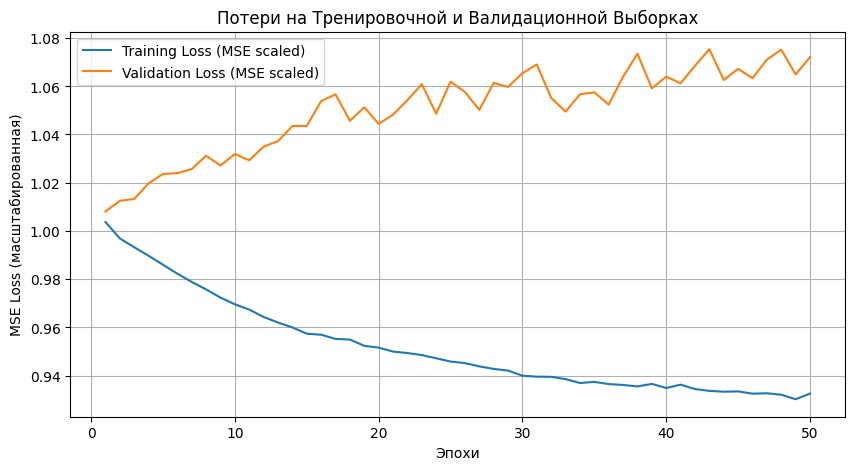

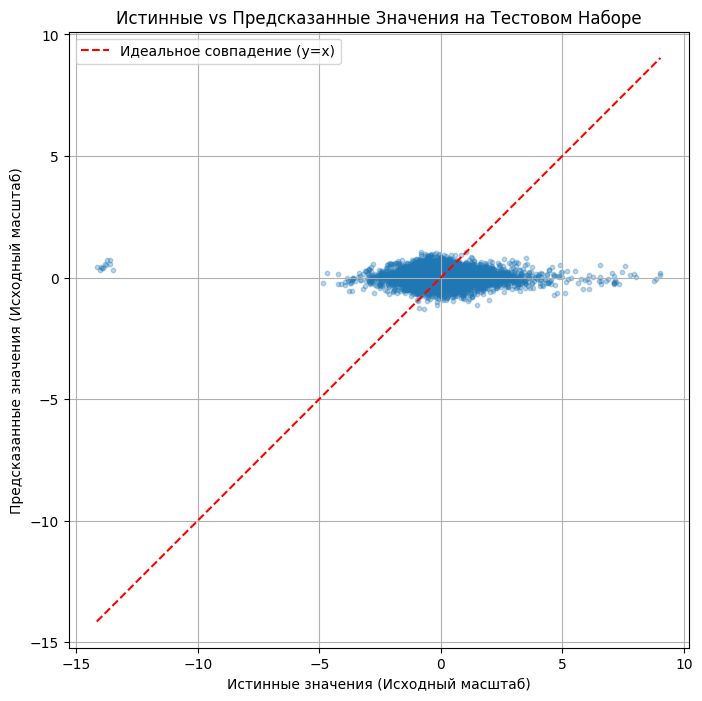


Скрипт завершен.


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import os

# --- Configuration ---
# Try to mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # Define base path (change if your file is elsewhere)
    # Example: '/content/drive/MyDrive/Colab Notebooks/data/'
    BASE_DRIVE_PATH = '/content/drive/MyDrive/'
    print("Google Drive смонтирован успешно.")
except ModuleNotFoundError:
    print("Запуск не в Google Colab или ошибка монтирования. Используется текущая директория.")
    BASE_DRIVE_PATH = './' # Use local directory if not in Colab

DATA_FILE_PATH = os.path.join(BASE_DRIVE_PATH, '0moex_qcml_final_dataset_with_embeddings.parquet') # <--- ИЗМЕНИТЕ НА ПУТЬ К ВАШЕМУ ФАЙЛУ
TARGET_COLUMN = 'FinalTarget'
DATE_COLUMN = 'TRADEDATE'

# Model Hyperparameters (Architecture from paper)
INPUT_DIM = -1 # Будет определено после загрузки данных
HIDDEN_DIM1 = 32
HIDDEN_DIM2 = 16
HIDDEN_DIM3 = 8
OUTPUT_DIM = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128 # Можно изменить (64, 256 и т.д.)
EPOCHS = 50 # Количество эпох обучения

# --- Phase 1: Setup & Data Loading ---

print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")

if not os.path.exists(DATA_FILE_PATH):
    print(f"ОШИБКА: Файл данных не найден по пути {DATA_FILE_PATH}")
    print("Пожалуйста, убедитесь, что файл существует и путь указан верно.")
    # Создаем dummy-данные для демонстрации, если файл не найден
    print("Создание dummy-данных для демонстрации...")
    num_samples = 10000
    num_features = 15 # Примерное количество признаков
    num_days = 100
    stocks_per_day = num_samples // num_days
    dummy_data = {
        DATE_COLUMN: np.repeat(pd.date_range('2010-01-01', periods=num_days, freq='B').astype(np.int64) // 10**9, stocks_per_day) * 1_000_000_000, # Nanoseconds
        TARGET_COLUMN: np.random.randn(num_samples),
    }
    for i in range(num_features):
        dummy_data[f'feature_{i+1}'] = np.random.randn(num_samples)
    df = pd.DataFrame(dummy_data)
    print("Dummy-данные созданы.")
else:
    try:
        df = pd.read_parquet(DATA_FILE_PATH)
        print("Данные успешно загружены.")
    except Exception as e:
        print(f"ОШИБКА: Не удалось загрузить Parquet файл: {e}")
        raise

# Verification
print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN]
missing_req = [col for col in required_cols if col not in df.columns]
if missing_req:
    print(f"ОШИБКА: Отсутствуют обязательные столбцы: {missing_req}")
    raise ValueError("Отсутствуют обязательные столбцы")
else:
    print(f"Обязательные столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")

# Automatically identify feature columns
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]]
if not feature_columns:
    print("ОШИБКА: Не найдено ни одного столбца с признаками (кроме даты и цели).")
    raise ValueError("Нет признаков для обучения")

INPUT_DIM = len(feature_columns) # Set NN input dimension
print(f"Найдено {INPUT_DIM} столбцов-признаков:")
print(feature_columns)


# --- Phase 2: Initial Time Sort & Data Splitting ---
print("\n--- Сортировка и разбиение данных ---")

# Ensure DATE_COLUMN is numeric (Unix timestamp) or convert if needed
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try:
        # Attempt conversion assuming it's a datetime string/object
        df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
        print(f"Столбец '{DATE_COLUMN}' конвертирован в числовой Unix timestamp (nanoseconds).")
    except Exception as e:
        print(f"ОШИБКА: Не удалось конвертировать '{DATE_COLUMN}' в числовой формат: {e}")
        raise

# Sort by date
df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True)
print(f"Данные отсортированы по '{DATE_COLUMN}'.")

# Time-based split (90% train, 10% test)
split_idx = int(len(df) * 0.9)
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

# Verify split
train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])

print(f"Тренировочные данные: {len(train_df)} семплов, с {train_start} по {train_end}")
print(f"Тестовые данные     : {len(test_df)} семплов, с {test_start} по {test_end}")
if train_end < test_start:
    print("Хронологическое разбиение успешно.")
else:
     print(f"ВНИМАНИЕ: Возможно перекрытие или ошибка в хронологическом разбиении. Конец трейна: {train_end}, Начало теста: {test_start}")


# --- Phase 3: Preprocessing (Scaling) ---
print("\n--- Предобработка (Масштабирование) ---")

# Separate features and target
X_train = train_df[feature_columns]
y_train = train_df[[TARGET_COLUMN]] # Keep as DataFrame for scaler
X_test = test_df[feature_columns]
y_test = test_df[[TARGET_COLUMN]] # Keep as DataFrame for scaler

# Initialize scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Fit scalers ONLY on training data
print("Обучение масштабировщиков на тренировочных данных...")
X_train_scaled = feature_scaler.fit_transform(X_train)
y_train_scaled = target_scaler.fit_transform(y_train)
print("Масштабировщики обучены.")

# Apply fitted scalers to test data
print("Применение масштабировщиков к тестовым данным...")
X_test_scaled = feature_scaler.transform(X_test)
y_test_scaled = target_scaler.transform(y_test)
print("Данные масштабированы.")


# --- Phase 4: Model Definition & Training ---
print("\n--- Определение и Обучение Модели ---")

# Convert data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32) # Target shape (N, 1) already
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32) # Target shape (N, 1) already

# Create Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # Shuffle training data
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) # No shuffle for test


# Define the Neural Network (Architecture from paper Section 4.3)
class ClassicalNN(nn.Module):
    def __init__(self, input_dim, h1, h2, h3, output_dim):
        super(ClassicalNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(h2, h3)
        self.bn3 = nn.BatchNorm1d(h3)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(h3, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        # BatchNorm needs N, C shape. If batch size is 1 during eval/inference, it can fail.
        # Handle this by checking batch size. For training with batch_size > 1, it's fine.
        if x.shape[0] > 1:
           x = self.bn1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        if x.shape[0] > 1:
            x = self.bn2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        if x.shape[0] > 1:
            x = self.bn3(x)
        x = self.relu3(x)
        x = self.output_layer(x)
        return x

# Instantiate model, define loss and optimizer


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

model = ClassicalNN(INPUT_DIM, HIDDEN_DIM1, HIDDEN_DIM2, HIDDEN_DIM3, OUTPUT_DIM).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training Loop
train_losses = []
val_losses = []
start_time = time.time()

print("Начало обучения...")
for epoch in range(EPOCHS):
    model.train() # Установить модель в режим обучения
    epoch_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Обнулить градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * inputs.size(0)

    # Средняя ошибка на тренировочной выборке за эпоху
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Фаза валидации
    model.eval() # Установить модель в режим оценки
    epoch_val_loss = 0.0
    with torch.no_grad(): # Отключить вычисление градиентов
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * inputs.size(0)

    # Средняя ошибка на валидационной (тестовой) выборке за эпоху
    avg_val_loss = epoch_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"Эпоха [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд.")

# --- Phase 5: Prediction & Final Evaluation ---
print("\n--- Предсказание и Финальная Оценка ---")

# Генерация предсказаний на тестовом наборе
model.eval()
predictions_scaled_list = []
with torch.no_grad():
    for inputs, _ in test_loader: # Цели здесь не нужны
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions_scaled_list.append(outputs.cpu().numpy())

# Объединение предсказаний
predictions_scaled = np.concatenate(predictions_scaled_list, axis=0)

# Важно: Обратное масштабирование предсказаний и истинных значений для оценки в исходном масштабе
predictions_original_scale = target_scaler.inverse_transform(predictions_scaled)
y_test_original_scale = target_scaler.inverse_transform(y_test_scaled) # Используем масштабированные y_test

# Оценка модели
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale)
final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
final_r2 = r2_score(y_test_original_scale, predictions_original_scale)

print("\n--- Финальные Метрики (в исходном масштабе цели) ---")
print(f"Тестовый набор MSE: {final_mse:.6f}")
print(f"Тестовый набор MAE: {final_mae:.6f}")
print(f"Тестовый набор R^2: {final_r2:.4f}")

# --- Phase 6: Visualization ---
print("\n--- Построение Графиков ---")

# 1. Кривая обучения (Потери)
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss (MSE scaled)')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss (MSE scaled)')
plt.xlabel('Эпохи')
plt.ylabel('MSE Loss (масштабированная)')
plt.title('Потери на Тренировочной и Валидационной Выборках')
plt.legend()
plt.grid(True)
plt.show()

# 2. График "Истинные vs Предсказанные значения" (в исходном масштабе)
plt.figure(figsize=(8, 8))
plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10)
plt.xlabel('Истинные значения (Исходный масштаб)')
plt.ylabel('Предсказанные значения (Исходный масштаб)')
plt.title('Истинные vs Предсказанные Значения на Тестовом Наборе')
# Линия идеального совпадения y=x
min_val = min(y_test_original_scale.min(), predictions_original_scale.min())
max_val = max(y_test_original_scale.max(), predictions_original_scale.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное совпадение (y=x)')
plt.legend()
plt.grid(True)
plt.axis('equal') # Равный масштаб осей
plt.show()

print("\nСкрипт завершен.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive смонтирован успешно.
Попытка загрузить данные из: /content/drive/MyDrive/0moex_qcml_final_dataset_with_embeddings.parquet
Данные успешно загружены.

--- Проверка данных ---
Обязательные столбцы 'TRADEDATE' и 'FinalTarget' найдены.
Найдено 18 столбцов-признаков:

--- Сортировка и разбиение данных ---
Столбец 'TRADEDATE' конвертирован в числовой Unix timestamp (nanoseconds).
Данные отсортированы по 'TRADEDATE'.
Тренировочные данные: 150827 семплов, с 2021-04-20 00:00:00 по 2024-11-18 00:00:00
Тестовые данные     : 16759 семплов, с 2024-11-18 00:00:00 по 2025-03-27 00:00:00
ВНИМАНИЕ: Возможно перекрытие или ошибка в хронологическом разбиении. Конец трейна: 2024-11-18 00:00:00, Начало теста: 2024-11-18 00:00:00

--- Предобработка (Масштабирование) ---
Обучение масштабировщиков на тренировочных данных...
Масштабировщики обучены.
Применение масштабиров

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Эпоха [1/50], Train Loss: 1.004296, Val Loss: 1.010849
Эпоха [2/50], Train Loss: 0.993770, Val Loss: 1.014805
Эпоха [3/50], Train Loss: 0.988174, Val Loss: 1.018280
Эпоха [4/50], Train Loss: 0.981307, Val Loss: 1.029119
Эпоха [5/50], Train Loss: 0.973740, Val Loss: 1.041847
Эпоха [6/50], Train Loss: 0.964735, Val Loss: 1.071592
Эпоха [7/50], Train Loss: 0.955551, Val Loss: 1.062736
Эпоха [8/50], Train Loss: 0.939328, Val Loss: 1.064172
Эпоха [9/50], Train Loss: 0.934430, Val Loss: 1.080010
Эпоха [10/50], Train Loss: 0.931069, Val Loss: 1.083484
Эпоха [11/50], Train Loss: 0.929930, Val Loss: 1.083551
Эпоха [12/50], Train Loss: 0.927637, Val Loss: 1.090571
Эпоха [13/50], Train Loss: 0.925915, Val Loss: 1.094516
Эпоха [14/50], Train Loss: 0.922894, Val Loss: 1.094963
Эпоха [15/50], Train Loss: 0.922633, Val Loss: 1.093584
Эпоха [16/50], Train Loss: 0.923225, Val Loss: 1.094306
Эпоха [17/50], Train Loss: 0.922607, Val Loss: 1.090757
Эпоха [18/50], Train Loss: 0.922629, Val Loss: 1.085910
Э

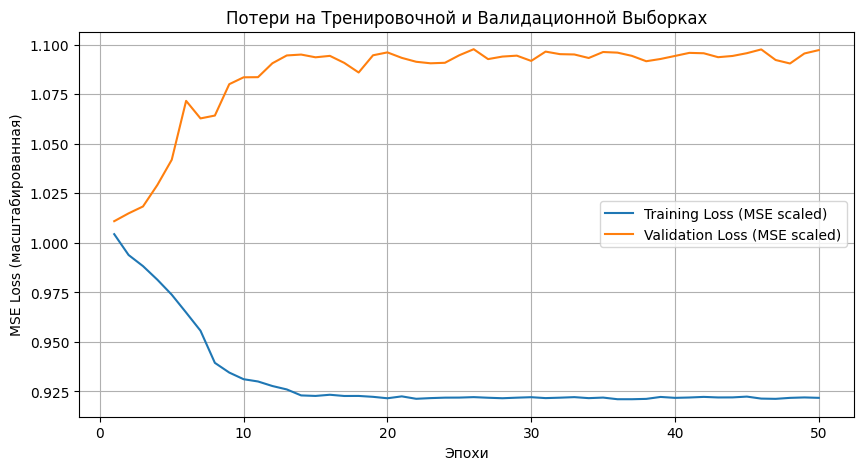

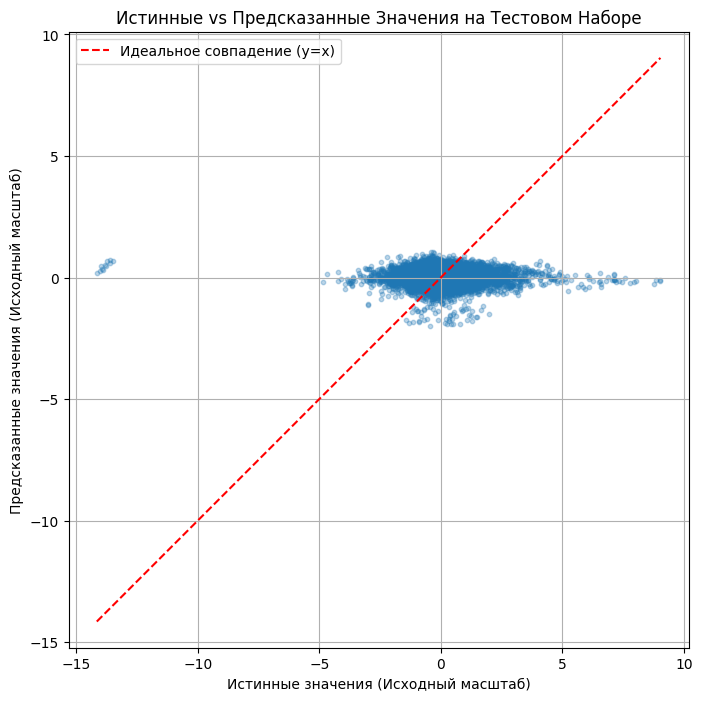


Скрипт завершен.


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# Добавляем импорт планировщика
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import os

# --- Configuration ---
# Try to mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # Define base path (change if your file is elsewhere)
    # Example: '/content/drive/MyDrive/Colab Notebooks/data/'
    BASE_DRIVE_PATH = '/content/drive/MyDrive/'
    print("Google Drive смонтирован успешно.")
except ModuleNotFoundError:
    print("Запуск не в Google Colab или ошибка монтирования. Используется текущая директория.")
    BASE_DRIVE_PATH = './' # Use local directory if not in Colab

# Используем имя файла из вашего предыдущего кода
DATA_FILE_PATH = os.path.join(BASE_DRIVE_PATH, '0moex_qcml_final_dataset_with_embeddings.parquet')
# Используем имя целевой переменной из вашего предыдущего кода
TARGET_COLUMN = 'FinalTarget'
DATE_COLUMN = 'TRADEDATE'

# Model Hyperparameters (Architecture from paper, but wider)
INPUT_DIM = -1 # Будет определено после загрузки данных
# Увеличиваем количество нейронов
HIDDEN_DIM1 = 64 # Было 32
HIDDEN_DIM2 = 32 # Было 16
HIDDEN_DIM3 = 16 # Было 8
OUTPUT_DIM = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128 # Можно изменить (64, 256 и т.д.)
EPOCHS = 50 # Количество эпох обучения

# --- Phase 1: Setup & Data Loading ---

print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")

if not os.path.exists(DATA_FILE_PATH):
    print(f"ОШИБКА: Файл данных не найден по пути {DATA_FILE_PATH}")
    print("Пожалуйста, убедитесь, что файл существует и путь указан верно.")
    # Создаем dummy-данные для демонстрации, если файл не найден
    print("Создание dummy-данных для демонстрации...")
    num_samples = 10000
    num_features = 15 # Примерное количество признаков
    num_days = 100
    stocks_per_day = num_samples // num_days
    dummy_data = {
        DATE_COLUMN: np.repeat(pd.date_range('2010-01-01', periods=num_days, freq='B').astype(np.int64) // 10**9, stocks_per_day) * 1_000_000_000, # Nanoseconds
        TARGET_COLUMN: np.random.randn(num_samples),
    }
    for i in range(num_features):
        dummy_data[f'feature_{i+1}'] = np.random.randn(num_samples)
    df = pd.DataFrame(dummy_data)
    print("Dummy-данные созданы.")
else:
    try:
        df = pd.read_parquet(DATA_FILE_PATH)
        print("Данные успешно загружены.")
    except Exception as e:
        print(f"ОШИБКА: Не удалось загрузить Parquet файл: {e}")
        raise

# Verification
print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN]
missing_req = [col for col in required_cols if col not in df.columns]
if missing_req:
    print(f"ОШИБКА: Отсутствуют обязательные столбцы: {missing_req}")
    raise ValueError("Отсутствуют обязательные столбцы")
else:
    print(f"Обязательные столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")

# Automatically identify feature columns
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]]
if not feature_columns:
    print("ОШИБКА: Не найдено ни одного столбца с признаками (кроме даты и цели).")
    raise ValueError("Нет признаков для обучения")

INPUT_DIM = len(feature_columns) # Set NN input dimension
print(f"Найдено {INPUT_DIM} столбцов-признаков:")
# Раскомментируйте, если нужно увидеть все имена признаков
# print(feature_columns)


# --- Phase 2: Initial Time Sort & Data Splitting ---
print("\n--- Сортировка и разбиение данных ---")

# Ensure DATE_COLUMN is numeric (Unix timestamp) or convert if needed
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try:
        # Attempt conversion assuming it's a datetime string/object
        df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
        print(f"Столбец '{DATE_COLUMN}' конвертирован в числовой Unix timestamp (nanoseconds).")
    except Exception as e:
        print(f"ОШИБКА: Не удалось конвертировать '{DATE_COLUMN}' в числовой формат: {e}")
        raise

# Sort by date
df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True)
print(f"Данные отсортированы по '{DATE_COLUMN}'.")

# Time-based split (90% train, 10% test)
split_idx = int(len(df) * 0.9)
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

# Verify split
train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])

print(f"Тренировочные данные: {len(train_df)} семплов, с {train_start} по {train_end}")
print(f"Тестовые данные     : {len(test_df)} семплов, с {test_start} по {test_end}")
if train_end < test_start:
    print("Хронологическое разбиение успешно.")
else:
     print(f"ВНИМАНИЕ: Возможно перекрытие или ошибка в хронологическом разбиении. Конец трейна: {train_end}, Начало теста: {test_start}")


# --- Phase 3: Preprocessing (Scaling) ---
print("\n--- Предобработка (Масштабирование) ---")

# Separate features and target
X_train = train_df[feature_columns]
y_train = train_df[[TARGET_COLUMN]] # Keep as DataFrame for scaler
X_test = test_df[feature_columns]
y_test = test_df[[TARGET_COLUMN]] # Keep as DataFrame for scaler

# Initialize scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Fit scalers ONLY on training data
print("Обучение масштабировщиков на тренировочных данных...")
X_train_scaled = feature_scaler.fit_transform(X_train)
y_train_scaled = target_scaler.fit_transform(y_train)
print("Масштабировщики обучены.")

# Apply fitted scalers to test data
print("Применение масштабировщиков к тестовым данным...")
X_test_scaled = feature_scaler.transform(X_test)
y_test_scaled = target_scaler.transform(y_test)
print("Данные масштабированы.")


# --- Phase 4: Model Definition & Training ---
print("\n--- Определение и Обучение Модели ---")

# Convert data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32) # Target shape (N, 1) already
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32) # Target shape (N, 1) already

# Create Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # Shuffle training data
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) # No shuffle for test


# Define the Neural Network (Architecture from paper, but wider)
class ClassicalNN(nn.Module):
    def __init__(self, input_dim, h1, h2, h3, output_dim):
        super(ClassicalNN, self).__init__()
        # Используем обновленные h1, h2, h3 из конфигурации
        self.layer1 = nn.Linear(input_dim, h1) # input -> h1 (64)
        self.bn1 = nn.BatchNorm1d(h1)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(h1, h2)        # h1 (64) -> h2 (32)
        self.bn2 = nn.BatchNorm1d(h2)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(h2, h3)        # h2 (32) -> h3 (16)
        self.bn3 = nn.BatchNorm1d(h3)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(h3, output_dim) # h3 (16) -> output (1)

    def forward(self, x):
        x = self.layer1(x)
        # BatchNorm needs N, C shape. If batch size is 1 during eval/inference, it can fail.
        # Handle this by checking batch size. For training with batch_size > 1, it's fine.
        if x.shape[0] > 1:
           x = self.bn1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        if x.shape[0] > 1:
            x = self.bn2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        if x.shape[0] > 1:
            x = self.bn3(x)
        x = self.relu3(x)
        x = self.output_layer(x)
        return x

# Instantiate model, define loss and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Создаем экземпляр усложненной модели
model = ClassicalNN(INPUT_DIM, HIDDEN_DIM1, HIDDEN_DIM2, HIDDEN_DIM3, OUTPUT_DIM).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Создаем планировщик learning rate
scheduler = ReduceLROnPlateau(optimizer,
                              mode='min',      # Снижать LR, когда метрика перестает уменьшаться
                              factor=0.1,      # Умножать LR на 0.1 (делить на 10)
                              patience=5,      # Количество эпох без улучшения перед снижением LR
                              threshold=0.001, # Порог для измерения значимого изменения
                              verbose=True)    # Выводить сообщение при снижении LR

# Training Loop
train_losses = []
val_losses = []
start_time = time.time()

print("Начало обучения...")
for epoch in range(EPOCHS):
    model.train() # Установить модель в режим обучения
    epoch_train_loss = 0.0
    for inputs, targets in train_loader:
        # Перемещаем данные на выбранное устройство
        inputs, targets = inputs.to(device), targets.to(device)

        # Обнулить градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * inputs.size(0)

    # Средняя ошибка на тренировочной выборке за эпоху
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Фаза валидации
    model.eval() # Установить модель в режим оценки
    epoch_val_loss = 0.0
    with torch.no_grad(): # Отключить вычисление градиентов
        for inputs, targets in test_loader:
            # Перемещаем данные на выбранное устройство
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * inputs.size(0)

    # Средняя ошибка на валидационной (тестовой) выборке за эпоху
    avg_val_loss = epoch_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f"Эпоха [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

    # Шаг планировщика после валидации
    scheduler.step(avg_val_loss) # Передаем метрику для отслеживания

training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд.")

# --- Phase 5: Prediction & Final Evaluation ---
print("\n--- Предсказание и Финальная Оценка ---")

# Генерация предсказаний на тестовом наборе
model.eval()
predictions_scaled_list = []
with torch.no_grad():
    for inputs, _ in test_loader: # Цели здесь не нужны
        # Перемещаем данные на выбранное устройство
        inputs = inputs.to(device)
        outputs = model(inputs)
        # Перемещаем результаты на CPU перед конвертацией в numpy
        predictions_scaled_list.append(outputs.cpu().numpy())

# Объединение предсказаний
predictions_scaled = np.concatenate(predictions_scaled_list, axis=0)

# Важно: Обратное масштабирование предсказаний и истинных значений для оценки в исходном масштабе
predictions_original_scale = target_scaler.inverse_transform(predictions_scaled)
y_test_original_scale = target_scaler.inverse_transform(y_test_scaled) # Используем масштабированные y_test

# Оценка модели
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale)
final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
final_r2 = r2_score(y_test_original_scale, predictions_original_scale)

print("\n--- Финальные Метрики (в исходном масштабе цели) ---")
print(f"Тестовый набор MSE: {final_mse:.6f}")
print(f"Тестовый набор MAE: {final_mae:.6f}")
print(f"Тестовый набор R^2: {final_r2:.4f}")

# --- Phase 6: Visualization ---
print("\n--- Построение Графиков ---")

# 1. Кривая обучения (Потери)
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss (MSE scaled)')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss (MSE scaled)')
plt.xlabel('Эпохи')
plt.ylabel('MSE Loss (масштабированная)')
plt.title('Потери на Тренировочной и Валидационной Выборках')
plt.legend()
plt.grid(True)
plt.show()

# 2. График "Истинные vs Предсказанные значения" (в исходном масштабе)
plt.figure(figsize=(8, 8))
plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10)
plt.xlabel('Истинные значения (Исходный масштаб)')
plt.ylabel('Предсказанные значения (Исходный масштаб)')
plt.title('Истинные vs Предсказанные Значения на Тестовом Наборе')
# Линия идеального совпадения y=x
min_val = min(y_test_original_scale.min(), predictions_original_scale.min())
max_val = max(y_test_original_scale.max(), predictions_original_scale.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное совпадение (y=x)')
plt.legend()
plt.grid(True)
plt.axis('equal') # Равный масштаб осей
plt.show()

print("\nСкрипт завершен.")

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# Добавляем импорт планировщика
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import os

# --- Configuration ---
# Try to mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # Define base path (change if your file is elsewhere)
    # Example: '/content/drive/MyDrive/Colab Notebooks/data/'
    BASE_DRIVE_PATH = '/content/drive/MyDrive/'
    print("Google Drive смонтирован успешно.")
except ModuleNotFoundError:
    print("Запуск не в Google Colab или ошибка монтирования. Используется текущая директория.")
    BASE_DRIVE_PATH = './' # Use local directory if not in Colab

# Используем имя файла из вашего предыдущего кода
DATA_FILE_PATH = os.path.join(BASE_DRIVE_PATH, '0moex_qcml_final_dataset_with_embeddings.parquet')
# Используем имя целевой переменной из вашего предыдущего кода
TARGET_COLUMN = 'FinalTarget'
DATE_COLUMN = 'TRADEDATE'

# Model Hyperparameters (Deeper and Wider)
INPUT_DIM = -1 # Будет определено после загрузки данных
# Увеличиваем ширину и добавляем слой
HIDDEN_DIM1 = 128 # Было 64
HIDDEN_DIM2 = 64  # Было 32
HIDDEN_DIM3 = 64  # Было 16
HIDDEN_DIM4 = 32  # Новый слой
OUTPUT_DIM = 1
LEARNING_RATE = 0.02 # Оставляем пока 0.001
BATCH_SIZE = 128
EPOCHS = 75 # Увеличиваем количество эпох

# --- Phase 1: Setup & Data Loading ---

print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")

if not os.path.exists(DATA_FILE_PATH):
    print(f"ОШИБКА: Файл данных не найден по пути {DATA_FILE_PATH}")
    print("Пожалуйста, убедитесь, что файл существует и путь указан верно.")
    # Создаем dummy-данные для демонстрации, если файл не найден
    print("Создание dummy-данных для демонстрации...")
    num_samples = 10000
    num_features = 15 # Примерное количество признаков
    num_days = 100
    stocks_per_day = num_samples // num_days
    dummy_data = {
        DATE_COLUMN: np.repeat(pd.date_range('2010-01-01', periods=num_days, freq='B').astype(np.int64) // 10**9, stocks_per_day) * 1_000_000_000, # Nanoseconds
        TARGET_COLUMN: np.random.randn(num_samples),
    }
    for i in range(num_features):
        dummy_data[f'feature_{i+1}'] = np.random.randn(num_samples)
    df = pd.DataFrame(dummy_data)
    print("Dummy-данные созданы.")
else:
    try:
        df = pd.read_parquet(DATA_FILE_PATH)
        print("Данные успешно загружены.")
    except Exception as e:
        print(f"ОШИБКА: Не удалось загрузить Parquet файл: {e}")
        raise

# Verification
print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN]
missing_req = [col for col in required_cols if col not in df.columns]
if missing_req:
    print(f"ОШИБКА: Отсутствуют обязательные столбцы: {missing_req}")
    raise ValueError("Отсутствуют обязательные столбцы")
else:
    print(f"Обязательные столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")

# Automatically identify feature columns
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]]
if not feature_columns:
    print("ОШИБКА: Не найдено ни одного столбца с признаками (кроме даты и цели).")
    raise ValueError("Нет признаков для обучения")

INPUT_DIM = len(feature_columns) # Set NN input dimension
print(f"Найдено {INPUT_DIM} столбцов-признаков:")
# print(feature_columns)


# --- Phase 2: Initial Time Sort & Data Splitting ---
print("\n--- Сортировка и разбиение данных ---")

# Ensure DATE_COLUMN is numeric (Unix timestamp) or convert if needed
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try:
        # Attempt conversion assuming it's a datetime string/object
        df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
        print(f"Столбец '{DATE_COLUMN}' конвертирован в числовой Unix timestamp (nanoseconds).")
    except Exception as e:
        print(f"ОШИБКА: Не удалось конвертировать '{DATE_COLUMN}' в числовой формат: {e}")
        raise

# Sort by date
df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True)
print(f"Данные отсортированы по '{DATE_COLUMN}'.")

# Time-based split (90% train, 10% test)
split_idx = int(len(df) * 0.9)
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

# Verify split
train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])

print(f"Тренировочные данные: {len(train_df)} семплов, с {train_start} по {train_end}")
print(f"Тестовые данные     : {len(test_df)} семплов, с {test_start} по {test_end}")
if train_end < test_start:
    print("Хронологическое разбиение успешно.")
else:
     print(f"ВНИМАНИЕ: Возможно перекрытие или ошибка в хронологическом разбиении. Конец трейна: {train_end}, Начало теста: {test_start}")


# --- Phase 3: Preprocessing (Scaling) ---
print("\n--- Предобработка (Масштабирование) ---")

# Separate features and target
X_train = train_df[feature_columns]
y_train = train_df[[TARGET_COLUMN]] # Keep as DataFrame for scaler
X_test = test_df[feature_columns]
y_test = test_df[[TARGET_COLUMN]] # Keep as DataFrame for scaler

# Initialize scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Fit scalers ONLY on training data
print("Обучение масштабировщиков на тренировочных данных...")
X_train_scaled = feature_scaler.fit_transform(X_train)
y_train_scaled = target_scaler.fit_transform(y_train)
print("Масштабировщики обучены.")

# Apply fitted scalers to test data
print("Применение масштабировщиков к тестовым данным...")
X_test_scaled = feature_scaler.transform(X_test)
y_test_scaled = target_scaler.transform(y_test)
print("Данные масштабированы.")


# --- Phase 4: Model Definition & Training ---
print("\n--- Определение и Обучение Модели ---")

# Convert data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32) # Target shape (N, 1) already
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32) # Target shape (N, 1) already

# Create Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # Shuffle training data
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) # No shuffle for test


# Define the Deeper and Wider Neural Network
class ClassicalNN(nn.Module):
    # Добавляем h4 в параметры конструктора
    def __init__(self, input_dim, h1, h2, h3, h4, output_dim):
        super(ClassicalNN, self).__init__()
        # Используем обновленные h1, h2, h3, h4 из конфигурации
        self.layer1 = nn.Linear(input_dim, h1) # input -> h1 (128)
        self.bn1 = nn.BatchNorm1d(h1)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(h1, h2)        # h1 (128) -> h2 (64)
        self.bn2 = nn.BatchNorm1d(h2)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(h2, h3)        # h2 (64) -> h3 (32)
        self.bn3 = nn.BatchNorm1d(h3)
        self.relu3 = nn.ReLU()
        # Добавляем 4-й слой
        self.layer4 = nn.Linear(h3, h4)        # h3 (32) -> h4 (16)
        self.bn4 = nn.BatchNorm1d(h4)
        self.relu4 = nn.ReLU()
        # Выходной слой теперь принимает h4
        self.output_layer = nn.Linear(h4, output_dim) # h4 (16) -> output (1)

    def forward(self, x):
        x = self.layer1(x)
        if x.shape[0] > 1: x = self.bn1(x)
        x = self.relu1(x)

        x = self.layer2(x)
        if x.shape[0] > 1: x = self.bn2(x)
        x = self.relu2(x)

        x = self.layer3(x)
        if x.shape[0] > 1: x = self.bn3(x)
        x = self.relu3(x)

        # Добавляем проход через 4-й слой
        x = self.layer4(x)
        if x.shape[0] > 1: x = self.bn4(x)
        x = self.relu4(x)

        x = self.output_layer(x)
        return x

# Instantiate model, define loss and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Создаем экземпляр новой, более глубокой и широкой модели
model = ClassicalNN(INPUT_DIM, HIDDEN_DIM1, HIDDEN_DIM2, HIDDEN_DIM3, HIDDEN_DIM4, OUTPUT_DIM).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Создаем планировщик learning rate с увеличенным терпением
scheduler = ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor=0.1,
                              patience=40,      # Увеличено с 5 до 7
                              threshold=0.001,
                              verbose=True)

# Training Loop
train_losses = []
val_losses = []
start_time = time.time()

print("Начало обучения...")
for epoch in range(EPOCHS): # Увеличено количество эпох
    model.train() # Установить модель в режим обучения
    epoch_train_loss = 0.0
    for inputs, targets in train_loader:
        # Перемещаем данные на выбранное устройство
        inputs, targets = inputs.to(device), targets.to(device)

        # Обнулить градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Обратный проход и оптимизация
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * inputs.size(0)

    # Средняя ошибка на тренировочной выборке за эпоху
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Фаза валидации
    model.eval() # Установить модель в режим оценки
    epoch_val_loss = 0.0
    with torch.no_grad(): # Отключить вычисление градиентов
        for inputs, targets in test_loader:
            # Перемещаем данные на выбранное устройство
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * inputs.size(0)

    # Средняя ошибка на валидационной (тестовой) выборке за эпоху
    avg_val_loss = epoch_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    # Получаем текущий learning rate для вывода
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Эпоха [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.7f}")

    # Шаг планировщика после валидации
    scheduler.step(avg_val_loss) # Передаем метрику для отслеживания

training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд.")

# --- Phase 5: Prediction & Final Evaluation ---
print("\n--- Предсказание и Финальная Оценка ---")

# Генерация предсказаний на тестовом наборе
model.eval()
predictions_scaled_list = []
with torch.no_grad():
    for inputs, _ in test_loader: # Цели здесь не нужны
        # Перемещаем данные на выбранное устройство
        inputs = inputs.to(device)
        outputs = model(inputs)
        # Перемещаем результаты на CPU перед конвертацией в numpy
        predictions_scaled_list.append(outputs.cpu().numpy())

# Объединение предсказаний
predictions_scaled = np.concatenate(predictions_scaled_list, axis=0)

# Важно: Обратное масштабирование предсказаний и истинных значений для оценки в исходном масштабе
predictions_original_scale = target_scaler.inverse_transform(predictions_scaled)
y_test_original_scale = target_scaler.inverse_transform(y_test_scaled) # Используем масштабированные y_test

# Оценка модели
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale)
final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
final_r2 = r2_score(y_test_original_scale, predictions_original_scale)

print("\n--- Финальные Метрики (в исходном масштабе цели) ---")
print(f"Тестовый набор MSE: {final_mse:.6f}")
print(f"Тестовый набор MAE: {final_mae:.6f}")
print(f"Тестовый набор R^2: {final_r2:.4f}")

# --- Phase 6: Visualization ---
print("\n--- Построение Графиков ---")

# 1. Кривая обучения (Потери)
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss (MSE scaled)')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss (MSE scaled)')
plt.xlabel('Эпохи')
plt.ylabel('MSE Loss (масштабированная)')
plt.title('Потери на Тренировочной и Валидационной Выборках')
plt.legend()
plt.grid(True)
plt.show()

# 2. График "Истинные vs Предсказанные значения" (в исходном масштабе)
plt.figure(figsize=(8, 8))
plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10)
plt.xlabel('Истинные значения (Исходный масштаб)')
plt.ylabel('Предсказанные значения (Исходный масштаб)')
plt.title('Истинные vs Предсказанные Значения на Тестовом Наборе')
# Линия идеального совпадения y=x
min_val = min(y_test_original_scale.min(), predictions_original_scale.min())
max_val = max(y_test_original_scale.max(), predictions_original_scale.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное совпадение (y=x)')
plt.legend()
plt.grid(True)
plt.axis('equal') # Равный масштаб осей
plt.show()

print("\nСкрипт завершен.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive смонтирован успешно.
Попытка загрузить данные из: /content/drive/MyDrive/0moex_qcml_final_dataset_with_embeddings.parquet
Данные успешно загружены.

--- Проверка данных ---
Обязательные столбцы 'TRADEDATE' и 'FinalTarget' найдены.
Найдено 18 столбцов-признаков:

--- Сортировка и разбиение данных ---
Столбец 'TRADEDATE' конвертирован в числовой Unix timestamp (nanoseconds).
Данные отсортированы по 'TRADEDATE'.
Тренировочные данные: 150827 семплов, с 2021-04-20 00:00:00 по 2024-11-18 00:00:00
Тестовые данные     : 16759 семплов, с 2024-11-18 00:00:00 по 2025-03-27 00:00:00
ВНИМАНИЕ: Возможно перекрытие или ошибка в хронологическом разбиении. Конец трейна: 2024-11-18 00:00:00, Начало теста: 2024-11-18 00:00:00

--- Предобработка (Масштабирование) ---
Обучение масштабировщиков на тренировочных данных...
Масштабировщики обучены.
Применение масштабиров

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Эпоха [1/75], Train Loss: 1.002798, Val Loss: 1.006628, LR: 0.0200000
Эпоха [2/75], Train Loss: 1.000271, Val Loss: 1.014895, LR: 0.0200000
Эпоха [3/75], Train Loss: 0.999972, Val Loss: 1.009058, LR: 0.0200000
Эпоха [4/75], Train Loss: 0.998966, Val Loss: 1.018343, LR: 0.0200000
Эпоха [5/75], Train Loss: 0.997579, Val Loss: 1.013584, LR: 0.0200000
Эпоха [6/75], Train Loss: 0.996278, Val Loss: 1.015664, LR: 0.0200000
Эпоха [7/75], Train Loss: 0.993886, Val Loss: 1.018295, LR: 0.0200000
Эпоха [8/75], Train Loss: 0.990546, Val Loss: 1.016537, LR: 0.0200000
Эпоха [9/75], Train Loss: 0.986512, Val Loss: 1.022381, LR: 0.0200000
Эпоха [10/75], Train Loss: 0.983221, Val Loss: 1.019583, LR: 0.0200000
Эпоха [11/75], Train Loss: 0.979966, Val Loss: 1.021044, LR: 0.0200000
Эпоха [12/75], Train Loss: 0.975985, Val Loss: 1.038505, LR: 0.0200000
Эпоха [13/75], Train Loss: 0.972518, Val Loss: 1.029099, LR: 0.0200000
Эпоха [14/75], Train Loss: 0.968947, Val Loss: 1.025291, LR: 0.0200000
Эпоха [15/75], 

KeyboardInterrupt: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive смонтирован успешно.
Попытка загрузить данные из: /content/drive/MyDrive/0moex_qcml_final_dataset_with_embeddings.parquet
Данные успешно загружены.

--- Проверка данных ---
Столбцы 'TRADEDATE' и 'FinalTarget' найдены.
Найдено 18 столбцов-признаков.

--- Сортировка и разбиение данных ---
Данные отсортированы.
Тренировочные: 150851 (2021-04-20 00:00:00 - 2024-11-18 00:00:00)
Тестовые: 16735 (2024-11-25 00:00:00 - 2025-03-27 00:00:00)
Хронологическое разбиение успешно.

--- Предобработка (Масштабирование) ---
Обучение масштабировщиков...
Применение масштабировщиков...
Цель (трейн) после масштабирования: mean=0.0000, std=1.0000
Цель (тест) после масштабирования: mean=-0.0069, std=1.0036

--- Определение и Обучение Модели ---
Используемое устройство: cuda
Начало обучения ШИРОКОЙ модели с LR=0.004, Dropout P=0.0, Epochs=100 (без планировщика)...
Эпоха 

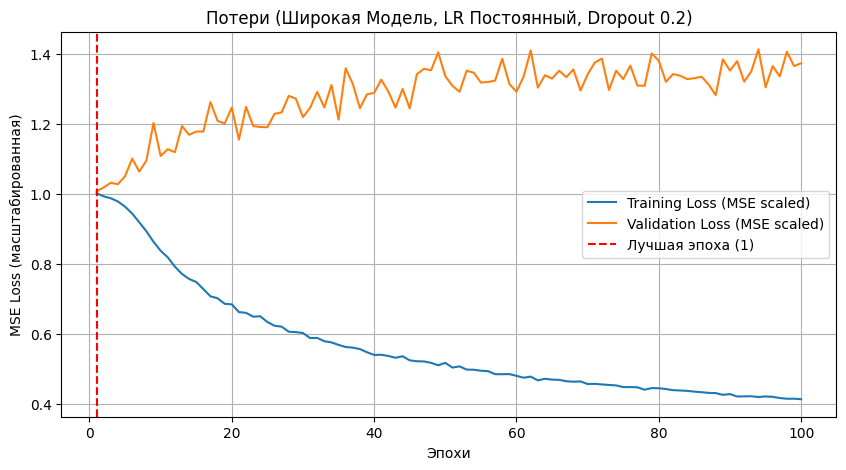

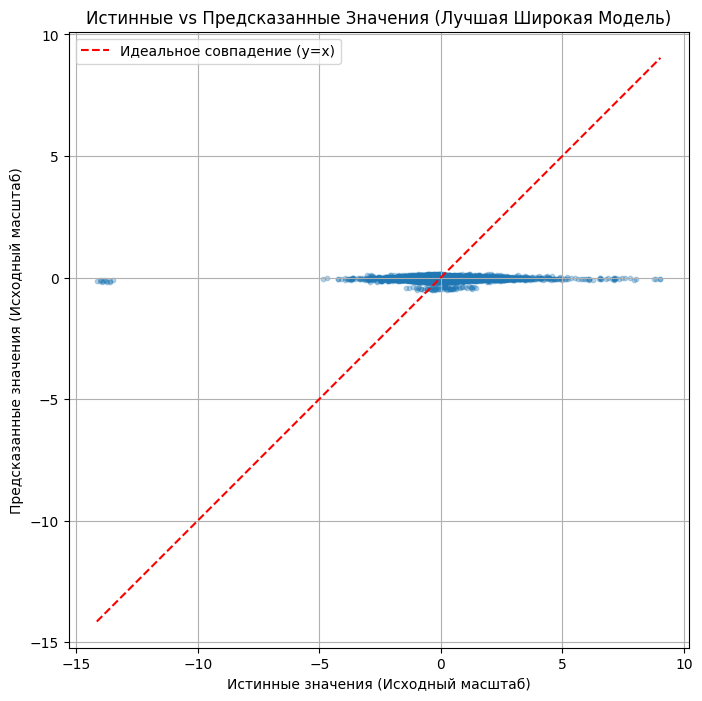


Скрипт завершен.


In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# Убран импорт ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import os

# --- Класс для Ранней Остановки ---
class EarlyStopping:
    """Останавливает обучение, если validation loss не улучшается после заданного patience.
       Сохраняет модель КАЖДЫЙ раз, когда val_loss улучшается."""
    def __init__(self, patience=25, verbose=False, path='checkpoint.pt', trace_func=print): # Убран delta из параметров
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        # self.delta больше не нужен
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss # Минимизируем loss, максимизируем score

        if self.best_score is None:
            # Первая эпоха или первое улучшение
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score > self.best_score: # Изменено условие: строгое улучшение (score > best_score)
            # Loss уменьшился - сохраняем модель и сбрасываем счетчик
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        else:
            # Улучшения нет или loss остался тем же
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        '''Сохраняет модель, если validation loss уменьшился.'''
        if self.verbose:
            # Скорректируем сообщение, т.к. delta больше нет
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# --- Configuration ---
try:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DRIVE_PATH = '/content/drive/MyDrive/'
    print("Google Drive смонтирован успешно.")
except ModuleNotFoundError:
    print("Запуск не в Google Colab или ошибка монтирования. Используется текущая директория.")
    BASE_DRIVE_PATH = './'

DATA_FILE_PATH = os.path.join(BASE_DRIVE_PATH, '0moex_qcml_final_dataset_with_embeddings.parquet')
TARGET_COLUMN = 'FinalTarget'
DATE_COLUMN = 'TRADEDATE'

# Model Hyperparameters (Значительно шире)
INPUT_DIM = -1
HIDDEN_DIM1 = 256 # Было 128
HIDDEN_DIM2 = 256 # Было 64
HIDDEN_DIM3 = 64  # Было 32
HIDDEN_DIM4 = 32  # Было 16
OUTPUT_DIM = 1
DROPOUT_PROB = 0.0  # Немного увеличиваем Dropout
LEARNING_RATE = 0.004 # Оставляем высокий LR
BATCH_SIZE = 128
EPOCHS = 100 # Увеличиваем эпохи

# Параметры Early Stopping
EARLY_STOPPING_PATIENCE = 200 # Увеличиваем терпение
CHECKPOINT_PATH = 'best_model_wider4L_highlr_dp02.pt' # Новое имя файла

# --- Phase 1, 2, 3 (Загрузка, разбиение, масштабирование - без изменений) ---
print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")
if not os.path.exists(DATA_FILE_PATH): print(f"ОШИБКА: Файл не найден {DATA_FILE_PATH}"); raise FileNotFoundError
else:
    try: df = pd.read_parquet(DATA_FILE_PATH); print("Данные успешно загружены.")
    except Exception as e: print(f"ОШИБКА: Не удалось загрузить Parquet: {e}"); raise

print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN]
if not all(col in df.columns for col in required_cols): print(f"ОШИБКА: Отсутствуют столбцы: {[c for c in required_cols if c not in df.columns]}"); raise ValueError
else: print(f"Столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]]
if not feature_columns: print("ОШИБКА: Нет признаков."); raise ValueError
INPUT_DIM = len(feature_columns); print(f"Найдено {INPUT_DIM} столбцов-признаков.")

print("\n--- Сортировка и разбиение данных ---")
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try: df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
    except Exception as e: print(f"ОШИБКА конвертации '{DATE_COLUMN}': {e}"); raise
df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True); print(f"Данные отсортированы.")
split_idx = int(len(df) * 0.9); last_train_date = df.loc[split_idx - 1, DATE_COLUMN]
actual_split_idx = (df[DATE_COLUMN] > last_train_date).idxmax()
if actual_split_idx == 0 and split_idx > 0 : actual_split_idx = split_idx
train_df = df.iloc[:actual_split_idx].copy(); test_df = df.iloc[actual_split_idx:].copy()
if train_df.empty or test_df.empty: print(f"ОШИБКА: Пустой датасет после разбиения! Индекс: {actual_split_idx}"); raise ValueError
train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])
print(f"Тренировочные: {len(train_df)} ({train_start} - {train_end})"); print(f"Тестовые: {len(test_df)} ({test_start} - {test_end})")
if train_end < test_start: print("Хронологическое разбиение успешно.")
elif train_end == test_start: print("ВНИМАНИЕ: Граница разбиения по одной дате.")
else: print(f"ОШИБКА: Перекрытие дат! {train_end} vs {test_start}")

print("\n--- Предобработка (Масштабирование) ---")
X_train = train_df[feature_columns]; y_train = train_df[[TARGET_COLUMN]]
X_test = test_df[feature_columns]; y_test = test_df[[TARGET_COLUMN]]
feature_scaler = StandardScaler(); target_scaler = StandardScaler()
print("Обучение масштабировщиков..."); X_train_scaled = feature_scaler.fit_transform(X_train); y_train_scaled = target_scaler.fit_transform(y_train)
print("Применение масштабировщиков..."); X_test_scaled = feature_scaler.transform(X_test); y_test_scaled = target_scaler.transform(y_test)
print(f"Цель (трейн) после масштабирования: mean={np.mean(y_train_scaled):.4f}, std={np.std(y_train_scaled):.4f}")
print(f"Цель (тест) после масштабирования: mean={np.mean(y_test_scaled):.4f}, std={np.std(y_test_scaled):.4f}")


# --- Phase 4: Model Definition & Training (Значительно шире, Dropout 0.2, без LR Scheduler) ---
print("\n--- Определение и Обучение Модели ---")

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32); y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32); y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor); test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True); test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Модель с 4 слоями и Dropout
class ClassicalNN(nn.Module):
    # Убран dropout_p из параметров __init__ и из слоев Dropout
    def __init__(self, input_dim, h1, h2, h3, h4, output_dim):
        super(ClassicalNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, h1); self.bn1 = nn.BatchNorm1d(h1); self.relu1 = nn.ReLU() # No Dropout
        self.layer2 = nn.Linear(h1, h2);        self.bn2 = nn.BatchNorm1d(h2); self.relu2 = nn.ReLU() # No Dropout
        self.layer3 = nn.Linear(h2, h3);        self.bn3 = nn.BatchNorm1d(h3); self.relu3 = nn.ReLU() # No Dropout
        self.layer4 = nn.Linear(h3, h4);        self.bn4 = nn.BatchNorm1d(h4); self.relu4 = nn.ReLU() # No Dropout
        self.output_layer = nn.Linear(h4, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        if x.shape[0] > 1: x = self.bn1(x)
        x = self.relu1(x) # No Dropout

        x = self.layer2(x)
        if x.shape[0] > 1: x = self.bn2(x)
        x = self.relu2(x) # No Dropout

        x = self.layer3(x)
        if x.shape[0] > 1: x = self.bn3(x)
        x = self.relu3(x) # No Dropout

        x = self.layer4(x)
        if x.shape[0] > 1: x = self.bn4(x)
        x = self.relu4(x) # No Dropout

        x = self.output_layer(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Создаем экземпляр широкой модели
model = ClassicalNN(INPUT_DIM, HIDDEN_DIM1, HIDDEN_DIM2, HIDDEN_DIM3, HIDDEN_DIM4, OUTPUT_DIM).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # LR=0.005

# Планировщик УБРАН

# Инициализируем Early Stopping с увеличенным терпением
early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, verbose=True, path=CHECKPOINT_PATH) # patience=25
# Training Loop
train_losses = []; val_losses = []
start_time = time.time()
print(f"Начало обучения ШИРОКОЙ модели с LR={LEARNING_RATE}, Dropout P={DROPOUT_PROB}, Epochs={EPOCHS} (без планировщика)...")

for epoch in range(EPOCHS): # EPOCHS = 175
    model.train() # Включаем Dropout
    epoch_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Фаза валидации
    model.eval() # Выключаем Dropout
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * inputs.size(0)
    avg_val_loss = epoch_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Эпоха [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.7f}")

    # Планировщик УБРАН

    # Проверка Early Stopping
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print("Ранняя остановка.")
        break

training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд.")

# Загрузка лучшей модели, сохраненной Early Stopping
print(f"Загрузка лучшей модели из {CHECKPOINT_PATH}")
try:
    model.load_state_dict(torch.load(CHECKPOINT_PATH))
    print("Лучшая модель успешно загружена.")
except FileNotFoundError:
    print(f"Ошибка: Файл чекпоинта {CHECKPOINT_PATH} не найден. Используется последняя модель.")
except Exception as e:
     print(f"Ошибка при загрузке чекпоинта: {e}. Используется последняя модель.")

# --- Phase 5: Prediction & Final Evaluation ---
print("\n--- Предсказание и Финальная Оценка (с лучшей моделью) ---")
model.eval(); predictions_scaled_list = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device); outputs = model(inputs)
        predictions_scaled_list.append(outputs.cpu().numpy())
predictions_scaled = np.concatenate(predictions_scaled_list, axis=0)
predictions_original_scale = target_scaler.inverse_transform(predictions_scaled)
y_test_original_scale = target_scaler.inverse_transform(y_test_scaled)
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale)
final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
final_r2 = r2_score(y_test_original_scale, predictions_original_scale)
print("\n--- Финальные Метрики (в исходном масштабе цели) ---")
print(f"Тестовый набор MSE: {final_mse:.6f}"); print(f"Тестовый набор MAE: {final_mae:.6f}"); print(f"Тестовый набор R^2: {final_r2:.4f}")

# --- Phase 6: Visualization ---
print("\n--- Построение Графиков ---")
epochs_ran = len(train_losses)
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs_ran + 1), train_losses, label='Training Loss (MSE scaled)')
plt.plot(range(1, epochs_ran + 1), val_losses, label='Validation Loss (MSE scaled)')
best_epoch = np.argmin(val_losses) + 1
plt.axvline(best_epoch, linestyle='--', color='r', label=f'Лучшая эпоха ({best_epoch})')
plt.xlabel('Эпохи'); plt.ylabel('MSE Loss (масштабированная)'); plt.title('Потери (Широкая Модель, LR Постоянный, Dropout 0.2)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10)
plt.xlabel('Истинные значения (Исходный масштаб)'); plt.ylabel('Предсказанные значения (Исходный масштаб)')
plt.title('Истинные vs Предсказанные Значения (Лучшая Широкая Модель)')
min_val = min(y_test_original_scale.min(), predictions_original_scale.min()); max_val = max(y_test_original_scale.max(), predictions_original_scale.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Идеальное совпадение (y=x)')
plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()

print("\nСкрипт завершен.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive смонтирован успешно.
Попытка загрузить данные из: /content/drive/MyDrive/0moex_qcml_final_dataset_with_embeddings.parquet
Данные успешно загружены.

--- Проверка данных ---
Обязательные столбцы 'TRADEDATE' и 'FinalTarget' найдены.
Найдено 18 столбцов-признаков.

--- Сортировка и разбиение данных ---
Столбец 'TRADEDATE' конвертирован в числовой Unix timestamp (nanoseconds).
Данные отсортированы по 'TRADEDATE'.
Тренировочные данные: 150851 семплов, с 2021-04-20 00:00:00 по 2024-11-18 00:00:00
Тестовые данные     : 16735 семплов, с 2024-11-25 00:00:00 по 2025-03-27 00:00:00
Хронологическое разбиение успешно, перекрытия нет.

--- Предобработка (Масштабирование) ---
Обучение масштабировщиков...
Применение масштабировщиков...
Цель (трейн) после масштабирования: mean=0.0000, std=1.0000
Цель (тест) после масштабирования: mean=-0.0069, std=1.0036

--- Опр

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Эпоха [1/200], Train Loss: 1.066111, Val Loss: 1.054948, LR: 0.0001000
Validation loss decreased (inf --> 1.054948). Saving model ...
Эпоха [2/200], Train Loss: 1.011310, Val Loss: 1.034929, LR: 0.0001000
Validation loss decreased (1.054948 --> 1.034929). Saving model ...
Эпоха [3/200], Train Loss: 0.995475, Val Loss: 1.028322, LR: 0.0001000
Validation loss decreased (1.034929 --> 1.028322). Saving model ...
Эпоха [4/200], Train Loss: 0.987999, Val Loss: 1.025986, LR: 0.0001000
Validation loss decreased (1.028322 --> 1.025986). Saving model ...
Эпоха [5/200], Train Loss: 0.983143, Val Loss: 1.027545, LR: 0.0001000
EarlyStopping counter: 1 out of 30
Эпоха [6/200], Train Loss: 0.978836, Val Loss: 1.027127, LR: 0.0001000
EarlyStopping counter: 2 out of 30
Эпоха [7/200], Train Loss: 0.974855, Val Loss: 1.030076, LR: 0.0001000
EarlyStopping counter: 3 out of 30
Эпоха [8/200], Train Loss: 0.971205, Val Loss: 1.030542, LR: 0.0001000
EarlyStopping counter: 4 out of 30
Эпоха [9/200], Train Loss

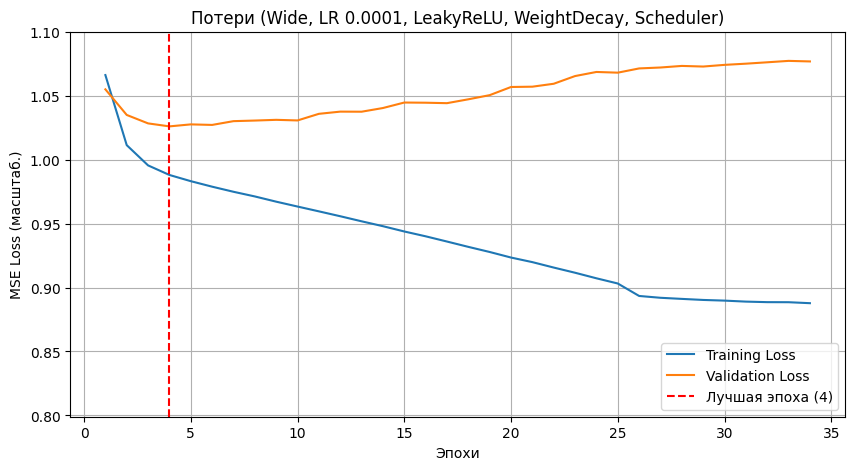

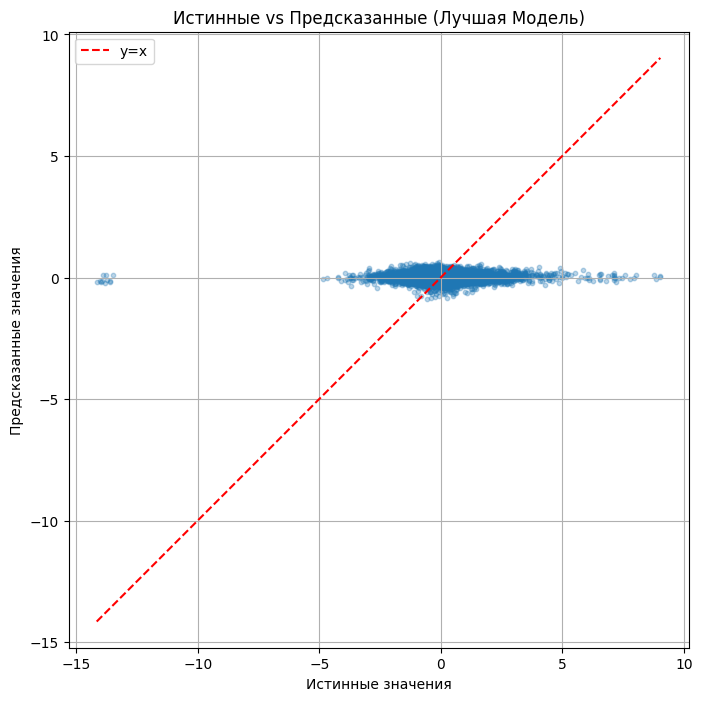


Скрипт завершен.


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# Добавляем импорт планировщика обратно
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import os

# --- Класс для Ранней Остановки ---
class EarlyStopping:
    """Останавливает обучение, если validation loss не улучшается после заданного patience.
       Сохраняет модель КАЖДЫЙ раз, когда val_loss улучшается."""
    def __init__(self, patience=30, verbose=False, path='checkpoint.pt', trace_func=print): # Увеличен patience
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        # self.delta больше не нужен
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss # Минимизируем loss, максимизируем score

        if self.best_score is None:
            # Первая эпоха или первое улучшение
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score > self.best_score: # Изменено условие: строгое улучшение (score > best_score)
            # Loss уменьшился - сохраняем модель и сбрасываем счетчик
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        else:
            # Улучшения нет или loss остался тем же
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        '''Сохраняет модель, если validation loss уменьшился.'''
        if self.verbose:
            # Скорректируем сообщение, т.к. delta больше нет
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# --- Configuration ---
# Try to mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DRIVE_PATH = '/content/drive/MyDrive/'
    print("Google Drive смонтирован успешно.")
except ModuleNotFoundError:
    print("Запуск не в Google Colab или ошибка монтирования. Используется текущая директория.")
    BASE_DRIVE_PATH = './'

DATA_FILE_PATH = os.path.join(BASE_DRIVE_PATH, '0moex_qcml_final_dataset_with_embeddings.parquet')
TARGET_COLUMN = 'FinalTarget'
DATE_COLUMN = 'TRADEDATE'

# Model Hyperparameters (Широкая, LeakyReLU, ОЧЕНЬ низкий LR, Weight Decay, с планировщиком)
INPUT_DIM = -1
HIDDEN_DIM1 = 256
HIDDEN_DIM2 = 128
HIDDEN_DIM3 = 64
HIDDEN_DIM4 = 32
OUTPUT_DIM = 1
# DROPOUT_PROB убран
LEARNING_RATE = 0.0001 # ОЧЕНЬ НИЗКИЙ LR
WEIGHT_DECAY = 1e-5 # Небольшая L2 регуляризация
BATCH_SIZE = 2048
EPOCHS = 200 # Дадим больше времени с низким LR

# Параметры Early Stopping
EARLY_STOPPING_PATIENCE = 30 # Оставляем терпение
CHECKPOINT_PATH = 'best_model_wide4L_lr0001_wd_Leaky_sched.pt' # Новое имя файла

# --- Phase 1: Setup & Data Loading ---
print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")

if not os.path.exists(DATA_FILE_PATH):
    print(f"ОШИБКА: Файл данных не найден по пути {DATA_FILE_PATH}")
    print("Пожалуйста, убедитесь, что файл существует и путь указан верно.")
    # Создаем dummy-данные для демонстрации, если файл не найден
    print("Создание dummy-данных для демонстрации...")
    num_samples = 10000
    num_features = 18 # Используем 18 признаков, как в логе
    num_days = 100
    stocks_per_day = num_samples // num_days
    dummy_data = {
        DATE_COLUMN: np.repeat(pd.date_range('2010-01-01', periods=num_days, freq='B').astype(np.int64) // 10**9, stocks_per_day) * 1_000_000_000, # Nanoseconds
        TARGET_COLUMN: np.random.randn(num_samples),
    }
    for i in range(num_features):
        dummy_data[f'feature_{i+1}'] = np.random.randn(num_samples)
    df = pd.DataFrame(dummy_data)
    print("Dummy-данные созданы.")
else:
    try:
        df = pd.read_parquet(DATA_FILE_PATH)
        print("Данные успешно загружены.")
    except Exception as e:
        print(f"ОШИБКА: Не удалось загрузить Parquet файл: {e}")
        raise

# Verification
print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN]
missing_req = [col for col in required_cols if col not in df.columns]
if missing_req:
    print(f"ОШИБКА: Отсутствуют обязательные столбцы: {missing_req}")
    raise ValueError("Отсутствуют обязательные столбцы")
else:
    print(f"Обязательные столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")

# Automatically identify feature columns
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]]
if not feature_columns:
    print("ОШИБКА: Не найдено ни одного столбца с признаками (кроме даты и цели).")
    raise ValueError("Нет признаков для обучения")

INPUT_DIM = len(feature_columns) # Set NN input dimension
print(f"Найдено {INPUT_DIM} столбцов-признаков.")
# print(feature_columns)


# --- Phase 2: Initial Time Sort & Data Splitting ---
print("\n--- Сортировка и разбиение данных ---")

# Ensure DATE_COLUMN is numeric (Unix timestamp) or convert if needed
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try:
        # Attempt conversion assuming it's a datetime string/object
        df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
        print(f"Столбец '{DATE_COLUMN}' конвертирован в числовой Unix timestamp (nanoseconds).")
    except Exception as e:
        print(f"ОШИБКА: Не удалось конвертировать '{DATE_COLUMN}' в числовой формат: {e}")
        raise
else:
    print(f"Столбец '{DATE_COLUMN}' уже числовой.")


df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True)
print(f"Данные отсортированы по '{DATE_COLUMN}'.")

# Исправленное разбиение
split_idx = int(len(df) * 0.9)
# Найдем последнюю дату в предполагаемом трейне
last_train_date = df.loc[split_idx - 1, DATE_COLUMN]
# Скорректируем индекс так, чтобы все строки с этой датой остались в трейне
# Найдем ПЕРВЫЙ индекс, где дата БОЛЬШЕ последней даты трейна
actual_split_idx = (df[DATE_COLUMN] > last_train_date).idxmax()
# Если все даты одинаковые или последняя дата - максимальная, idxmax вернет 0,
# используем исходный split_idx в этом редком случае или если он > 0
if actual_split_idx == 0 and split_idx > 0 :
     actual_split_idx = split_idx # Используем расчетный индекс, если не удалось найти следующую дату

train_df = df.iloc[:actual_split_idx].copy()
test_df = df.iloc[actual_split_idx:].copy()

# Проверка на пустые датасеты после разбиения
if train_df.empty or test_df.empty:
    print(f"ОШИБКА: Одно из подмножеств данных пустое после разбиения! Индекс: {actual_split_idx}, Всего строк: {len(df)}")
    # Можно вернуться к простому разбиению, если исправление не работает
    print("Возврат к простому разбиению по индексу.")
    split_idx = int(len(df) * 0.9)
    train_df = df.iloc[:split_idx].copy()
    test_df = df.iloc[split_idx:].copy()
    if train_df.empty or test_df.empty:
         raise ValueError("Ошибка разбиения: датасеты пусты.")


train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])

print(f"Тренировочные данные: {len(train_df)} семплов, с {train_start} по {train_end}")
print(f"Тестовые данные     : {len(test_df)} семплов, с {test_start} по {test_end}")

# Проверка перекрытия
if train_end < test_start:
    print("Хронологическое разбиение успешно, перекрытия нет.")
elif train_end == test_start:
     print("ВНИМАНИЕ: Граница разбиения проходит по одной дате. Убедитесь, что это допустимо.")
else:
     print(f"ОШИБКА: Перекрытие дат! Конец трейна: {train_end}, Начало теста: {test_start}")
     # Возможно, стоит остановить выполнение или добавить доп. логику


# --- Phase 3: Preprocessing (Scaling) ---
print("\n--- Предобработка (Масштабирование) ---")
X_train = train_df[feature_columns]; y_train = train_df[[TARGET_COLUMN]]
X_test = test_df[feature_columns]; y_test = test_df[[TARGET_COLUMN]]
feature_scaler = StandardScaler(); target_scaler = StandardScaler()
print("Обучение масштабировщиков..."); X_train_scaled = feature_scaler.fit_transform(X_train); y_train_scaled = target_scaler.fit_transform(y_train)
print("Применение масштабировщиков..."); X_test_scaled = feature_scaler.transform(X_test); y_test_scaled = target_scaler.transform(y_test)
print(f"Цель (трейн) после масштабирования: mean={np.mean(y_train_scaled):.4f}, std={np.std(y_train_scaled):.4f}")
print(f"Цель (тест) после масштабирования: mean={np.mean(y_test_scaled):.4f}, std={np.std(y_test_scaled):.4f}")


# --- Phase 4: Model Definition & Training ---
print("\n--- Определение и Обучение Модели ---")
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32); y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32); y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor); test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True); test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Модель с LeakyReLU вместо ReLU, без Dropout
class ClassicalNN(nn.Module):
    def __init__(self, input_dim, h1, h2, h3, h4, output_dim):
        super(ClassicalNN, self).__init__()
        # Используем LeakyReLU
        self.layer1 = nn.Linear(input_dim, h1); self.bn1 = nn.BatchNorm1d(h1); self.leaky_relu1 = nn.LeakyReLU(0.01)
        self.layer2 = nn.Linear(h1, h2);        self.bn2 = nn.BatchNorm1d(h2); self.leaky_relu2 = nn.LeakyReLU(0.01)
        self.layer3 = nn.Linear(h2, h3);        self.bn3 = nn.BatchNorm1d(h3); self.leaky_relu3 = nn.LeakyReLU(0.01)
        self.layer4 = nn.Linear(h3, h4);        self.bn4 = nn.BatchNorm1d(h4); self.leaky_relu4 = nn.LeakyReLU(0.01)
        self.output_layer = nn.Linear(h4, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        if x.shape[0] > 1: x = self.bn1(x)
        x = self.leaky_relu1(x) # LeakyReLU

        x = self.layer2(x)
        if x.shape[0] > 1: x = self.bn2(x)
        x = self.leaky_relu2(x) # LeakyReLU

        x = self.layer3(x)
        if x.shape[0] > 1: x = self.bn3(x)
        x = self.leaky_relu3(x) # LeakyReLU

        x = self.layer4(x)
        if x.shape[0] > 1: x = self.bn4(x)
        x = self.leaky_relu4(x) # LeakyReLU

        x = self.output_layer(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Создаем модель с LeakyReLU
model = ClassicalNN(INPUT_DIM, HIDDEN_DIM1, HIDDEN_DIM2, HIDDEN_DIM3, HIDDEN_DIM4, OUTPUT_DIM).to(device)
criterion = nn.MSELoss()
# Оптимизатор с НИЗКИМ LR и Weight Decay
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY) # LR = 0.0001, weight_decay=1e-5

# Планировщик LR с терпением 20
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20, threshold=0.001, verbose=True) # patience=20

# Инициализируем Early Stopping с терпением 30
early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, verbose=True, path=CHECKPOINT_PATH) # patience=30

# Training Loop
train_losses = []; val_losses = []
start_time = time.time()
print(f"Начало обучения с LR={LEARNING_RATE}, WeightDecay={WEIGHT_DECAY}, LeakyReLU, Epochs={EPOCHS} (с планировщиком и Early Stopping)...")

for epoch in range(EPOCHS): # EPOCHS = 200
    model.train()
    epoch_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Фаза валидации
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * inputs.size(0)
    avg_val_loss = epoch_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Эпоха [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.7f}")

    # Шаг планировщика
    scheduler.step(avg_val_loss)

    # Проверка Early Stopping
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print("Ранняя остановка.")
        break

training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд.")

# Загрузка лучшей модели
print(f"Загрузка лучшей модели из {CHECKPOINT_PATH}")
try:
    model.load_state_dict(torch.load(CHECKPOINT_PATH))
    print("Лучшая модель успешно загружена.")
except FileNotFoundError:
    print(f"Ошибка: Файл чекпоинта {CHECKPOINT_PATH} не найден. Используется последняя модель.")
except Exception as e:
     print(f"Ошибка при загрузке чекпоинта: {e}. Используется последняя модель.")


# --- Phase 5: Prediction & Final Evaluation ---
print("\n--- Предсказание и Финальная Оценка (с лучшей моделью) ---")
model.eval(); predictions_scaled_list = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions_scaled_list.append(outputs.cpu().numpy())
predictions_scaled = np.concatenate(predictions_scaled_list, axis=0)
predictions_original_scale = target_scaler.inverse_transform(predictions_scaled)
y_test_original_scale = target_scaler.inverse_transform(y_test_scaled)
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale)
final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
final_r2 = r2_score(y_test_original_scale, predictions_original_scale)
print("\n--- Финальные Метрики (в исходном масштабе цели) ---")
print(f"Тестовый набор MSE: {final_mse:.6f}"); print(f"Тестовый набор MAE: {final_mae:.6f}"); print(f"Тестовый набор R^2: {final_r2:.4f}")


# --- Phase 6: Visualization ---
print("\n--- Построение Графиков ---")
epochs_ran = len(train_losses)
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs_ran + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs_ran + 1), val_losses, label='Validation Loss')
best_epoch = np.argmin(val_losses) + 1
plt.axvline(best_epoch, linestyle='--', color='r', label=f'Лучшая эпоха ({best_epoch})')
plt.xlabel('Эпохи'); plt.ylabel('MSE Loss (масштаб.)'); plt.title('Потери (Wide, LR 0.0001, LeakyReLU, WeightDecay, Scheduler)')
plt.legend(); plt.grid(True); plt.ylim(bottom=min(train_losses[-1], val_losses[-1])*0.9, top=1.1) # Адаптивный ylim
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10)
plt.xlabel('Истинные значения'); plt.ylabel('Предсказанные значения'); plt.title('Истинные vs Предсказанные (Лучшая Модель)')
min_val = min(y_test_original_scale.min(), predictions_original_scale.min()); max_val = max(y_test_original_scale.max(), predictions_original_scale.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x'); plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()
print("\nСкрипт завершен.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive смонтирован успешно.
Попытка загрузить данные из: /content/drive/MyDrive/0moex_qcml_final_dataset_with_embeddings.parquet
Данные успешно загружены.

--- Проверка данных ---
Столбцы 'TRADEDATE' и 'FinalTarget' найдены.
Найдено 18 столбцов-признаков.

--- Сортировка и разбиение данных ---
Данные отсортированы.
Тренировочные: 150851 (2021-04-20 00:00:00 - 2024-11-18 00:00:00)
Тестовые: 16735 (2024-11-25 00:00:00 - 2025-03-27 00:00:00)
Хронологическое разбиение успешно.

--- Предобработка (Масштабирование) ---
Обучение масштабировщиков...
Применение масштабировщиков...
Цель (трейн) после масштабирования: mean=0.0000, std=1.0000
Цель (тест) после масштабирования: mean=-0.0069, std=1.0036

--- Определение и Обучение Модели ---
Используемое устройство: cuda
Начало обучения с LR=0.001, BatchSize=512, БЕЗ Dropout/Scheduler/ES...
*** Новый лучший Train Los

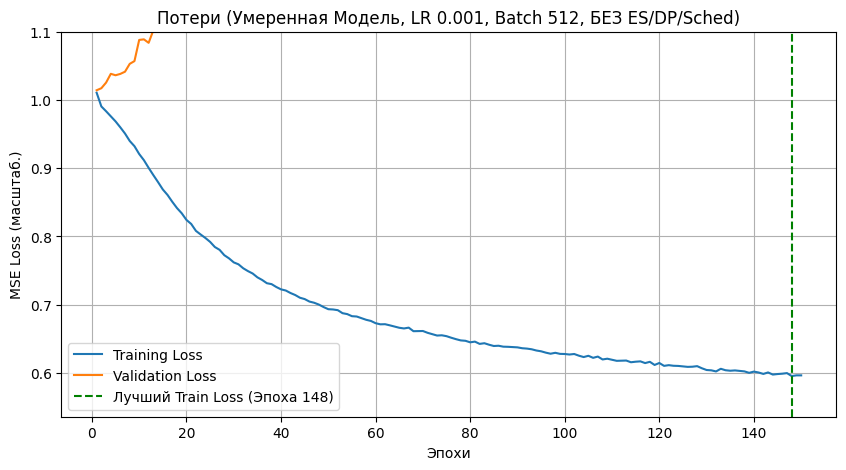

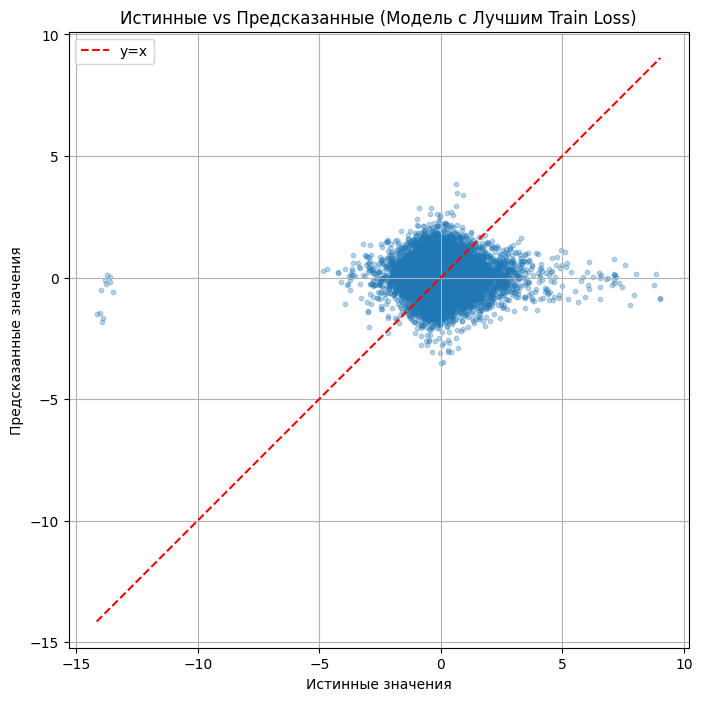


Скрипт завершен.


In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# Убраны импорты Scheduler и EarlyStopping
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import os

# Убран класс EarlyStopping

# --- Configuration ---
try:
    from google.colab import drive
    drive.mount('/content/drive'); BASE_DRIVE_PATH = '/content/drive/MyDrive/'
    print("Google Drive смонтирован успешно.")
except ModuleNotFoundError:
    print("Запуск не в Google Colab или ошибка монтирования. Используется текущая директория.")
    BASE_DRIVE_PATH = './'

DATA_FILE_PATH = os.path.join(BASE_DRIVE_PATH, '0moex_qcml_final_dataset_with_embeddings.parquet')
TARGET_COLUMN = 'FinalTarget'; DATE_COLUMN = 'TRADEDATE'

# Model Hyperparameters (Умеренная сложность, БЕЗ Dropout/Scheduler/ES, LR 0.001, БОЛЬШОЙ батч)
INPUT_DIM = -1
HIDDEN_DIM1 = 128 # Умеренная сложность
HIDDEN_DIM2 = 64
HIDDEN_DIM3 = 32
# HIDDEN_DIM4 больше нет
OUTPUT_DIM = 1
# DROPOUT_PROB убран
LEARNING_RATE = 0.001 # Умеренный LR
# WEIGHT_DECAY убран
BATCH_SIZE = 512 # Увеличен Batch Size
EPOCHS = 150

# Путь для сохранения лучшей ТРЕНИРОВОЧНОЙ модели
BEST_TRAIN_MODEL_PATH = 'best_train_loss_model.pt'

# --- Phase 1, 2, 3 (Без изменений) ---
print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")
if not os.path.exists(DATA_FILE_PATH): print(f"ОШИБКА: Файл не найден {DATA_FILE_PATH}"); raise FileNotFoundError
else:
    try: df = pd.read_parquet(DATA_FILE_PATH); print("Данные успешно загружены.")
    except Exception as e: print(f"ОШИБКА: Не удалось загрузить Parquet: {e}"); raise

print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN];
if not all(col in df.columns for col in required_cols): print(f"ОШИБКА: Отсутствуют столбцы: {[c for c in required_cols if c not in df.columns]}"); raise ValueError
else: print(f"Столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]];
if not feature_columns: print("ОШИБКА: Нет признаков."); raise ValueError
INPUT_DIM = len(feature_columns); print(f"Найдено {INPUT_DIM} столбцов-признаков.")

print("\n--- Сортировка и разбиение данных ---")
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try: df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
    except Exception as e: print(f"ОШИБКА конвертации '{DATE_COLUMN}': {e}"); raise
df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True); print(f"Данные отсортированы.")
split_idx = int(len(df) * 0.9); last_train_date = df.loc[split_idx - 1, DATE_COLUMN]
actual_split_idx = (df[DATE_COLUMN] > last_train_date).idxmax()
if actual_split_idx == 0 and split_idx > 0 : actual_split_idx = split_idx
train_df = df.iloc[:actual_split_idx].copy(); test_df = df.iloc[actual_split_idx:].copy()
if train_df.empty or test_df.empty: print(f"ОШИБКА: Пустой датасет после разбиения! Индекс: {actual_split_idx}"); raise ValueError
train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])
print(f"Тренировочные: {len(train_df)} ({train_start} - {train_end})"); print(f"Тестовые: {len(test_df)} ({test_start} - {test_end})")
if train_end < test_start: print("Хронологическое разбиение успешно.")
elif train_end == test_start: print("ВНИМАНИЕ: Граница разбиения по одной дате.")
else: print(f"ОШИБКА: Перекрытие дат! {train_end} vs {test_start}")

print("\n--- Предобработка (Масштабирование) ---")
X_train = train_df[feature_columns]; y_train = train_df[[TARGET_COLUMN]]
X_test = test_df[feature_columns]; y_test = test_df[[TARGET_COLUMN]]
feature_scaler = StandardScaler(); target_scaler = StandardScaler()
print("Обучение масштабировщиков..."); X_train_scaled = feature_scaler.fit_transform(X_train); y_train_scaled = target_scaler.fit_transform(y_train)
print("Применение масштабировщиков..."); X_test_scaled = feature_scaler.transform(X_test); y_test_scaled = target_scaler.transform(y_test)
print(f"Цель (трейн) после масштабирования: mean={np.mean(y_train_scaled):.4f}, std={np.std(y_train_scaled):.4f}")
print(f"Цель (тест) после масштабирования: mean={np.mean(y_test_scaled):.4f}, std={np.std(y_test_scaled):.4f}")

# --- Phase 4: Model Definition & Training ---
print("\n--- Определение и Обучение Модели ---")
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32); y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32); y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor); test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Используем новый BATCH_SIZE
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True); test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Модель с 3 слоями и ReLU
class ClassicalNN(nn.Module):
    def __init__(self, input_dim, h1, h2, h3, output_dim): # Убран h4
        super(ClassicalNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, h1); self.bn1 = nn.BatchNorm1d(h1); self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(h1, h2);        self.bn2 = nn.BatchNorm1d(h2); self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(h2, h3);        self.bn3 = nn.BatchNorm1d(h3); self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(h3, output_dim) # Выход с 3-го слоя

    def forward(self, x):
        x = self.layer1(x)
        if x.shape[0] > 1: x = self.bn1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        if x.shape[0] > 1: x = self.bn2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        if x.shape[0] > 1: x = self.bn3(x)
        x = self.relu3(x)
        # Убран 4-й слой
        x = self.output_layer(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Создаем модель
model = ClassicalNN(INPUT_DIM, HIDDEN_DIM1, HIDDEN_DIM2, HIDDEN_DIM3, OUTPUT_DIM).to(device)
criterion = nn.MSELoss()
# Используем LR=0.001, без WeightDecay
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Планировщик УБРАН
# Early Stopping УБРАН

# Training Loop
train_losses = []; val_losses = []
best_train_loss = np.inf # Отслеживаем лучший Train Loss
start_time = time.time()
print(f"Начало обучения с LR={LEARNING_RATE}, BatchSize={BATCH_SIZE}, БЕЗ Dropout/Scheduler/ES...")

for epoch in range(EPOCHS): # EPOCHS = 150
    model.train()
    epoch_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Сохранение модели по лучшему Train Loss
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        torch.save(model.state_dict(), BEST_TRAIN_MODEL_PATH)
        print(f"*** Новый лучший Train Loss: {best_train_loss:.6f}. Модель сохранена в {BEST_TRAIN_MODEL_PATH} ***")

    # Фаза валидации (оставляем для информации)
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * inputs.size(0)
    avg_val_loss = epoch_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr'] # LR будет постоянным
    print(f"Эпоха [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.7f}")

    # Early Stopping УБРАН

training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд.")

# Загрузка ЛУЧШЕЙ ТРЕНИРОВОЧНОЙ модели
print(f"Загрузка модели с лучшим Train Loss из {BEST_TRAIN_MODEL_PATH}")
try:
    # Создаем новую модель той же архитектуры перед загрузкой весов
    # Это важно, если вы хотите быть уверены, что загружаете именно сохраненные веса,
    # а не продолжаете с последними весами из цикла.
    final_model = ClassicalNN(INPUT_DIM, HIDDEN_DIM1, HIDDEN_DIM2, HIDDEN_DIM3, OUTPUT_DIM).to(device)
    final_model.load_state_dict(torch.load(BEST_TRAIN_MODEL_PATH))
    print("Модель с лучшим Train Loss успешно загружена.")
except FileNotFoundError:
    print(f"Ошибка: Файл {BEST_TRAIN_MODEL_PATH} не найден. Используется последняя модель из цикла.")
    final_model = model # Используем последнюю модель, если сохранение не удалось
except Exception as e:
     print(f"Ошибка при загрузке модели ({e}). Используется последняя модель из цикла.")
     final_model = model

# --- Phase 5: Prediction & Final Evaluation ---
print("\n--- Предсказание и Финальная Оценка (с моделью с лучшим Train Loss) ---")
# Используем final_model для предсказания
final_model.eval()
predictions_scaled_list = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = final_model(inputs) # Используем final_model
        predictions_scaled_list.append(outputs.cpu().numpy())

predictions_scaled = np.concatenate(predictions_scaled_list, axis=0)
predictions_original_scale = target_scaler.inverse_transform(predictions_scaled)
y_test_original_scale = target_scaler.inverse_transform(y_test_scaled)
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale)
final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
final_r2 = r2_score(y_test_original_scale, predictions_original_scale)
print("\n--- Финальные Метрики (в исходном масштабе цели) ---")
print(f"Тестовый набор MSE: {final_mse:.6f}"); print(f"Тестовый набор MAE: {final_mae:.6f}"); print(f"Тестовый набор R^2: {final_r2:.4f}")

# --- Phase 6: Visualization ---
print("\n--- Построение Графиков ---")
epochs_ran = len(train_losses)
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs_ran + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs_ran + 1), val_losses, label='Validation Loss')
# Отметим эпоху с лучшим train loss
best_train_epoch = np.argmin(train_losses) + 1
plt.axvline(best_train_epoch, linestyle='--', color='g', label=f'Лучший Train Loss (Эпоха {best_train_epoch})')
plt.xlabel('Эпохи'); plt.ylabel('MSE Loss (масштаб.)'); plt.title('Потери (Умеренная Модель, LR 0.001, Batch 512, БЕЗ ES/DP/Sched)')
plt.legend(); plt.grid(True); plt.ylim(bottom=min(train_losses)*0.9 if train_losses else 0, top=1.1) # Адаптивный ylim
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10)
plt.xlabel('Истинные значения'); plt.ylabel('Предсказанные значения'); plt.title('Истинные vs Предсказанные (Модель с Лучшим Train Loss)')
min_val = min(y_test_original_scale.min(), predictions_original_scale.min()); max_val = max(y_test_original_scale.max(), predictions_original_scale.max()); plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x'); plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()
print("\nСкрипт завершен.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive смонтирован успешно.
Попытка загрузить данные из: /content/drive/MyDrive/0moex_qcml_final_dataset_with_embeddings.parquet
Данные успешно загружены.

--- Проверка данных ---
Столбцы 'TRADEDATE' и 'FinalTarget' найдены.
Найдено 18 столбцов-признаков.

--- Сортировка и разбиение данных ---
Данные отсортированы.
Тренировочные: 150851 (2021-04-20 00:00:00 - 2024-11-18 00:00:00)
Тестовые: 16735 (2024-11-25 00:00:00 - 2025-03-27 00:00:00)
Хронологическое разбиение успешно.

--- Предобработка (Масштабирование) ---
Обучение масштабировщиков...
Применение масштабировщиков...
Цель (трейн) после масштабирования: mean=0.0000, std=1.0000
Цель (тест) после масштабирования: mean=-0.0069, std=1.0036

--- Определение и Обучение Модели ---
Используемое устройство: cpu
Начало обучения ГЛУБОКОЙ модели (5 слоев) с LR=0.001, BatchSize=512, БЕЗ Dropout/Scheduler/ES...
*

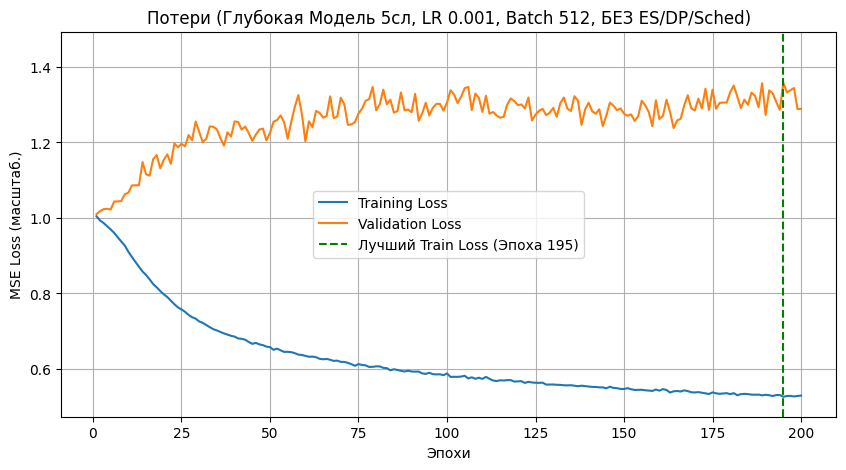

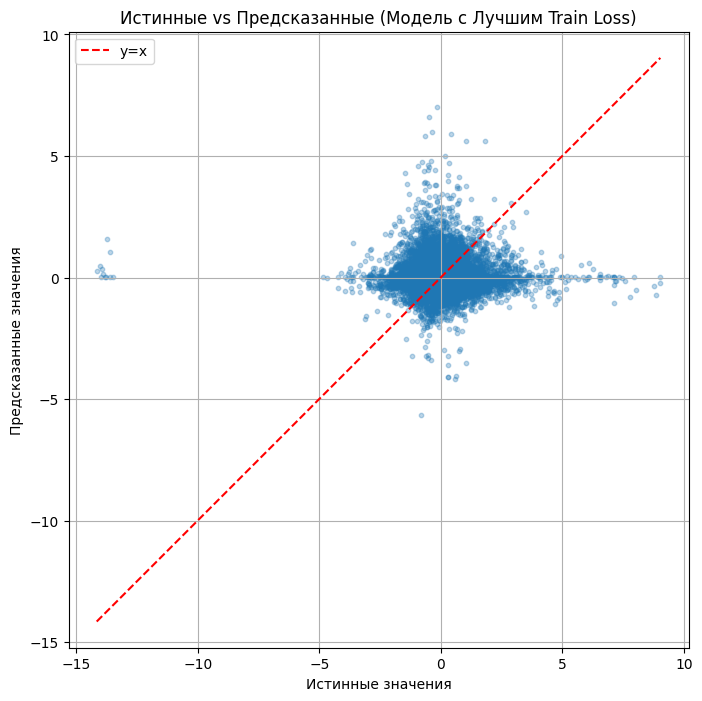


Скрипт завершен.


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# Убраны импорты Scheduler и EarlyStopping
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import os

# Убран класс EarlyStopping

# --- Configuration ---
try:
    from google.colab import drive
    drive.mount('/content/drive'); BASE_DRIVE_PATH = '/content/drive/MyDrive/'
    print("Google Drive смонтирован успешно.")
except ModuleNotFoundError:
    print("Запуск не в Google Colab или ошибка монтирования. Используется текущая директория.")
    BASE_DRIVE_PATH = './'

DATA_FILE_PATH = os.path.join(BASE_DRIVE_PATH, '0moex_qcml_final_dataset_with_embeddings.parquet')
TARGET_COLUMN = 'FinalTarget'; DATE_COLUMN = 'TRADEDATE'

# Model Hyperparameters (ГЛУБОКАЯ модель, 5 слоев, БЕЗ Dropout/Scheduler/ES, LR 0.001, БОЛЬШОЙ батч)
INPUT_DIM = -1
HIDDEN_DIM1 = 128 # 5 скрытых слоев
HIDDEN_DIM2 = 64
HIDDEN_DIM3 = 32
HIDDEN_DIM4 = 16
HIDDEN_DIM5 = 8
OUTPUT_DIM = 1
# DROPOUT_PROB убран
LEARNING_RATE = 0.001 # Умеренный LR
# WEIGHT_DECAY убран
BATCH_SIZE = 512 # Увеличен Batch Size
EPOCHS = 200 # Увеличим эпохи для глубокой модели

# Путь для сохранения лучшей ТРЕНИРОВОЧНОЙ модели
BEST_TRAIN_MODEL_PATH = 'best_train_loss_deep5L_model.pt' # Новое имя

# --- Phase 1, 2, 3 (Без изменений) ---
print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")
if not os.path.exists(DATA_FILE_PATH): print(f"ОШИБКА: Файл не найден {DATA_FILE_PATH}"); raise FileNotFoundError
else:
    try: df = pd.read_parquet(DATA_FILE_PATH); print("Данные успешно загружены.")
    except Exception as e: print(f"ОШИБКА: Не удалось загрузить Parquet: {e}"); raise

print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN];
if not all(col in df.columns for col in required_cols): print(f"ОШИБКА: Отсутствуют столбцы: {[c for c in required_cols if c not in df.columns]}"); raise ValueError
else: print(f"Столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]];
if not feature_columns: print("ОШИБКА: Нет признаков."); raise ValueError
INPUT_DIM = len(feature_columns); print(f"Найдено {INPUT_DIM} столбцов-признаков.")

print("\n--- Сортировка и разбиение данных ---")
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try: df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
    except Exception as e: print(f"ОШИБКА конвертации '{DATE_COLUMN}': {e}"); raise
df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True); print(f"Данные отсортированы.")
split_idx = int(len(df) * 0.9); last_train_date = df.loc[split_idx - 1, DATE_COLUMN]
actual_split_idx = (df[DATE_COLUMN] > last_train_date).idxmax()
if actual_split_idx == 0 and split_idx > 0 : actual_split_idx = split_idx
train_df = df.iloc[:actual_split_idx].copy(); test_df = df.iloc[actual_split_idx:].copy()
if train_df.empty or test_df.empty: print(f"ОШИБКА: Пустой датасет после разбиения! Индекс: {actual_split_idx}"); raise ValueError
train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])
print(f"Тренировочные: {len(train_df)} ({train_start} - {train_end})"); print(f"Тестовые: {len(test_df)} ({test_start} - {test_end})")
if train_end < test_start: print("Хронологическое разбиение успешно.")
elif train_end == test_start: print("ВНИМАНИЕ: Граница разбиения по одной дате.")
else: print(f"ОШИБКА: Перекрытие дат! {train_end} vs {test_start}")

print("\n--- Предобработка (Масштабирование) ---")
X_train = train_df[feature_columns]; y_train = train_df[[TARGET_COLUMN]]
X_test = test_df[feature_columns]; y_test = test_df[[TARGET_COLUMN]]
feature_scaler = StandardScaler(); target_scaler = StandardScaler()
print("Обучение масштабировщиков..."); X_train_scaled = feature_scaler.fit_transform(X_train); y_train_scaled = target_scaler.fit_transform(y_train)
print("Применение масштабировщиков..."); X_test_scaled = feature_scaler.transform(X_test); y_test_scaled = target_scaler.transform(y_test)
print(f"Цель (трейн) после масштабирования: mean={np.mean(y_train_scaled):.4f}, std={np.std(y_train_scaled):.4f}")
print(f"Цель (тест) после масштабирования: mean={np.mean(y_test_scaled):.4f}, std={np.std(y_test_scaled):.4f}")

# --- Phase 4: Model Definition & Training ---
print("\n--- Определение и Обучение Модели ---")
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32); y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32); y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor); test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Используем новый BATCH_SIZE
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True); test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ГЛУБОКАЯ Модель с 5 слоями и ReLU
class ClassicalNN(nn.Module):
    # Добавляем h5 в параметры
    def __init__(self, input_dim, h1, h2, h3, h4, h5, output_dim):
        super(ClassicalNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, h1); self.bn1 = nn.BatchNorm1d(h1); self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(h1, h2);        self.bn2 = nn.BatchNorm1d(h2); self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(h2, h3);        self.bn3 = nn.BatchNorm1d(h3); self.relu3 = nn.ReLU()
        self.layer4 = nn.Linear(h3, h4);        self.bn4 = nn.BatchNorm1d(h4); self.relu4 = nn.ReLU() # 4й слой
        self.layer5 = nn.Linear(h4, h5);        self.bn5 = nn.BatchNorm1d(h5); self.relu5 = nn.ReLU() # 5й слой
        # Выходной слой принимает h5
        self.output_layer = nn.Linear(h5, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        if x.shape[0] > 1: x = self.bn1(x)
        x = self.relu1(x)

        x = self.layer2(x)
        if x.shape[0] > 1: x = self.bn2(x)
        x = self.relu2(x)

        x = self.layer3(x)
        if x.shape[0] > 1: x = self.bn3(x)
        x = self.relu3(x)

        x = self.layer4(x) # Добавлен 4й слой
        if x.shape[0] > 1: x = self.bn4(x)
        x = self.relu4(x)

        x = self.layer5(x) # Добавлен 5й слой
        if x.shape[0] > 1: x = self.bn5(x)
        x = self.relu5(x)

        x = self.output_layer(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Создаем ГЛУБОКУЮ модель
model = ClassicalNN(INPUT_DIM, HIDDEN_DIM1, HIDDEN_DIM2, HIDDEN_DIM3, HIDDEN_DIM4, HIDDEN_DIM5, OUTPUT_DIM).to(device)
criterion = nn.MSELoss()
# Используем LR=0.001, без WeightDecay
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Планировщик УБРАН
# Early Stopping УБРАН

# Training Loop
train_losses = []; val_losses = []
best_train_loss = np.inf # Отслеживаем лучший Train Loss
start_time = time.time()
print(f"Начало обучения ГЛУБОКОЙ модели (5 слоев) с LR={LEARNING_RATE}, BatchSize={BATCH_SIZE}, БЕЗ Dropout/Scheduler/ES...")

for epoch in range(EPOCHS): # EPOCHS = 200
    model.train()
    epoch_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Сохранение модели по лучшему Train Loss
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        torch.save(model.state_dict(), BEST_TRAIN_MODEL_PATH)
        print(f"*** Новый лучший Train Loss: {best_train_loss:.6f}. Модель сохранена в {BEST_TRAIN_MODEL_PATH} ***")

    # Фаза валидации (оставляем для информации)
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * inputs.size(0)
    avg_val_loss = epoch_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr'] # LR будет постоянным
    print(f"Эпоха [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.7f}")

    # Early Stopping УБРАН

training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд.")

# Загрузка ЛУЧШЕЙ ТРЕНИРОВОЧНОЙ модели
print(f"Загрузка модели с лучшим Train Loss из {BEST_TRAIN_MODEL_PATH}")
try:
    # Создаем новую модель той же архитектуры перед загрузкой весов
    final_model = ClassicalNN(INPUT_DIM, HIDDEN_DIM1, HIDDEN_DIM2, HIDDEN_DIM3, HIDDEN_DIM4, HIDDEN_DIM5, OUTPUT_DIM).to(device)
    final_model.load_state_dict(torch.load(BEST_TRAIN_MODEL_PATH))
    print("Модель с лучшим Train Loss успешно загружена.")
except FileNotFoundError:
    print(f"Ошибка: Файл {BEST_TRAIN_MODEL_PATH} не найден. Используется последняя модель из цикла.")
    final_model = model # Используем последнюю модель, если сохранение не удалось
except Exception as e:
     print(f"Ошибка при загрузке модели ({e}). Используется последняя модель из цикла.")
     final_model = model

# --- Phase 5: Prediction & Final Evaluation ---
print("\n--- Предсказание и Финальная Оценка (с моделью с лучшим Train Loss) ---")
# Используем final_model для предсказания
final_model.eval()
predictions_scaled_list = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = final_model(inputs) # Используем final_model
        predictions_scaled_list.append(outputs.cpu().numpy())

predictions_scaled = np.concatenate(predictions_scaled_list, axis=0)
predictions_original_scale = target_scaler.inverse_transform(predictions_scaled)
y_test_original_scale = target_scaler.inverse_transform(y_test_scaled)
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale)
final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
final_r2 = r2_score(y_test_original_scale, predictions_original_scale)
print("\n--- Финальные Метрики (в исходном масштабе цели) ---")
print(f"Тестовый набор MSE: {final_mse:.6f}"); print(f"Тестовый набор MAE: {final_mae:.6f}"); print(f"Тестовый набор R^2: {final_r2:.4f}")

# --- Phase 6: Visualization ---
print("\n--- Построение Графиков ---")
epochs_ran = len(train_losses)
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs_ran + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs_ran + 1), val_losses, label='Validation Loss')
# Отметим эпоху с лучшим train loss
best_train_epoch = np.argmin(train_losses) + 1
plt.axvline(best_train_epoch, linestyle='--', color='g', label=f'Лучший Train Loss (Эпоха {best_train_epoch})')
plt.xlabel('Эпохи'); plt.ylabel('MSE Loss (масштаб.)'); plt.title('Потери (Глубокая Модель 5сл, LR 0.001, Batch 512, БЕЗ ES/DP/Sched)')
plt.legend(); plt.grid(True); plt.ylim(bottom=min(train_losses)*0.9 if train_losses else 0, top=max(1.1, max(val_losses) * 1.1) if val_losses else 1.1) # Адаптивный ylim
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10)
plt.xlabel('Истинные значения'); plt.ylabel('Предсказанные значения'); plt.title('Истинные vs Предсказанные (Модель с Лучшим Train Loss)')
min_val = min(y_test_original_scale.min(), predictions_original_scale.min()); max_val = max(y_test_original_scale.max(), predictions_original_scale.max()); plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x'); plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()
print("\nСкрипт завершен.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive смонтирован успешно.
Попытка загрузить данные из: /content/drive/MyDrive/0moex_qcml_final_dataset_with_embeddings.parquet
Данные успешно загружены.

--- Проверка данных ---
Столбцы 'TRADEDATE' и 'FinalTarget' найдены.
Найдено 18 столбцов-признаков.

--- Сортировка и разбиение данных ---
Данные отсортированы.
Тренировочные: 150851 (2021-04-20 00:00:00 - 2024-11-18 00:00:00)
Тестовые: 16735 (2024-11-25 00:00:00 - 2025-03-27 00:00:00)
Хронологическое разбиение успешно.

--- Предобработка (Масштабирование) ---
Обучение масштабировщиков...
Применение масштабировщиков...
Цель (трейн) после масштабирования: mean=0.0000, std=1.0000
Цель (тест) после масштабирования: mean=-0.0069, std=1.0036

--- Определение и Обучение Модели ---
Используемое устройство: cpu
Начало обучения модели с Residual Blocks, LR=0.004, BatchSize=512...
*** Новый лучший Train Loss: 

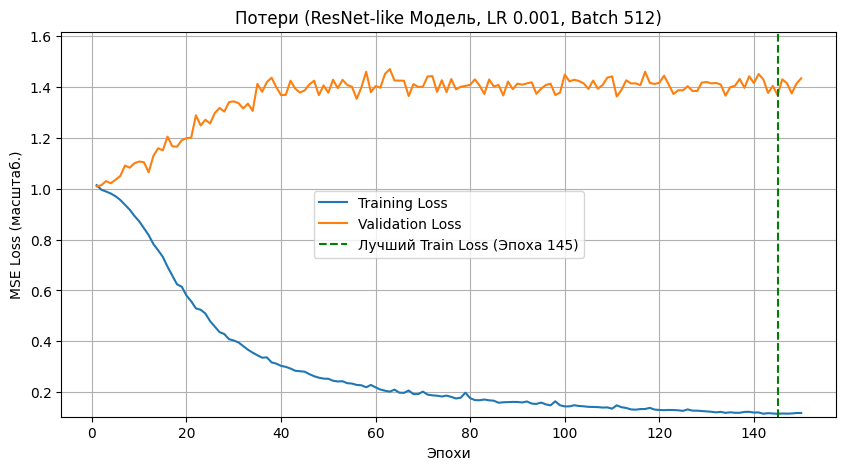

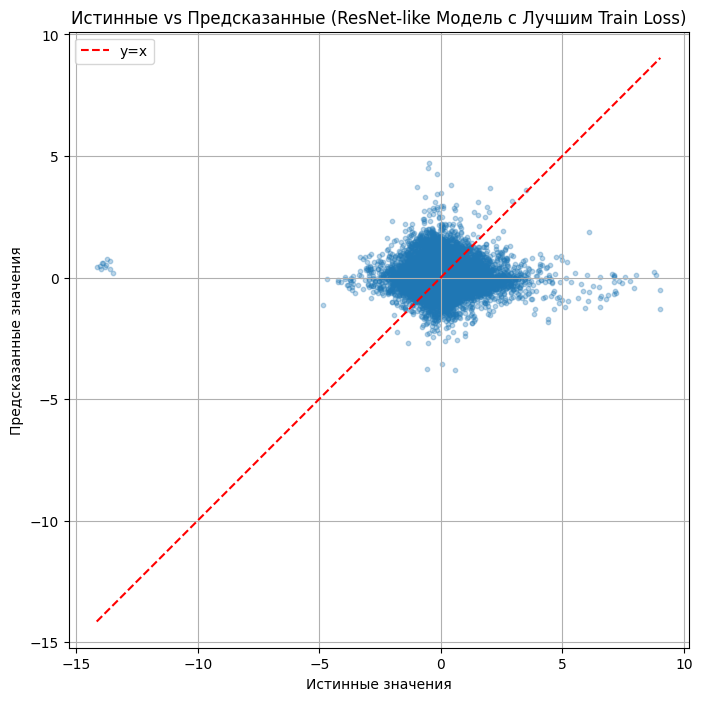


Скрипт завершен.


In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# Убраны импорты Scheduler и EarlyStopping
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import os

# Убран класс EarlyStopping

# --- Класс для Residual Block ---
class ResidualBlock(nn.Module):
    """Остаточный блок: Linear -> BN -> ReLU -> Linear -> BN + Shortcut"""
    def __init__(self, input_dim, output_dim):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
        self.bn1 = nn.BatchNorm1d(output_dim)
        self.relu = nn.ReLU() # Используем ReLU как базовый вариант
        self.linear2 = nn.Linear(output_dim, output_dim)
        self.bn2 = nn.BatchNorm1d(output_dim)

        # Skip connection: если размерности не совпадают, нужна проекция
        if input_dim != output_dim:
            self.shortcut = nn.Sequential(
                nn.Linear(input_dim, output_dim, bias=False), # Часто без bias в shortcut проекции
                nn.BatchNorm1d(output_dim)
            )
        else:
            self.shortcut = nn.Identity() # Просто передаем вход дальше

    def forward(self, x):
        identity = self.shortcut(x) # Путь skip connection

        out = self.linear1(x)
        if out.shape[0] > 1: out = self.bn1(out)
        out = self.relu(out)

        out = self.linear2(out)
        if out.shape[0] > 1: out = self.bn2(out)

        # Добавляем выход skip connection к выходу основного пути
        out += identity
        out = self.relu(out) # Финальная активация блока
        return out

# --- Класс для Модели с Residual Blocks ---
class ClassicalNNWithResBlocks(nn.Module):
    # h1 - размерность после первого слоя и вход в первый блок
    # h2, h3, h4, h5 - выходные размерности ResBlocks 1, 2, 3, 4 соответственно
    def __init__(self, input_dim, h1, h2, h3, h4, h5, output_dim):
        super(ClassicalNNWithResBlocks, self).__init__()
        self.initial_layer = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU()
        )
        # Используем Residual Blocks
        self.resblock1 = ResidualBlock(h1, h2) # input_dim=h1, output_dim=h2
        self.resblock2 = ResidualBlock(h2, h3) # input_dim=h2, output_dim=h3
        self.resblock3 = ResidualBlock(h3, h4) # input_dim=h3, output_dim=h4
        self.resblock4 = ResidualBlock(h4, h5) # input_dim=h4, output_dim=h5

        # Финальный выходной слой
        self.output_layer = nn.Linear(h5, output_dim) # Принимает выход последнего блока

    def forward(self, x):
        x = self.initial_layer(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.output_layer(x)
        return x

# --- Configuration ---
try:
    from google.colab import drive
    drive.mount('/content/drive'); BASE_DRIVE_PATH = '/content/drive/MyDrive/'
    print("Google Drive смонтирован успешно.")
except ModuleNotFoundError:
    print("Запуск не в Google Colab или ошибка монтирования. Используется текущая директория.")
    BASE_DRIVE_PATH = './'

DATA_FILE_PATH = os.path.join(BASE_DRIVE_PATH, '0moex_qcml_final_dataset_with_embeddings.parquet')
TARGET_COLUMN = 'FinalTarget'; DATE_COLUMN = 'TRADEDATE'

# Model Hyperparameters (ResNet-like, LR 0.001, БОЛЬШОЙ батч)
INPUT_DIM = -1
# Размеры для ResNet-like модели
H_INITIAL = 256 # Размерность после первого слоя
H_BLOCK1_OUT = 256 # Выход блока 1 (input=128)
H_BLOCK2_OUT = 128  # Выход блока 2 (input=128) -> нужна проекция в shortcut
H_BLOCK3_OUT = 64  # Выход блока 3 (input=64) -> нужна проекция
H_BLOCK4_OUT = 32  # Выход блока 4 (input=32) -> нужна проекция
OUTPUT_DIM = 1
# Dropout/WeightDecay убраны
LEARNING_RATE = 0.004 # Умеренный LR
BATCH_SIZE = 512 # Большой Batch Size
EPOCHS = 150 # Оставляем достаточно эпох

# Путь для сохранения лучшей ТРЕНИРОВОЧНОЙ модели
BEST_TRAIN_MODEL_PATH = 'best_train_loss_resnet_model.pt' # Новое имя

# --- Phase 1, 2, 3 (Без изменений) ---
print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")
# ... (остальной код загрузки, проверки, сортировки, разбиения, масштабирования) ...
if not os.path.exists(DATA_FILE_PATH): print(f"ОШИБКА: Файл не найден {DATA_FILE_PATH}"); raise FileNotFoundError
else:
    try: df = pd.read_parquet(DATA_FILE_PATH); print("Данные успешно загружены.")
    except Exception as e: print(f"ОШИБКА: Не удалось загрузить Parquet: {e}"); raise
print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN];
if not all(col in df.columns for col in required_cols): print(f"ОШИБКА: Отсутствуют столбцы: {[c for c in required_cols if c not in df.columns]}"); raise ValueError
else: print(f"Столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]];
if not feature_columns: print("ОШИБКА: Нет признаков."); raise ValueError
INPUT_DIM = len(feature_columns); print(f"Найдено {INPUT_DIM} столбцов-признаков.")
print("\n--- Сортировка и разбиение данных ---")
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try: df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
    except Exception as e: print(f"ОШИБКА конвертации '{DATE_COLUMN}': {e}"); raise
df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True); print(f"Данные отсортированы.")
split_idx = int(len(df) * 0.9); last_train_date = df.loc[split_idx - 1, DATE_COLUMN]
actual_split_idx = (df[DATE_COLUMN] > last_train_date).idxmax()
if actual_split_idx == 0 and split_idx > 0 : actual_split_idx = split_idx
train_df = df.iloc[:actual_split_idx].copy(); test_df = df.iloc[actual_split_idx:].copy()
if train_df.empty or test_df.empty: print(f"ОШИБКА: Пустой датасет после разбиения! Индекс: {actual_split_idx}"); raise ValueError
train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])
print(f"Тренировочные: {len(train_df)} ({train_start} - {train_end})"); print(f"Тестовые: {len(test_df)} ({test_start} - {test_end})")
if train_end < test_start: print("Хронологическое разбиение успешно.")
elif train_end == test_start: print("ВНИМАНИЕ: Граница разбиения по одной дате.")
else: print(f"ОШИБКА: Перекрытие дат! {train_end} vs {test_start}")
print("\n--- Предобработка (Масштабирование) ---")
X_train = train_df[feature_columns]; y_train = train_df[[TARGET_COLUMN]]
X_test = test_df[feature_columns]; y_test = test_df[[TARGET_COLUMN]]
feature_scaler = StandardScaler(); target_scaler = StandardScaler()
print("Обучение масштабировщиков..."); X_train_scaled = feature_scaler.fit_transform(X_train); y_train_scaled = target_scaler.fit_transform(y_train)
print("Применение масштабировщиков..."); X_test_scaled = feature_scaler.transform(X_test); y_test_scaled = target_scaler.transform(y_test)
print(f"Цель (трейн) после масштабирования: mean={np.mean(y_train_scaled):.4f}, std={np.std(y_train_scaled):.4f}")
print(f"Цель (тест) после масштабирования: mean={np.mean(y_test_scaled):.4f}, std={np.std(y_test_scaled):.4f}")


# --- Phase 4: Model Definition & Training ---
print("\n--- Определение и Обучение Модели ---")
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32); y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32); y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor); test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True); test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Создаем модель С RESIDUAL BLOCKS
model = ClassicalNNWithResBlocks(INPUT_DIM, H_INITIAL, H_BLOCK1_OUT, H_BLOCK2_OUT, H_BLOCK3_OUT, H_BLOCK4_OUT, OUTPUT_DIM).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # LR = 0.001

# Планировщик УБРАН
# Early Stopping УБРАН

# Training Loop
train_losses = []; val_losses = []
best_train_loss = np.inf
start_time = time.time()
print(f"Начало обучения модели с Residual Blocks, LR={LEARNING_RATE}, BatchSize={BATCH_SIZE}...")

for epoch in range(EPOCHS): # EPOCHS = 200
    model.train()
    epoch_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Сохранение модели по лучшему Train Loss
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        torch.save(model.state_dict(), BEST_TRAIN_MODEL_PATH)
        print(f"*** Новый лучший Train Loss: {best_train_loss:.6f}. Модель сохранена в {BEST_TRAIN_MODEL_PATH} ***")

    # Фаза валидации
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * inputs.size(0)
    avg_val_loss = epoch_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Эпоха [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.7f}")

    # Early Stopping УБРАН

training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд.")

# Загрузка ЛУЧШЕЙ ТРЕНИРОВОЧНОЙ модели
print(f"Загрузка модели с лучшим Train Loss из {BEST_TRAIN_MODEL_PATH}")
try:
    # Создаем экземпляр модели с ResBlocks
    final_model = ClassicalNNWithResBlocks(INPUT_DIM, H_INITIAL, H_BLOCK1_OUT, H_BLOCK2_OUT, H_BLOCK3_OUT, H_BLOCK4_OUT, OUTPUT_DIM).to(device)
    final_model.load_state_dict(torch.load(BEST_TRAIN_MODEL_PATH))
    print("Модель с лучшим Train Loss успешно загружена.")
except FileNotFoundError:
    print(f"Ошибка: Файл {BEST_TRAIN_MODEL_PATH} не найден. Используется последняя модель из цикла.")
    final_model = model
except Exception as e:
     print(f"Ошибка при загрузке модели ({e}). Используется последняя модель из цикла.")
     final_model = model

# --- Phase 5: Prediction & Final Evaluation ---
print("\n--- Предсказание и Финальная Оценка (с моделью с лучшим Train Loss) ---")
final_model.eval(); predictions_scaled_list = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device); outputs = final_model(inputs)
        predictions_scaled_list.append(outputs.cpu().numpy())
predictions_scaled = np.concatenate(predictions_scaled_list, axis=0)
predictions_original_scale = target_scaler.inverse_transform(predictions_scaled); y_test_original_scale = target_scaler.inverse_transform(y_test_scaled)
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale); final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale); final_r2 = r2_score(y_test_original_scale, predictions_original_scale)
print("\n--- Финальные Метрики (в исходном масштабе цели) ---")
print(f"Тестовый набор MSE: {final_mse:.6f}"); print(f"Тестовый набор MAE: {final_mae:.6f}"); print(f"Тестовый набор R^2: {final_r2:.4f}")

# --- Phase 6: Visualization ---
print("\n--- Построение Графиков ---")
epochs_ran = len(train_losses); plt.figure(figsize=(10, 5)); plt.plot(range(1, epochs_ran + 1), train_losses, label='Training Loss'); plt.plot(range(1, epochs_ran + 1), val_losses, label='Validation Loss')
best_train_epoch = np.argmin(train_losses) + 1; plt.axvline(best_train_epoch, linestyle='--', color='g', label=f'Лучший Train Loss (Эпоха {best_train_epoch})')
plt.xlabel('Эпохи'); plt.ylabel('MSE Loss (масштаб.)'); plt.title('Потери (ResNet-like Модель, LR 0.001, Batch 512)')
plt.legend(); plt.grid(True); plt.ylim(bottom=min(train_losses)*0.9 if train_losses else 0, top=max(1.1, max(val_losses) * 1.1) if val_losses else 1.1); plt.show()
plt.figure(figsize=(8, 8)); plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10); plt.xlabel('Истинные значения'); plt.ylabel('Предсказанные значения'); plt.title('Истинные vs Предсказанные (ResNet-like Модель с Лучшим Train Loss)')
min_val = min(y_test_original_scale.min(), predictions_original_scale.min()); max_val = max(y_test_original_scale.max(), predictions_original_scale.max()); plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x'); plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()
print("\nСкрипт завершен.")

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# Убраны импорты Scheduler и EarlyStopping
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
import os

# Убран класс EarlyStopping

# --- Класс для Residual Block (остается как был) ---
class ResidualBlock(nn.Module):
    """Остаточный блок: Linear -> BN -> ReLU -> Linear -> BN + Shortcut"""
    def __init__(self, input_dim, output_dim):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
        self.bn1 = nn.BatchNorm1d(output_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(output_dim, output_dim)
        self.bn2 = nn.BatchNorm1d(output_dim)
        if input_dim != output_dim:
            self.shortcut = nn.Sequential(nn.Linear(input_dim, output_dim, bias=False), nn.BatchNorm1d(output_dim))
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.linear1(x)
        if out.shape[0] > 1: out = self.bn1(out)
        out = self.relu(out)
        out = self.linear2(out)
        if out.shape[0] > 1: out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

# --- Класс для Wide & Deep Модели с ResBlocks в Deep части ---
class WideAndDeepWithResBlocks(nn.Module):
    def __init__(self, input_dim, h_initial, h_b1, h_b2, h_b3, h_b4, wide_output_dim, final_hidden_dim, output_dim):
        super(WideAndDeepWithResBlocks, self).__init__()

        # --- Deep Path ---
        self.initial_deep = nn.Sequential(nn.Linear(input_dim, h_initial), nn.BatchNorm1d(h_initial), nn.ReLU())
        self.resblock1 = ResidualBlock(h_initial, h_b1) # h_initial -> h_b1
        self.resblock2 = ResidualBlock(h_b1, h_b2)       # h_b1 -> h_b2
        self.resblock3 = ResidualBlock(h_b2, h_b3)       # h_b2 -> h_b3
        self.resblock4 = ResidualBlock(h_b3, h_b4)       # h_b3 -> h_b4
        self.deep_output_dim = h_b4 # Размерность выхода глубокой части

        # --- Wide Path ---
        self.wide_layer = nn.Linear(input_dim, wide_output_dim)
        self.wide_output_dim = wide_output_dim

        # --- Combined Path ---
        # Размерность после конкатенации
        combined_input_dim = self.deep_output_dim + self.wide_output_dim
        # Добавляем еще один скрытый слой перед выходом для лучшего смешивания
        self.final_hidden_layer = nn.Sequential(
            nn.Linear(combined_input_dim, final_hidden_dim),
            nn.ReLU()
            # Можно добавить BN и сюда nn.BatchNorm1d(final_hidden_dim),
        )
        self.output_layer = nn.Linear(final_hidden_dim, output_dim)

    def forward(self, x):
        # Deep path
        deep_out = self.initial_deep(x)
        deep_out = self.resblock1(deep_out)
        deep_out = self.resblock2(deep_out)
        deep_out = self.resblock3(deep_out)
        deep_out = self.resblock4(deep_out)

        # Wide path
        wide_out = self.wide_layer(x)

        # Combine
        combined = torch.cat((deep_out, wide_out), dim=1)

        # Final layers
        final_hidden = self.final_hidden_layer(combined)
        final_output = self.output_layer(final_hidden)
        return final_output

# --- Configuration ---
try:
    from google.colab import drive
    drive.mount('/content/drive'); BASE_DRIVE_PATH = '/content/drive/MyDrive/'
    print("Google Drive смонтирован успешно.")
except ModuleNotFoundError:
    print("Запуск не в Google Colab или ошибка монтирования. Используется текущая директория.")
    BASE_DRIVE_PATH = './'

DATA_FILE_PATH = os.path.join(BASE_DRIVE_PATH, '0moex_qcml_final_dataset_with_embeddings.parquet')
TARGET_COLUMN = 'FinalTarget'; DATE_COLUMN = 'TRADEDATE'

# Model Hyperparameters (Wide & Deep с ResBlocks)
INPUT_DIM = -1
# Размеры для Deep части (ResBlocks)
H_INITIAL = 128
H_BLOCK1_OUT = 128
H_BLOCK2_OUT = 64
H_BLOCK3_OUT = 32
H_BLOCK4_OUT = 16 # Выход Deep части будет 16
# Размерность Wide части
WIDE_OUTPUT_DIM = 16
# Размерность слоя после объединения
FINAL_HIDDEN_DIM = 32 # Например, 16+16 -> 32
OUTPUT_DIM = 1
# Параметры обучения
LEARNING_RATE = 0.001
BATCH_SIZE = 512
EPOCHS = 200

# Путь для сохранения лучшей ТРЕНИРОВОЧНОЙ модели
BEST_TRAIN_MODEL_PATH = 'best_train_loss_wide_deep_resnet_model.pt' # Новое имя

# --- Phase 1, 2, 3 (Без изменений) ---
print(f"Попытка загрузить данные из: {DATA_FILE_PATH}")
# ... (код загрузки, проверки, сортировки, разбиения, масштабирования) ...
if not os.path.exists(DATA_FILE_PATH): print(f"ОШИБКА: Файл не найден {DATA_FILE_PATH}"); raise FileNotFoundError
else:
    try: df = pd.read_parquet(DATA_FILE_PATH); print("Данные успешно загружены.")
    except Exception as e: print(f"ОШИБКА: Не удалось загрузить Parquet: {e}"); raise
print("\n--- Проверка данных ---")
required_cols = [DATE_COLUMN, TARGET_COLUMN];
if not all(col in df.columns for col in required_cols): print(f"ОШИБКА: Отсутствуют столбцы: {[c for c in required_cols if c not in df.columns]}"); raise ValueError
else: print(f"Столбцы '{DATE_COLUMN}' и '{TARGET_COLUMN}' найдены.")
feature_columns = [col for col in df.columns if col not in [DATE_COLUMN, TARGET_COLUMN]];
if not feature_columns: print("ОШИБКА: Нет признаков."); raise ValueError
INPUT_DIM = len(feature_columns); print(f"Найдено {INPUT_DIM} столбцов-признаков.")
print("\n--- Сортировка и разбиение данных ---")
if not pd.api.types.is_numeric_dtype(df[DATE_COLUMN]):
    try: df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN]).astype(np.int64)
    except Exception as e: print(f"ОШИБКА конвертации '{DATE_COLUMN}': {e}"); raise
df = df.sort_values(by=DATE_COLUMN).reset_index(drop=True); print(f"Данные отсортированы.")
split_idx = int(len(df) * 0.9); last_train_date = df.loc[split_idx - 1, DATE_COLUMN]
actual_split_idx = (df[DATE_COLUMN] > last_train_date).idxmax()
if actual_split_idx == 0 and split_idx > 0 : actual_split_idx = split_idx
train_df = df.iloc[:actual_split_idx].copy(); test_df = df.iloc[actual_split_idx:].copy()
if train_df.empty or test_df.empty: print(f"ОШИБКА: Пустой датасет после разбиения! Индекс: {actual_split_idx}"); raise ValueError
train_start, train_end = pd.to_datetime(train_df[DATE_COLUMN].iloc[0]), pd.to_datetime(train_df[DATE_COLUMN].iloc[-1])
test_start, test_end = pd.to_datetime(test_df[DATE_COLUMN].iloc[0]), pd.to_datetime(test_df[DATE_COLUMN].iloc[-1])
print(f"Тренировочные: {len(train_df)} ({train_start} - {train_end})"); print(f"Тестовые: {len(test_df)} ({test_start} - {test_end})")
if train_end < test_start: print("Хронологическое разбиение успешно.")
elif train_end == test_start: print("ВНИМАНИЕ: Граница разбиения по одной дате.")
else: print(f"ОШИБКА: Перекрытие дат! {train_end} vs {test_start}")
print("\n--- Предобработка (Масштабирование) ---")
X_train = train_df[feature_columns]; y_train = train_df[[TARGET_COLUMN]]
X_test = test_df[feature_columns]; y_test = test_df[[TARGET_COLUMN]]
feature_scaler = StandardScaler(); target_scaler = StandardScaler()
print("Обучение масштабировщиков..."); X_train_scaled = feature_scaler.fit_transform(X_train); y_train_scaled = target_scaler.fit_transform(y_train)
print("Применение масштабировщиков..."); X_test_scaled = feature_scaler.transform(X_test); y_test_scaled = target_scaler.transform(y_test)
print(f"Цель (трейн) после масштабирования: mean={np.mean(y_train_scaled):.4f}, std={np.std(y_train_scaled):.4f}")
print(f"Цель (тест) после масштабирования: mean={np.mean(y_test_scaled):.4f}, std={np.std(y_test_scaled):.4f}")

# --- Phase 4: Model Definition & Training ---
print("\n--- Определение и Обучение Модели ---")
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32); y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32); y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor); test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True); test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

# Создаем Wide & Deep модель
model = WideAndDeepWithResBlocks(
    input_dim=INPUT_DIM,
    h_initial=H_INITIAL,
    h_b1=H_BLOCK1_OUT,
    h_b2=H_BLOCK2_OUT,
    h_b3=H_BLOCK3_OUT,
    h_b4=H_BLOCK4_OUT,
    wide_output_dim=WIDE_OUTPUT_DIM,
    final_hidden_dim=FINAL_HIDDEN_DIM,
    output_dim=OUTPUT_DIM
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # LR = 0.001

# Планировщик УБРАН
# Early Stopping УБРАН

# Training Loop
train_losses = []; val_losses = []
best_train_loss = np.Inf
start_time = time.time()
print(f"Начало обучения Wide & Deep модели с ResBlocks, LR={LEARNING_RATE}, BatchSize={BATCH_SIZE}...")

for epoch in range(EPOCHS): # EPOCHS = 200
    model.train()
    epoch_train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Сохранение модели по лучшему Train Loss
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        torch.save(model.state_dict(), BEST_TRAIN_MODEL_PATH)
        print(f"*** Новый лучший Train Loss: {best_train_loss:.6f}. Модель сохранена в {BEST_TRAIN_MODEL_PATH} ***")

    # Фаза валидации
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item() * inputs.size(0)
    avg_val_loss = epoch_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Эпоха [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {current_lr:.7f}")

    # Early Stopping УБРАН

training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд.")

# Загрузка ЛУЧШЕЙ ТРЕНИРОВОЧНОЙ модели
print(f"Загрузка модели с лучшим Train Loss из {BEST_TRAIN_MODEL_PATH}")
try:
    # Создаем экземпляр правильной модели
    final_model = WideAndDeepWithResBlocks(
        input_dim=INPUT_DIM, h_initial=H_INITIAL, h_b1=H_BLOCK1_OUT, h_b2=H_BLOCK2_OUT,
        h_b3=H_BLOCK3_OUT, h_b4=H_BLOCK4_OUT, wide_output_dim=WIDE_OUTPUT_DIM,
        final_hidden_dim=FINAL_HIDDEN_DIM, output_dim=OUTPUT_DIM
    ).to(device)
    final_model.load_state_dict(torch.load(BEST_TRAIN_MODEL_PATH))
    print("Модель с лучшим Train Loss успешно загружена.")
except FileNotFoundError:
    print(f"Ошибка: Файл {BEST_TRAIN_MODEL_PATH} не найден. Используется последняя модель из цикла.")
    final_model = model
except Exception as e:
     print(f"Ошибка при загрузке модели ({e}). Используется последняя модель из цикла.")
     final_model = model

# --- Phase 5: Prediction & Final Evaluation ---
print("\n--- Предсказание и Финальная Оценка (с моделью с лучшим Train Loss) ---")
final_model.eval(); predictions_scaled_list = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device); outputs = final_model(inputs)
        predictions_scaled_list.append(outputs.cpu().numpy())
predictions_scaled = np.concatenate(predictions_scaled_list, axis=0)
predictions_original_scale = target_scaler.inverse_transform(predictions_scaled); y_test_original_scale = target_scaler.inverse_transform(y_test_scaled)
final_mse = mean_squared_error(y_test_original_scale, predictions_original_scale); final_mae = mean_absolute_error(y_test_original_scale, predictions_original_scale); final_r2 = r2_score(y_test_original_scale, predictions_original_scale)
print("\n--- Финальные Метрики (в исходном масштабе цели) ---")
print(f"Тестовый набор MSE: {final_mse:.6f}"); print(f"Тестовый набор MAE: {final_mae:.6f}"); print(f"Тестовый набор R^2: {final_r2:.4f}")


# --- Phase 6: Visualization ---
print("\n--- Построение Графиков ---")
epochs_ran = len(train_losses); plt.figure(figsize=(10, 5)); plt.plot(range(1, epochs_ran + 1), train_losses, label='Training Loss'); plt.plot(range(1, epochs_ran + 1), val_losses, label='Validation Loss')
best_train_epoch = np.argmin(train_losses) + 1; plt.axvline(best_train_epoch, linestyle='--', color='g', label=f'Лучший Train Loss (Эпоха {best_train_epoch})')
plt.xlabel('Эпохи'); plt.ylabel('MSE Loss (масштаб.)'); plt.title('Потери (Wide & Deep с ResBlocks Модель, LR 0.001, Batch 512)')
plt.legend(); plt.grid(True); plt.ylim(bottom=min(train_losses)*0.9 if train_losses else 0, top=max(1.1, max(val_losses) * 1.1) if val_losses else 1.1); plt.show()
plt.figure(figsize=(8, 8)); plt.scatter(y_test_original_scale, predictions_original_scale, alpha=0.3, s=10); plt.xlabel('Истинные значения'); plt.ylabel('Предсказанные значения'); plt.title('Истинные vs Предсказанные (Wide & Deep Модель с Лучшим Train Loss)')
min_val = min(y_test_original_scale.min(), predictions_original_scale.min()); max_val = max(y_test_original_scale.max(), predictions_original_scale.max()); plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y=x'); plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()
print("\nСкрипт завершен.")